In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    
import os
from model.pipeline import build_feature_matrix_and_target
from data_processing.split import split_member_time
from data_processing.grid_aggregate import conus_mean
from model.ednn_model import ednn_regressor_model
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from model.load_ednn_model import load_ednn_model, set_training_variance, predict_ednn
from mlguess.keras.models import EvidentialRegressorDNN
from mlguess.keras.losses import evidential_reg_loss
import xarray as xr
from data_processing.modis_lai import (
    load_modis_lai,
    normalize_longitudes,
    compute_lai_anomalies,
    compute_spatial_mean_anomaly)
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.lines as mlines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from matplotlib.ticker import FormatStrFormatter
from numpy import corrcoef
import calendar
from visualization.taylor_diagram import TaylorDiagram  # ensure this is on your PYTHONPATH
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm
from scipy.optimize import minimize

2025-08-08 18:29:57.083647: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 18:29:57.146083: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 18:29:58.418141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load PPE and Meteo Anomalies Data 

In [2]:
#---------------- Build the full feature & target arrays
X, y = build_feature_matrix_and_target()

#---------------- Split & scale (returns 8 objects)
(
    X_train_xr, X_val_xr,
    y_train_xr, y_val_xr,
    X_train,    X_val,
    y_train,    y_val
) = split_member_time(X, y)

#---------------- Sanity‐check shapes
print("Full X, y shapes:         ", X.shape, y.shape)
print("X_train_xr, X_val_xr:     ", X_train_xr.shape, X_val_xr.shape)
print("X_train, X_val:           ", X_train.shape, X_val.shape)
print("y_train_xr, y_val_xr:     ", y_train_xr.shape, y_val_xr.shape)
print("y_train, y_val:           ", y_train.shape, y_val.shape)

Full X, y shapes:          (19836000, 37) (19836000,)
X_train_xr, X_val_xr:      (13780800, 37) (522000, 37)
X_train, X_val:            (13780800, 37) (522000, 37)
y_train_xr, y_val_xr:      (13780800,) (522000,)
y_train, y_val:            (13780800, 1) (522000, 1)


### Load Model

In [3]:
# initial model
model_folder = "/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/saved_model"
model_path   = f"{model_folder}/ednn_reg_model.keras"
loss_weight  = 1e-10#1e-10   # match what you trained with

In [4]:
# model_folder = "/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/saved_model"
# model_path   = f"{model_folder}/ednn_reg_model2.keras" #ednn_reg_model.keras
# loss_weight  = 1e-10#1e-10   # match what you trained with

#-------------------model
# model_folder = "/bsuhome/ksilwimba/scratch/emulation_with_forcing/clm5-lai-ppe-ednn/temporal_ppe_emulation/saved_model"
# model_path   = f"{model_folder}/ednn_reg_model3.keras"
# loss_weight  = 1e-10#1e-10   # match what you trained with

model = load_ednn_model(model_path, loss_weight)
set_training_variance(model, y_train)
p_wu_val, p_wo_val = predict_ednn(model, X_val)

435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


### Convert to Xarray

In [5]:
#---------------- Wrap train predictions back to xarray and unstack
param_names = ["mu","nu","alpha","beta"]

#---------------- Wrap validation predictions back to xarray and unstack
pred_val_ds = xr.Dataset(
    { name: (("sample",), p_wo_val[:, i]) 
      for i, name in enumerate(param_names) },
    coords={"sample": y_val_xr.coords["sample"]}
)

pred_val_ds["TLAI_unc"] = xr.DataArray(
    p_wu_val,
    dims=("sample","uncertainty"),
    coords={
      "sample":      y_val_xr.coords["sample"],
      "uncertainty": ["mean","aleatoric","epistemic"]
    },
    name="TLAI_uncertainties"
)

pred_val_3d = pred_val_ds.unstack("sample")

#---------------- Inspect
print("VALIDATION PREDICTIONS:", pred_val_3d)

VALIDATION PREDICTIONS: <xarray.Dataset>
Dimensions:      (member: 100, time: 180, gridcell: 29, uncertainty: 3)
Coordinates:
  * member       (member) int64 401 402 403 404 405 406 ... 496 497 498 499 500
  * time         (time) object 2000-01-01 00:00:00 ... 2014-12-01 00:00:00
  * gridcell     (gridcell) int64 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28
  * uncertainty  (uncertainty) <U9 'mean' 'aleatoric' 'epistemic'
Data variables:
    mu           (member, time, gridcell) float32 0.09515 0.1466 ... 0.3086
    nu           (member, time, gridcell) float32 0.5889 0.3522 ... 1.582 1.566
    alpha        (member, time, gridcell) float32 1.006 1.035 ... 1.209 1.132
    beta         (member, time, gridcell) float32 0.005065 0.006217 ... 0.02043
    TLAI_unc     (uncertainty, member, time, gridcell) float32 0.09515 ... 0....


### Compute CONUS Gridcells Mean

In [6]:
lai_glob = "/bsuhome/ksilwimba/scratch/NCAR/Data/LAI/TLAI/*.nc"
land_area_path = "/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/sparsegrid_landarea.nc"
#------------- Load land area
land_area = xr.open_dataset(land_area_path).landarea

In [7]:
y_val_3d = y_val_xr.unstack("sample")
pred_val_3d = conus_mean(pred_val_3d, land_area)
y_val_3d = conus_mean(y_val_3d, land_area)

In [8]:
pred_val_3d

<xarray.Dataset>
Dimensions:      (member: 100, time: 180, uncertainty: 3)
Coordinates:
  * member       (member) int64 401 402 403 404 405 406 ... 496 497 498 499 500
  * time         (time) object 2000-01-01 00:00:00 ... 2014-12-01 00:00:00
  * uncertainty  (uncertainty) <U9 'mean' 'aleatoric' 'epistemic'
Data variables:
    mu           (member, time) float64 0.1059 -0.07753 ... 0.5732 0.4706
    nu           (member, time) float64 1.261 2.312 1.326 ... 1.463 1.664 0.8356
    alpha        (member, time) float64 1.092 1.06 1.156 ... 1.284 1.56 2.553
    beta         (member, time) float64 0.05134 0.04352 ... 0.4032 0.6581
    TLAI_unc     (uncertainty, member, time) float64 0.1059 -0.07753 ... 0.7918

### Compute MODIS Anomalies 

Loaded dataset with dimensions: Frozen({'lon': 3600, 'lat': 1800, 'time': 180})
Variables: ['lai']
CONUS LAI shape: Frozen({'time': 180, 'lat': 250, 'lon': 590})
<xarray.DataArray 'lai' (time: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2014-12-01


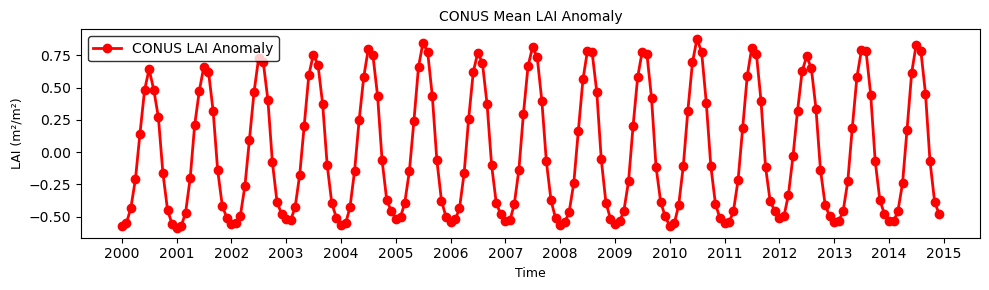

In [9]:
#-------------------------------
# Define file pattern & CONUS bounds
#-------------------------------
PATTERN = "/bsuhome/ksilwimba/scratch/emulation_with_forcing/observation_data/lai_monthly_0.1_20*.nc"
CONUS_BOUNDS = dict(
    min_lon=235,
    max_lon=294,
    min_lat=24.5,
    max_lat=49.5,
)

#-------------------------------
# Load and fix time coordinates
#-------------------------------
ds = load_modis_lai(PATTERN)
print("Loaded dataset with dimensions:", ds.sizes)
print("Variables:", list(ds.data_vars))

#-------------------------------
# Normalize longitudes & ensure ascending latitude
#-------------------------------
ds = normalize_longitudes(ds).sortby("lat")

#-------------------------------
# Subset to CONUS region
#-------------------------------
ds_conus = ds.sel(
    lon=slice(CONUS_BOUNDS['min_lon'], CONUS_BOUNDS['max_lon']),
    lat=slice(CONUS_BOUNDS['min_lat'], CONUS_BOUNDS['max_lat'])
)
print(f"CONUS LAI shape: {ds_conus['lai'].sizes}")

#-------------------------------
# Compute gridcell anomalies
#-------------------------------
anom = compute_lai_anomalies(ds_conus)

#-------------------------------
# Compute spatial mean anomaly time series
#-------------------------------
ts = compute_spatial_mean_anomaly(anom)
print(ts)

#-------------------------------
# Plot CONUS LAI anomaly time series
#-------------------------------

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(
    ts['time'],
    ts,
    marker='o',
    linestyle='-',
    linewidth=2,
    color='r',
    label='CONUS LAI Anomaly'
)
ax.set_title('CONUS Mean LAI Anomaly', fontsize=10, fontweight='regular')
ax.set_xlabel('Time', fontsize=9)
ax.set_ylabel('LAI (m²/m²)', fontsize=9)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# fig.autofmt_xdate(ha='right')
# ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

# EDNN Model Performance on Unseen CLM5-PPE Ensemble Members

In [10]:
clm5_lai_ppe_anom = y_val_3d#.mean(dim="gridcell")            # dims (member, time)
ednn_ppe_lai_anom = pred_val_3d["mu"]#.mean(dim="gridcell")  # dims (member, time
time_cftime = ednn_ppe_lai_anom.time.values
time_idx = pd.to_datetime([
    f"{t.year}-{t.month:02d}-{t.day:02d}" for t in time_cftime
]) 

In [11]:
figure_path = "/bsuhome/ksilwimba/scratch/emulation_with_forcing/clm5-lai-ppe-ednn/ednn-paper-code/Figures"

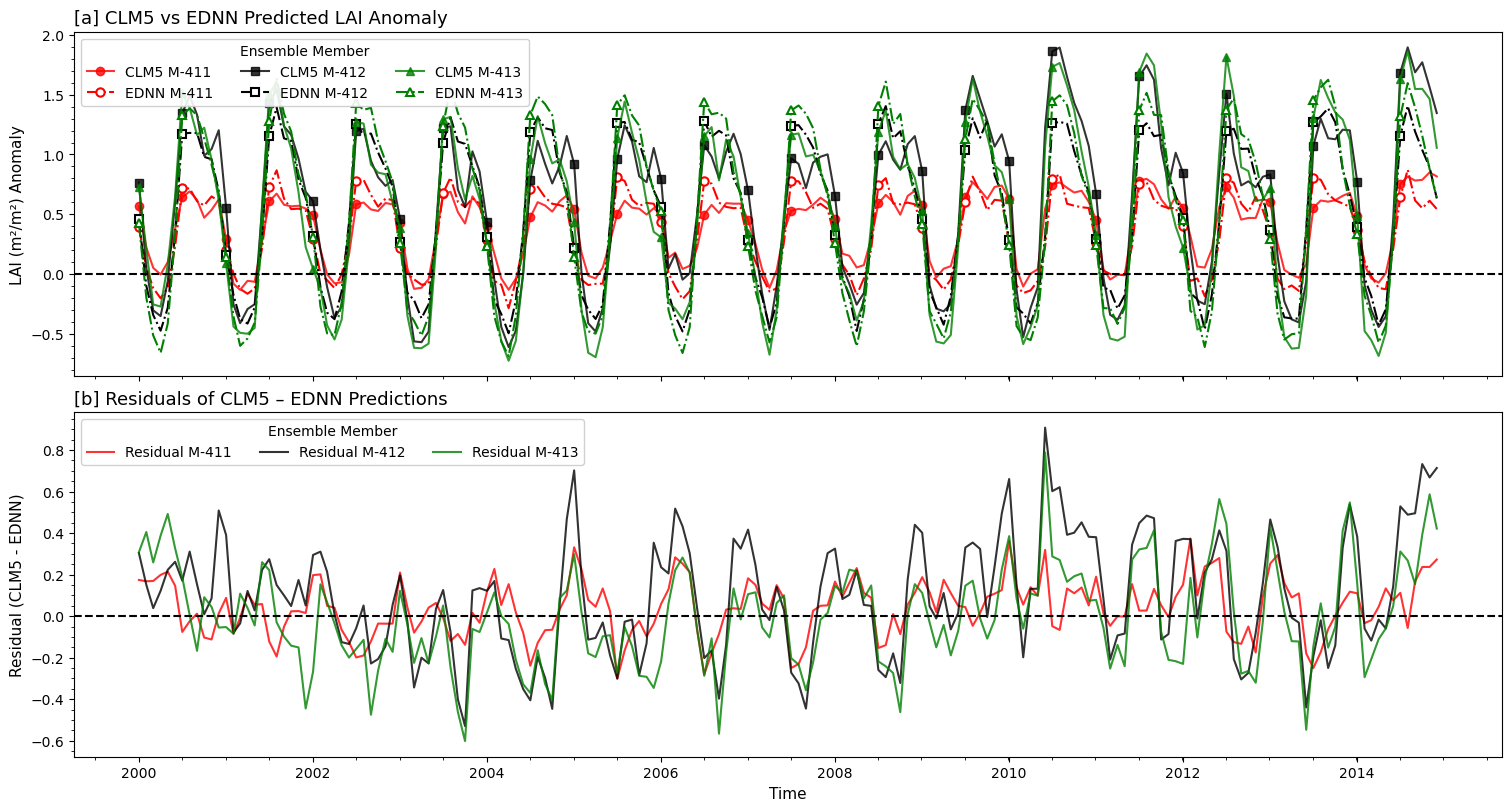

In [12]:
# Convert xarray time coordinate to pandas DateTimeIndex
time_idx = pd.to_datetime([
    f"{t.year}-{t.month:02d}-{t.day:02d}" for t in clm5_lai_ppe_anom.time.values
])
#----------------- Select a subset of ensemble members for plotting
members = clm5_lai_ppe_anom.member.values[10:13]

#-------------------------------
# Cell: Define Colors & Markers
#-------------------------------
palette = ['red', 'black', 'green']
markers = ['o', 's', '^']
member_colors = {m: palette[i] for i, m in enumerate(members)}
member_markers = {m: markers[i] for i, m in enumerate(members)}

#-------------------------------
# Cell: Plot Time Series & Residuals
#-------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(15, 8),
    sharex=True,
    constrained_layout=True
)

#----------------- (a) CLM5 vs EDNN Predicted LAI Anomaly
ax1.set_title(
    "[a] CLM5 vs EDNN Predicted LAI Anomaly",
    fontsize=13,
    loc='left'
)
ax1.set_ylabel("LAI (m²/m²) Anomaly", fontsize=11)
ax1.minorticks_on()
for m in members:
    #----------------- True values: solid line
    ax1.plot(
        time_idx,
        clm5_lai_ppe_anom.sel(member=m),
        label=f"CLM5 M-{m}",
        color=member_colors[m],
        marker=member_markers[m],
        linestyle='-',
        linewidth=1.5,
        markersize=6,
        alpha=0.8,
        markevery=6
    )
    #----------------- Predicted values: dashdot
    ax1.plot(
        time_idx,
        ednn_ppe_lai_anom.sel(member=m),
        label=f"EDNN M-{m}",
        color=member_colors[m],
        marker=member_markers[m],
        linestyle='dashdot',
        linewidth=1.5,
        markersize=6,
        markerfacecolor='white',
        markeredgewidth=1.5,
        alpha=1,
        markevery=6
    )
ax1.axhline(0, color='black', linestyle='--')
ax1.legend(
    title='Ensemble Member',
    title_fontsize=10,
    fontsize=10,
    loc='upper left',
    frameon=True,
    framealpha=0.9,
    ncol=3
)

#----------------- (b) Residuals: CLM5 minus EDNN
ax2.set_title(
    "[b] Residuals of CLM5 – EDNN Predictions",
    fontsize=13,
    loc='left'
)
ax2.set_xlabel("Time", fontsize=11)
ax2.set_ylabel("Residual (CLM5 - EDNN)", fontsize=11)
ax2.minorticks_on()
for m in members:
    residuals = (
        clm5_lai_ppe_anom.sel(member=m)
        - ednn_ppe_lai_anom.sel(member=m)
    )
    ax2.plot(
        time_idx,
        residuals,
        label=f"Residual M-{m}",
        color=member_colors[m],
        alpha=0.8
    )
ax2.axhline(0, color='black', linestyle='--')
ax2.legend(
    title='Ensemble Member',
    title_fontsize=10,
    fontsize=10,
    loc='upper left',
    frameon=True,
    framealpha=0.9,
    ncol=3
)
# plt.tight_layout()
plt.savefig(figure_path+"/TLAI_timeseries_with_residuals.pdf", bbox_inches='tight')
plt.show()

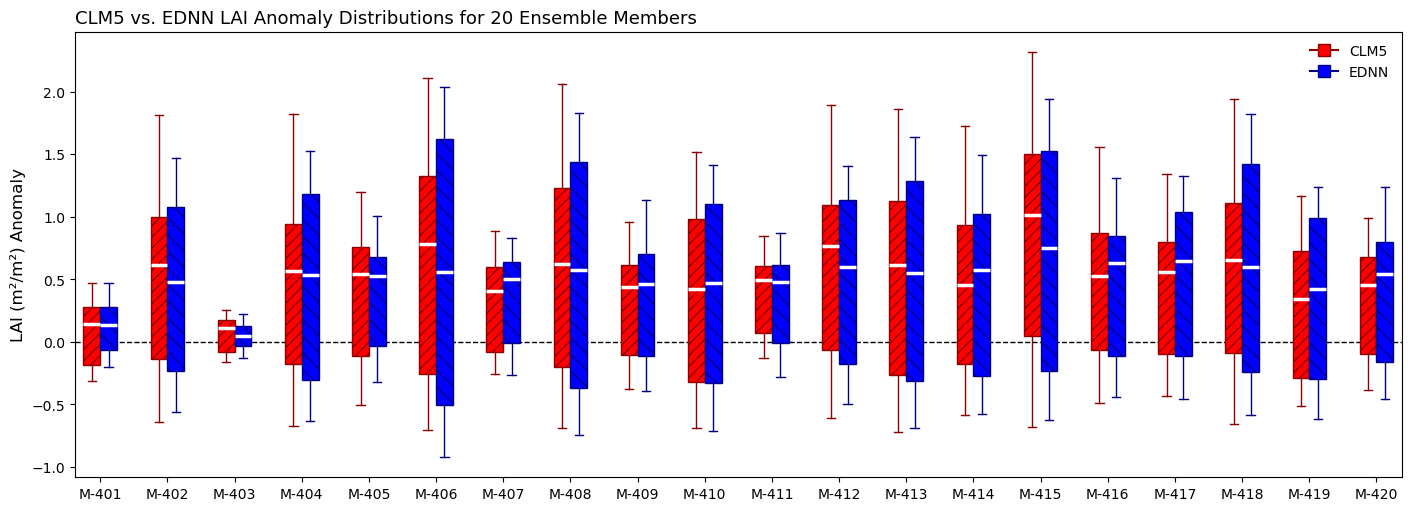

In [13]:
#-------------------------------
#Data Preparation
#-------------------------------
#------------------------------- Select first 20 ensemble members
members = clm5_lai_ppe_anom.member.values[:20]

#------------------------------- Extract anomalies for CLM5 and EDNN per member
clm5_data = [clm5_lai_ppe_anom.sel(member=m).values for m in members]
ednn_data = [ednn_ppe_lai_anom.sel(member=m).values for m in members]

#-------------------------------
# Plot Configuration
#-------------------------------
n = len(members)
width = 0.5
x_positions = np.arange(n) * 2.0
pos_clm5 = x_positions
pos_ednn = x_positions + width

#------------------------------- Define hatch and color properties
color_clm5 = {'face': 'red', 'edge': 'darkred', 'hatch': '///'}
color_ednn = {'face': 'blue', 'edge': 'navy', 'hatch': '\\\\'}

# Prepare legend handles
legend_handles = [
    mlines.Line2D([], [], color=color_clm5['edge'], marker='s', markersize=8,
                  markerfacecolor=color_clm5['face'], markeredgecolor=color_clm5['edge'],
                  label='CLM5'),
    mlines.Line2D([], [], color=color_ednn['edge'], marker='s', markersize=8,
                  markerfacecolor=color_ednn['face'], markeredgecolor=color_ednn['edge'],
                  label='EDNN')
]

#-------------------------------
# Create Boxplots
#-------------------------------
fig, ax = plt.subplots(figsize=(14, 5), constrained_layout=True)

#------------------------------- CLM5 boxplot
ax.boxplot(
    clm5_data,
    positions=pos_clm5,
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor=color_clm5['face'], edgecolor=color_clm5['edge'], hatch=color_clm5['hatch']),
    medianprops=dict(color='white', linewidth=2.5),
    whiskerprops=dict(color=color_clm5['edge']),
    capprops=dict(color=color_clm5['edge']),
    flierprops=dict(marker='o', markerfacecolor=color_clm5['edge'], markeredgecolor=color_clm5['edge'],
                    markersize=4, linestyle='none', alpha=0.5)
)

#----------------------- EDNN boxplot
ax.boxplot(
    ednn_data,
    positions=pos_ednn,
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor=color_ednn['face'], edgecolor=color_ednn['edge'], hatch=color_ednn['hatch']),
    medianprops=dict(color='white', linewidth=2.5),
    whiskerprops=dict(color=color_ednn['edge']),
    capprops=dict(color=color_ednn['edge']),
    flierprops=dict(marker='o', markerfacecolor=color_ednn['edge'], markeredgecolor=color_ednn['edge'],
                    markersize=4, linestyle='none', alpha=0.5)
)

#-------------------------------
# Finalize Plot
#-------------------------------
#----------------------- Centered x-axis labels
ax.set_xticks(x_positions + width / 2)
ax.set_xticklabels([f"M-{m}" for m in members], fontsize=10)

#----------------------- Axis labels and title
ax.set_ylabel("LAI (m²/m²) Anomaly", fontsize=12)
ax.set_title(
    "CLM5 vs. EDNN LAI Anomaly Distributions for 20 Ensemble Members",
    fontsize=13,
    loc='left'
)

#----------------------- Zero reference line behind boxes
tmp_zorder = ax.get_zorder()
ax.axhline(0, color='black', linestyle='--', linewidth=1, zorder=tmp_zorder-1)

#----------------------- Legend
ax.legend(handles=legend_handles, loc='upper right', frameon=False, fontsize=10)

#----------------------- Save and show
plt.savefig(f"{figure_path}/ensemble_member_boxplots_hatched.pdf", bbox_inches='tight')
plt.show()


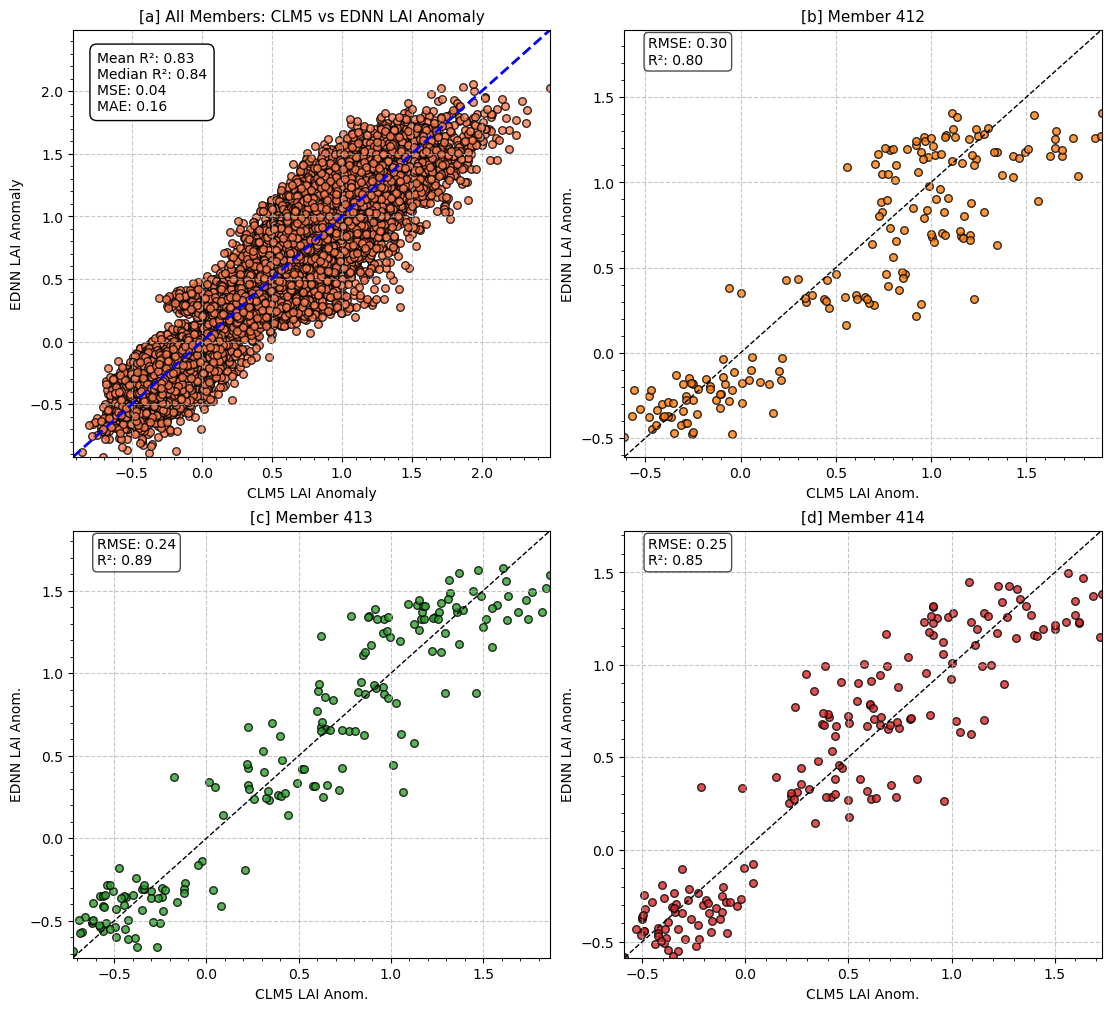

In [14]:
#-------------------------------
# Data Preparation
#-------------------------------
#------------------------------- Flatten all ensemble-member anomalies for overall scatter
data_true = clm5_lai_ppe_anom.values.flatten()
data_pred = ednn_ppe_lai_anom.values.flatten()

#------------------------------- Select four members to plot (using indices 10–13)
members_to_plot = clm5_lai_ppe_anom.member.values[10:14]

# Convert xarray time coordinate to pandas DateTimeIndex
time_idx = pd.to_datetime([
    f"{t.year}-{t.month:02d}-{t.day:02d}" for t in clm5_lai_ppe_anom.time.values
])

#-------------------------------
# Compute Statistics
#-------------------------------
#------------------------------- Overall metrics across all members
total_mse = mean_squared_error(data_true, data_pred)
total_mae = mean_absolute_error(data_true, data_pred)
r2_all = r2_score(data_true, data_pred)

#------------------------------- Per-member R² for annotation in first subplot
r2_per_member = [
    r2_score(
        clm5_lai_ppe_anom.sel(member=m).values,
        ednn_ppe_lai_anom.sel(member=m).values
    ) for m in clm5_lai_ppe_anom.member.values
]
mean_r2 = np.mean(r2_per_member)
median_r2 = np.median(r2_per_member)

#------------------------------- Scatter plot axis limits based on data range
vmin = min(data_true.min(), data_pred.min())
vmax = max(data_true.max(), data_pred.max())

#-------------------------------
# Create 2×2 Scatter Grid
#-------------------------------
fig, axs = plt.subplots(
    2, 2,
    figsize=(11, 10),
    constrained_layout=True
)

#------------------------------- Subplot [a]: All-members scatter
ax = axs[0, 0]
ax.scatter(
    data_true, data_pred,
    color='coral', edgecolor='black', s=30, alpha=0.8
)
ax.plot([vmin, vmax], [vmin, vmax], linestyle='--', color='blue', linewidth=2)
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_title('[a] All Members: CLM5 vs EDNN LAI Anomaly', fontsize=11)
ax.set_xlabel('CLM5 LAI Anomaly', fontsize=10)
ax.set_ylabel('EDNN LAI Anomaly', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)
ax.minorticks_on()
#------------------------------- Annotate overall stats
ax.text(
    0.05, 0.95,
    f"Mean R²: {mean_r2:.2f}\n"
    f"Median R²: {median_r2:.2f}\n"
    f"MSE: {total_mse:.2f}\n"
    f"MAE: {total_mae:.2f}",
    transform=ax.transAxes,
    va='top', ha='left', fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

#------------------------------- Subplots [b-d]: Individual member scatter with RMSE and R²
for idx, m in enumerate(members_to_plot[1:], start=1):
    ax = axs.flat[idx]
    true_vals = clm5_lai_ppe_anom.sel(member=m).values
    pred_vals = ednn_ppe_lai_anom.sel(member=m).values

    #------------------------------- Member-specific metrics
    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    r2_m = r2_score(true_vals, pred_vals)

    #------------------------------- Scatter and 1:1 line
    ax.scatter(
        true_vals, pred_vals,
        color=plt.cm.tab10(idx), edgecolor='black', s=30, alpha=0.8
    )
    lims = [
        min(true_vals.min(), pred_vals.min()),
        max(true_vals.max(), pred_vals.max())
    ]
    ax.plot(lims, lims, linestyle='--', color='black', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    #------------------------------- Annotations and titles
    ax.set_title(f"[{chr(96+idx+1)}] Member {m}", fontsize=11)
    ax.set_xlabel('CLM5 LAI Anom.', fontsize=10)
    ax.set_ylabel('EDNN LAI Anom.', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.minorticks_on()

    ax.text(
        lims[0] + 0.05*(lims[1]-lims[0]),
        lims[1] - 0.08*(lims[1]-lims[0]),
        f"RMSE: {rmse:.2f}\nR²: {r2_m:.2f}",
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )

#-------------------------------
# Save and Show
#-------------------------------
plt.savefig(f"{figure_path}/scatterplot_combined.pdf", bbox_inches='tight')
plt.show()

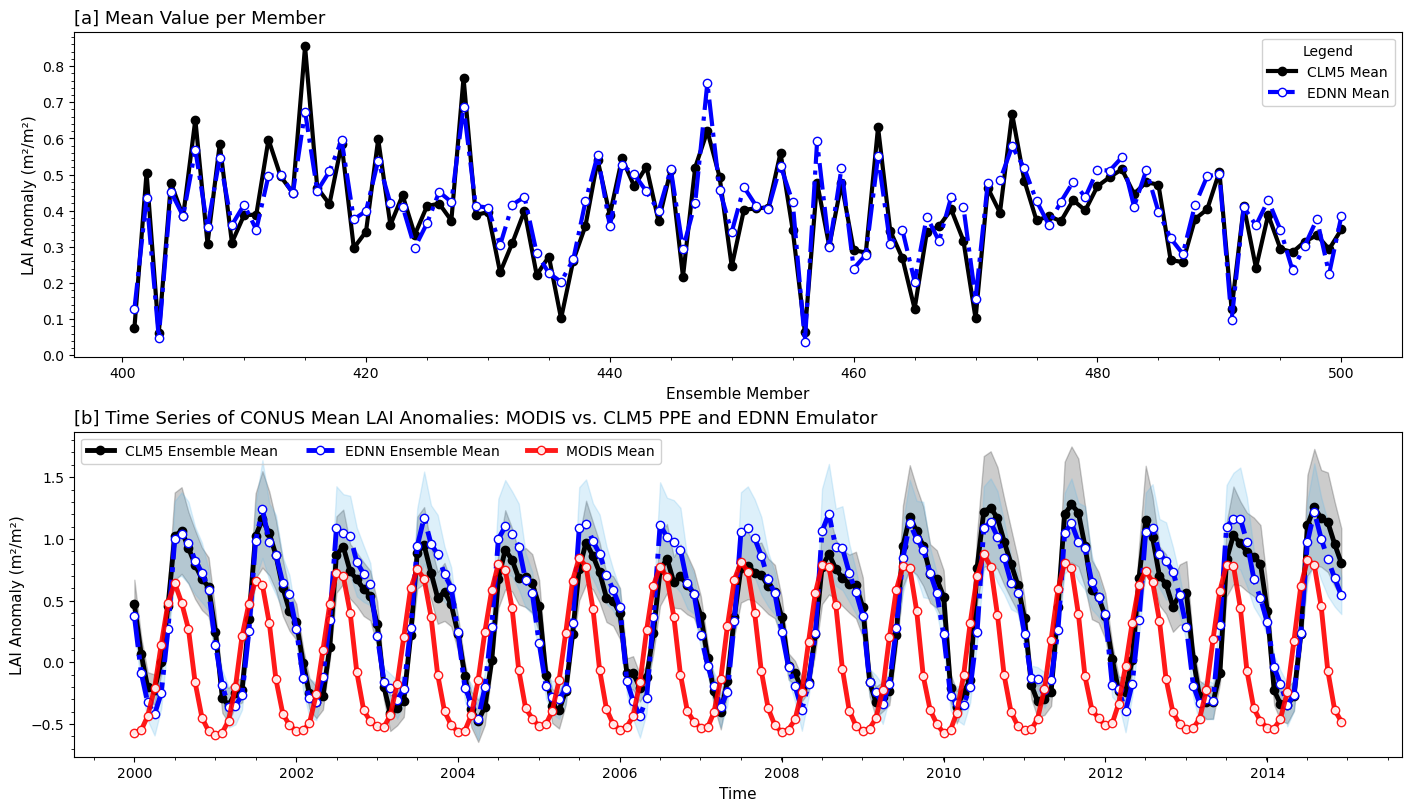

In [15]:
#-------------------------------
# Compute Summary Statistics
#-------------------------------
#------------------------------- Per-member statistics over time
data_clm5_member_mean = clm5_lai_ppe_anom.mean(dim='time')
data_clm5_member_std  = clm5_lai_ppe_anom.std(dim='time')
data_ednn_member_mean = ednn_ppe_lai_anom.mean(dim='time')
data_ednn_member_std  = ednn_ppe_lai_anom.std(dim='time')

#------------------------------- Ensemble statistics over members for each time step
data_clm5_ens_mean = clm5_lai_ppe_anom.mean(dim='member')
data_clm5_ens_std  = clm5_lai_ppe_anom.std(dim='member')
data_ednn_ens_mean = ednn_ppe_lai_anom.mean(dim='member')
data_ednn_ens_std  = ednn_ppe_lai_anom.std(dim='member')

#-------------------------------
# Cell: Setup Figure and Axes
#-------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 8),
    constrained_layout=True
)

#-------------------------------
# [a] Mean per Member
#-------------------------------
members = clm5_lai_ppe_anom.member.values
ax1.plot(
    members,
    data_clm5_member_mean,
    linestyle='-',
    color='black',
    marker='o',
    markersize=6,
    linewidth=3,
    label='CLM5 Mean'
)
ax1.plot(
    members,
    data_ednn_member_mean,
    linestyle='dashdot',
    color='blue',
    marker='o',
    markersize=6,
    markerfacecolor='white',
    linewidth=3,
    label='EDNN Mean'
)
ax1.set_title('[a] Mean Value per Member', loc='left', fontsize=13)
ax1.set_xlabel('Ensemble Member', fontsize=11)
ax1.set_ylabel('LAI Anomaly (m²/m²)', fontsize=11)
ax1.legend(frameon=True, framealpha=0.9, fontsize=10, title='Legend')
ax1.minorticks_on()

#-------------------------------
# [b] Ensemble Mean Over Time (with Observations)
#-------------------------------
time = time_idx  # pandas.DatetimeIndex
modis_series = ts    # observed MODIS CONUS mean anomaly

#------------------------------- CLM5 ensemble mean + ±1σ
ax2.plot(
    time,
    data_clm5_ens_mean,
    linestyle='-',
    color='black',
    marker='o',
    markersize=6,
    linewidth=3.5,
    label='CLM5 Ensemble Mean'
)
ax2.fill_between(
    time,
    data_clm5_ens_mean - data_clm5_ens_std,
    data_clm5_ens_mean + data_clm5_ens_std,
    color='black',
    alpha=0.2
)

#------------------------------- EDNN ensemble mean + ±1σ
ax2.plot(
    time,
    data_ednn_ens_mean,
    linestyle='dashdot',
    color='blue',
    marker='o',
    markersize=6,
    markerfacecolor='white',
    linewidth=3.5,
    label='EDNN Ensemble Mean'
)
ax2.fill_between(
    time,
    data_ednn_ens_mean - data_ednn_ens_std,
    data_ednn_ens_mean + data_ednn_ens_std,
    color='#56B4E9',
    alpha=0.2
)

#------------------------------- MODIS CONUS observation
ax2.plot(
    time,
    modis_series,
    linestyle='-',
    color='red',
    marker='o',
    markersize=6,
    markerfacecolor='white',
    linewidth=3.5,
    alpha=0.9,
    label='MODIS Mean'
)

ax2.set_title(
    '[b] Time Series of CONUS Mean LAI Anomalies: MODIS vs. CLM5 PPE and EDNN Emulator',
    loc='left', fontsize=13
)
ax2.set_xlabel('Time', fontsize=11)
ax2.set_ylabel('LAI Anomaly (m²/m²)', fontsize=11)
ax2.legend(
    loc='upper left',
    ncol=3,
    frameon=True,
    framealpha=0.9,
    title_fontsize=12,
    fontsize=10,
    facecolor='none'
)
ax2.minorticks_on()

#-------------------------------
# Save and Show
#-------------------------------
plt.savefig(f"{figure_path}/TLAI_mean_with_obs.pdf", bbox_inches='tight')
plt.show()

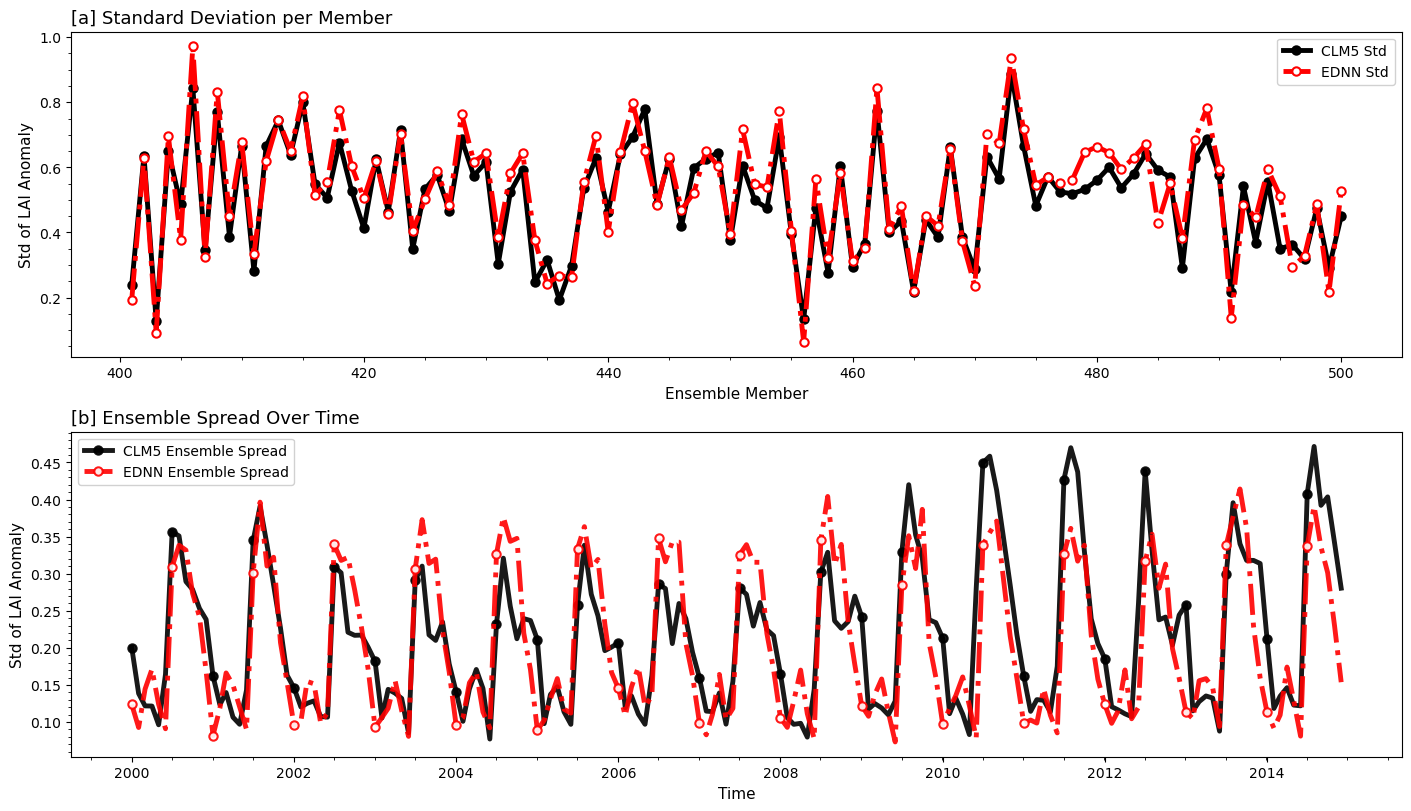

In [16]:
#-------------------------------
# Plot Standard Deviations and Ensemble Spread
#-------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 8),
    constrained_layout=True
)

#------------------------------- [a] Standard Deviation per Member
ax1.plot(
    members,
    data_clm5_member_std,
    linestyle='-',
    color='black',
    marker='o',
    markersize=6,
    markeredgewidth=1.5,
    linewidth=3.5,
    label='CLM5 Std'
)
ax1.plot(
    members,
    data_ednn_member_std,
    linestyle='dashdot',
    color='red',
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=1.5,
    linewidth=3.5,
    label='EDNN Std'
)
ax1.set_title('[a] Standard Deviation per Member', loc='left', fontsize=13)
ax1.set_xlabel('Ensemble Member', fontsize=11)
ax1.set_ylabel('Std of LAI Anomaly', fontsize=11)
ax1.legend(fontsize=10, frameon=True, framealpha=0.9)
ax1.minorticks_on()

#------------------------------- [b] Ensemble Spread Over Time
ax2.plot(
    time_idx,
    data_clm5_ens_std,
    linestyle='-',
    color='black',
    marker='o',
    markevery=6,
    markersize=6,
    markeredgewidth=1.5,
    linewidth=3.5,
    alpha=0.9,
    label='CLM5 Ensemble Spread'
)
ax2.plot(
    time_idx,
    data_ednn_ens_std,
    linestyle='dashdot',
    color='red',
    marker='o',
    markevery=6,
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=1.5,
    linewidth=3.5,
    alpha=0.9,
    label='EDNN Ensemble Spread'
)
ax2.set_title('[b] Ensemble Spread Over Time', loc='left', fontsize=13)
ax2.set_xlabel('Time', fontsize=11)
ax2.set_ylabel('Std of LAI Anomaly', fontsize=11)
ax2.legend(fontsize=10, loc='upper left', frameon=True, framealpha=0.9)
ax2.minorticks_on()

#-------------------------------
# Save & Show
#-------------------------------
plt.savefig(f"{figure_path}/TLAI_std.pdf", bbox_inches='tight')
plt.show()

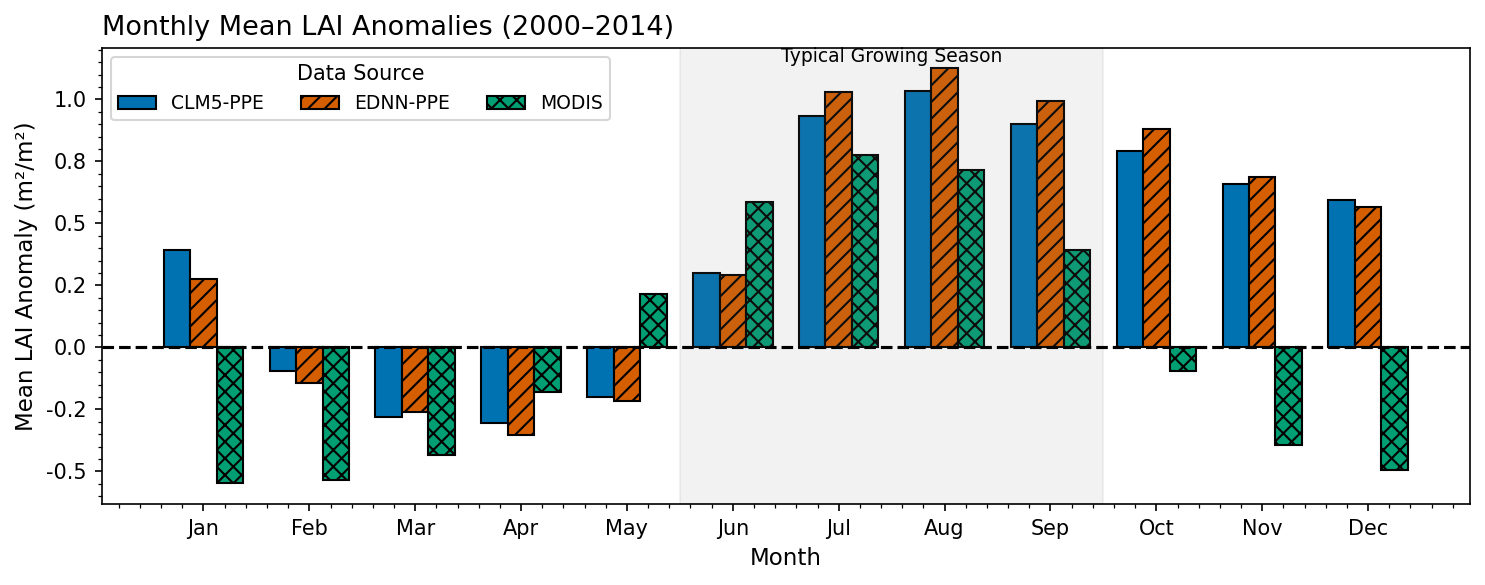

In [17]:
#-------------------------------
# Compute Monthly Means
#-------------------------------
#------------------------------- MODIS: average over all Januaries, Februaries, … Decembers
modis_monthly = ts.groupby('time.month').mean(dim='time')

#------------------------------- CLM5: average over time for each month, then over ensemble members
clm5_monthly = (
    clm5_lai_ppe_anom
    .groupby('time.month')
    .mean(dim='time')
    .mean(dim='member')
)

#------------------------------- EDNN: same procedure
ednn_monthly = (
    ednn_ppe_lai_anom
    .groupby('time.month')
    .mean(dim='time')
    .mean(dim='member')
)

#-------------------------------
# Prepare Plot Data
#-------------------------------
months = np.arange(1, 13)
labels = [calendar.month_abbr[m] for m in months]

clm5_vals  = clm5_monthly.sel(month=months).values
ednn_vals  = ednn_monthly.sel(month=months).values
modis_vals = modis_monthly.sel(month=months).values

x = np.arange(12)
width = 0.25

#------------------------------- Colorblind-friendly palette and hatches
colors = {
    'CLM5': '#0072B2',
    'EDNN': '#D55E00',
    'MODIS':'#009E73'
}
hatches = {
    'CLM5': '',
    'EDNN':'///',
    'MODIS':'xxx'
}

#-------------------------------
# Create Bar Plot
#-------------------------------
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

#------------------------------- CLM5 bars
ax.bar(
    x - width, clm5_vals, width,
    color=colors['CLM5'], edgecolor='black', hatch=hatches['CLM5'],
    label='CLM5-PPE'
)
#------------------------------- EDNN bars
ax.bar(
    x, ednn_vals, width,
    color=colors['EDNN'], edgecolor='black', hatch=hatches['EDNN'],
    label='EDNN-PPE'
)
#------------------------------- MODIS bars
ax.bar(
    x + width, modis_vals, width,
    color=colors['MODIS'], edgecolor='black', hatch=hatches['MODIS'],
    label='MODIS'
)
#------------------------------- Highlight growing season (May to Sep)
ax.axvspan(4.5, 8.5, color='gray', alpha=0.1)
ax.text(
    6.5, ax.get_ylim()[1]*0.95,
    'Typical Growing Season',
    ha='center', fontsize=9
)

#-------------------------------
# Styling
#-------------------------------
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_xlabel('Month', fontsize=11)
ax.axhline(0, color='black', linestyle='--')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_ylabel('Mean LAI Anomaly (m²/m²)', fontsize=11)
ax.set_title(
    'Monthly Mean LAI Anomalies (2000–2014)',
    loc='left', fontsize=13
)
ax.legend(
    title='Data Source',
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    framealpha=0.8,
    ncol=3
)
ax.minorticks_on()

#-------------------------------
# Save & Show
#-------------------------------
plt.tight_layout()
plt.savefig(f"{figure_path}/monthly_lai_anomalies_barplot.pdf", bbox_inches='tight')
plt.show()

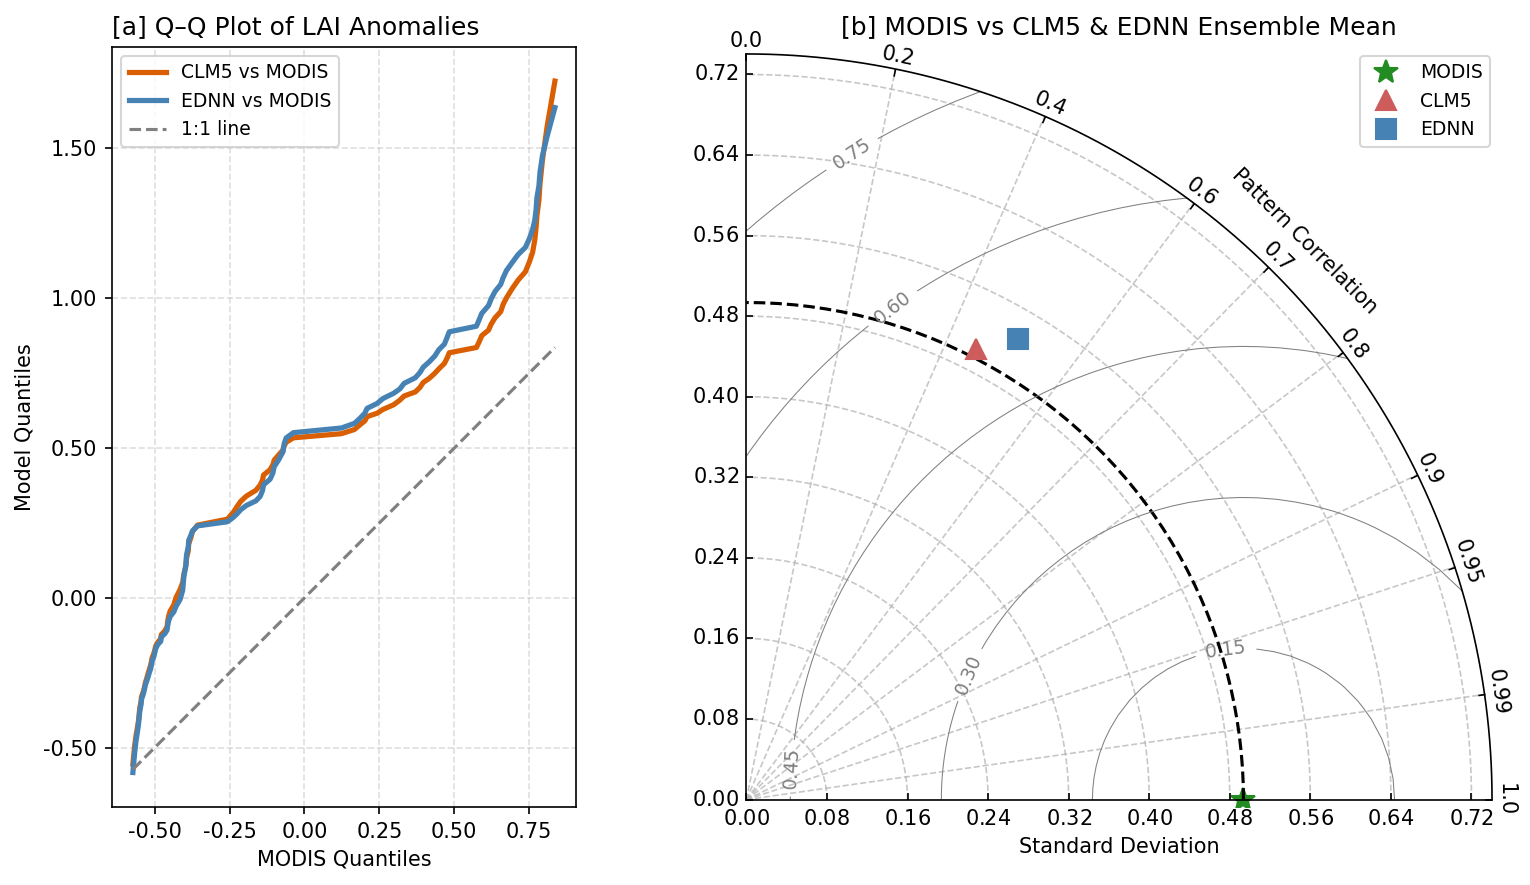

In [18]:
#-------------------------------
# Prepare Quantile Data and KS-Statistics
#-------------------------------
#------------------------------- Flatten anomaly arrays for all members and times
clm5_flat = clm5_lai_ppe_anom.values.flatten()
ednn_flat = ednn_ppe_lai_anom.values.flatten()
modis_flat = ts.values.flatten()

#------------------------------- Define quantile levels and compute quantiles
q = np.linspace(0.01, 0.99, 99)
modis_q = np.quantile(modis_flat, q)
clm5_q   = np.quantile(clm5_flat, q)
ednn_q   = np.quantile(ednn_flat, q)

#------------------------------- Kolmogorov-Smirnov test vs MODIS
D_clm5, p_clm5 = ks_2samp(clm5_flat, modis_flat)
D_ednn, p_ednn = ks_2samp(ednn_flat, modis_flat)

#-------------------------------
# Cell: Compute Taylor Diagram Statistics
#-------------------------------
#------------------------------- Time series across ensemble mean for each dataset
clm5_ts = clm5_lai_ppe_anom.mean(dim='member').values
ednn_ts = ednn_ppe_lai_anom.mean(dim='member').values
obs_ts  = ts.values

#------------------------------- Compute standard deviations and correlations
std_ref   = obs_ts.std(ddof=1)
std_clm5  = clm5_ts.std(ddof=1)
corr_clm5 = corrcoef(obs_ts, clm5_ts)[0, 1]
std_ednn  = ednn_ts.std(ddof=1)
corr_ednn = corrcoef(obs_ts, ednn_ts)[0, 1]

#------------------------------- Pack samples for Taylor diagram
samples = [
    (std_clm5, corr_clm5, 'CLM5'),
    (std_ednn, corr_ednn, 'EDNN')
]

#-------------------------------
# Taylor Diagram Function
#-------------------------------
def create_taylor_diagram(std_ref, samples, title, fig, rect, add_legend=False):
    """
    Build a Taylor diagram comparing sample std-dev and correlation to reference.
    Requires TaylorDiagram class on PYTHONPATH.
    """
    dia = TaylorDiagram(std_ref, fig=fig, rect=rect, label='MODIS', extend=False)
    #------------------------------- Format reference point
    dia.samplePoints[0].set_color('forestgreen')
    dia.samplePoints[0].set_markersize(12)
    #------------------------------- Add each model sample
    markers = ['^', 's']
    colors  = ['indianred', 'steelblue']
    for i, (s, c, name) in enumerate(samples):
        dia.add_sample(s, c,
                       marker=markers[i], ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=name)
    #------------------------------- Add RMS contours
    contours = dia.add_contours(levels=5, colors='0.5', linewidths=0.5)
    fig.axes[0].clabel(contours, inline=1, fontsize=9, fmt='%.2f')
    dia._ax.grid(True, linestyle='--', alpha=0.7)
    dia._ax.set_title(title, loc='center', fontsize=12)
    if add_legend:
        dia._ax.legend(loc='upper right', fontsize=9, frameon=True)
    fig.tight_layout()
    return dia

#-------------------------------
# Create Q–Q and Taylor Plots
#-------------------------------
fig = plt.figure(figsize=(12, 6), dpi=150)

#------------------------------- [a] Q–Q Plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(modis_q, clm5_q,   color='#d95f02', linewidth=2.5, label='CLM5 vs MODIS')
ax1.plot(modis_q, ednn_q,   color='steelblue', linewidth=2.5, label='EDNN vs MODIS')
ax1.plot(modis_q, modis_q,  color='gray', linestyle='--', linewidth=1.5, label='1:1 line')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('MODIS Quantiles', fontsize=10)
ax1.set_ylabel('Model Quantiles', fontsize=10)
ax1.set_title('[a] Q–Q Plot of LAI Anomalies', loc='left', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(fontsize=9)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#------------------------------- [b] Taylor Diagram
create_taylor_diagram(
    std_ref, samples,
    title='[b] MODIS vs CLM5 & EDNN Ensemble Mean',
    fig=fig, rect=122,
    add_legend=True
)

#------------------------------- Adjust layout and display
plt.tight_layout()
plt.savefig(f"{figure_path}/qq_and_taylor_comparison.pdf", bbox_inches='tight')
plt.show()

# Predictive Uncertainty EDNN Emulations

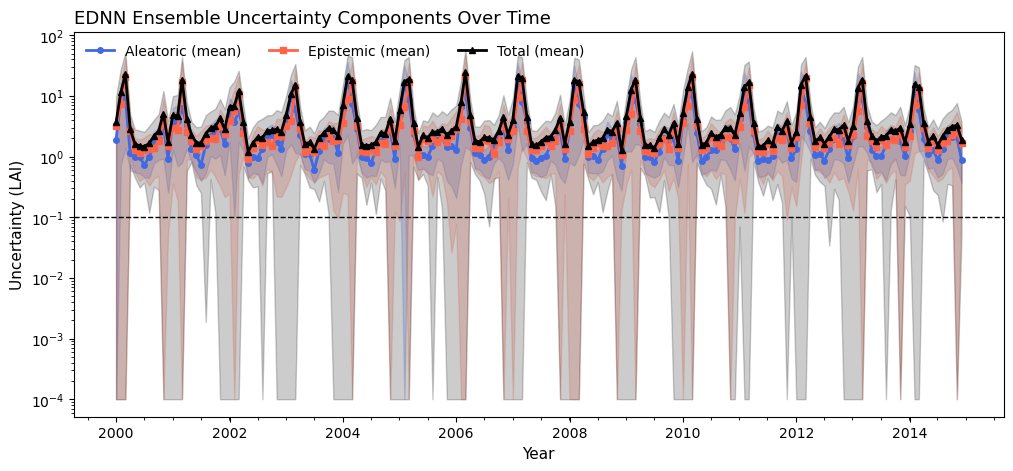

In [19]:
#-------------------------------
# Data Preparation
#-------------------------------
# Extract aleatoric and epistemic uncertainty components
ale = pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric')
epi = pred_val_3d.TLAI_unc.sel(uncertainty='epistemic')

#------------------------------- Compute ensemble means and standard deviations across members
ale_mean = ale.mean(dim='member')
ale_std  = ale.std(dim='member')
epi_mean = epi.mean(dim='member')
epi_std  = epi.std(dim='member')

#------------------------------- Total uncertainty: root-sum-square of component means, sum of stds
total_mean = np.sqrt(ale_mean**2 + epi_mean**2)
total_std  = ale_std + epi_std

#------------------------------- Prevent negative lower bounds for log scale
lower_clip  = 1e-4
ale_lower   = np.clip(ale_mean - ale_std, lower_clip, None)
epi_lower   = np.clip(epi_mean - epi_std, lower_clip, None)
total_lower = np.clip(total_mean - total_std, lower_clip, None)

#-------------------------------
# Plot Uncertainty Time Series (Log Scale)
#-------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

#------------------------------- Aleatoric uncertainty
ax.plot(
    time_idx, ale_mean,
    label='Aleatoric (mean)',
    color='royalblue',
    linewidth=2,
    marker='o',
    markersize=4
)
ax.fill_between(
    time_idx,
    ale_lower,
    ale_mean + ale_std,
    color='royalblue',
    alpha=0.2
)

#------------------------------- Epistemic uncertainty
ax.plot(
    time_idx, epi_mean,
    label='Epistemic (mean)',
    color='tomato',
    linewidth=2,
    marker='s',
    markersize=4
)
ax.fill_between(
    time_idx,
    epi_lower,
    epi_mean + epi_std,
    color='tomato',
    alpha=0.2
)

#------------------------------- Total uncertainty
ax.plot(
    time_idx, total_mean,
    label='Total (mean)',
    color='black',
    linewidth=2,
    marker='^',
    markersize=4
)
ax.fill_between(
    time_idx,
    total_lower,
    total_mean + total_std,
    color='black',
    alpha=0.2
)

#------------------------------- Logarithmic y-axis
ax.set_yscale('log')

#------------------------------- Reference line, labels, title, and legend
ax.axhline(1e-1, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Uncertainty (LAI)', fontsize=11)
ax.set_title(
    'EDNN Ensemble Uncertainty Components Over Time',
    fontsize=13,
    loc='left'
)
ax.legend(loc='upper left', fontsize=10, ncol=3, frameon=False)
ax.minorticks_on()

# ------------------------------- Save figure\ nplt.tight_layout()
plt.savefig(f"{figure_path}/uncertainty_timeseries_log.pdf", bbox_inches='tight')
plt.show()

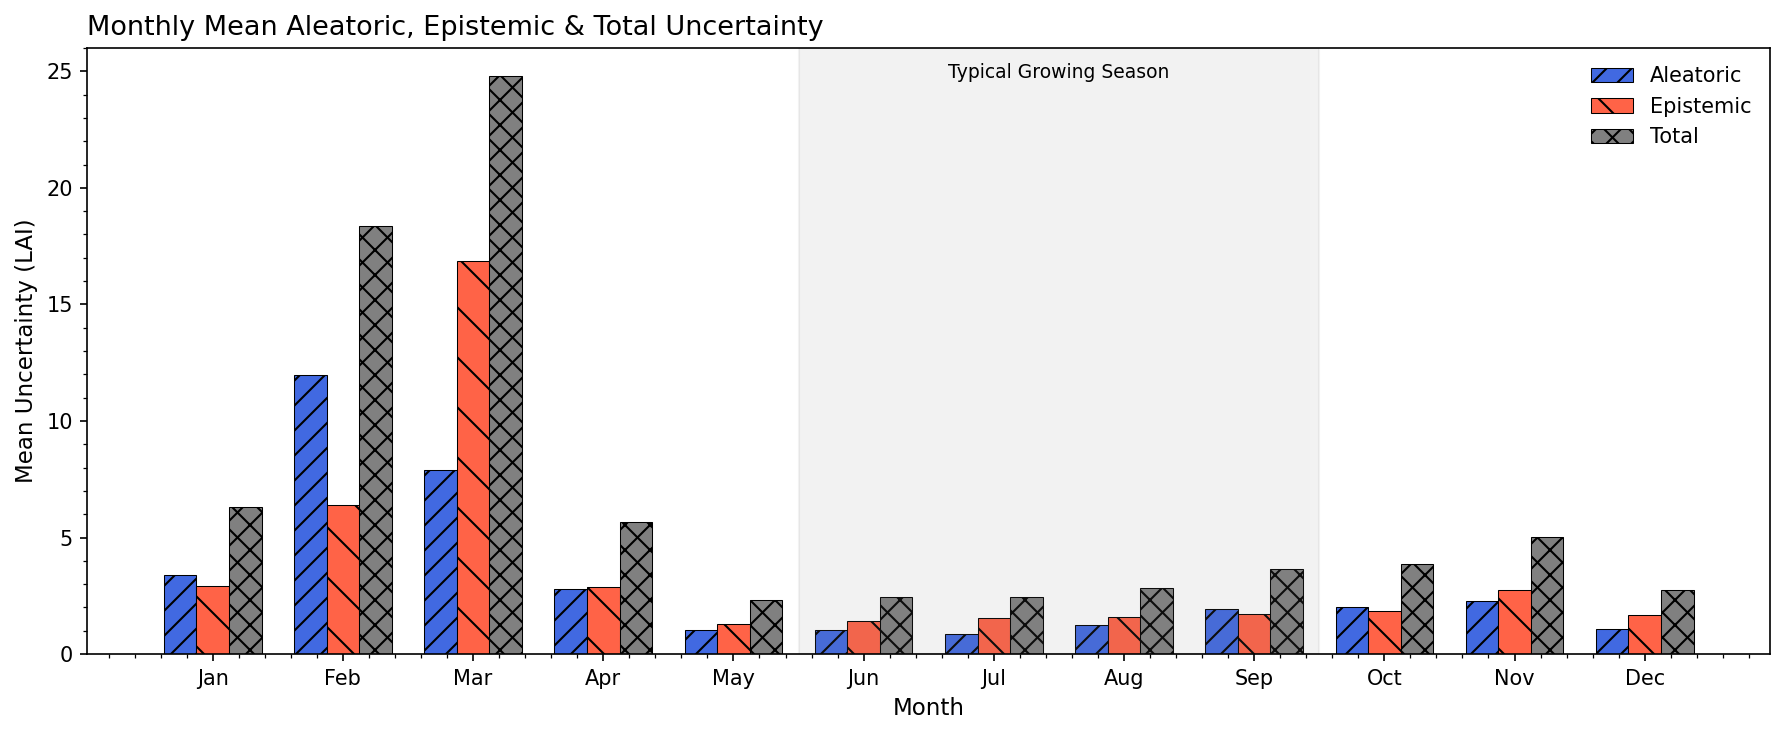

In [20]:
#-------------------------------
# Data Preparation
#-------------------------------
#-------------------- Extract aleatoric and epistemic uncertainties
ale = pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric')
epi = pred_val_3d.TLAI_unc.sel(uncertainty='epistemic')

#-------------------- Convert time coordinate to pandas DateTimeIndex
times = pd.to_datetime(ale.time.values.astype('datetime64[ns]'))

#-------------------- Compute mean across ensemble members for each timepoint
ale_mean = ale.mean(dim='member').values
epi_mean = epi.mean(dim='member').values

#-------------------- Build DataFrame and compute monthly means
df = pd.DataFrame(
    {'Aleatoric': ale_mean, 'Epistemic': epi_mean},
    index=times
)
df.index.name = 'Date'
df['Month'] = df.index.month
monthly_mean = df.groupby('Month')[['Aleatoric','Epistemic']].mean()

#-------------------- Add total uncertainty as sum of components
monthly_mean['Total'] = (
    monthly_mean['Aleatoric'] + monthly_mean['Epistemic']
)

#-------------------------------
# Plotting Bar Chart
#-------------------------------
month_labels = ['Jan','Feb','Mar','Apr','May','Jun',
                'Jul','Aug','Sep','Oct','Nov','Dec']
x = np.arange(12)
width = 0.25

fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

#-------------------- Aleatoric bars
ax.bar(
    x - width,
    monthly_mean['Aleatoric'],
    width,
    label='Aleatoric',
    color='royalblue',
    edgecolor='black',
    linewidth=0.5,
    hatch='//'
)
#-------------------- Epistemic bars
ax.bar(
    x,
    monthly_mean['Epistemic'],
    width,
    label='Epistemic',
    color='tomato',
    edgecolor='black',
    linewidth=0.5,
    hatch='\\'
)
#-------------------- Total bars
ax.bar(
    x + width,
    monthly_mean['Total'],
    width,
    label='Total',
    color='gray',
    edgecolor='black',
    linewidth=0.5,
    hatch='xx'
)

#-------------------- Highlight growing season (May–Sep)
ax.axvspan(4.5, 8.5, color='gray', alpha=0.1)
ax.text(
    6.5,
    ax.get_ylim()[1] * 0.95,
    'Typical Growing Season',
    ha='center',
    fontsize=9
)

#-------------------- Styling
ax.set_xticks(x)
ax.set_xticklabels(month_labels, fontsize=10)
ax.set_xlabel('Month', fontsize=11)
ax.set_ylabel('Mean Uncertainty (LAI)', fontsize=11)
ax.set_title(
    'Monthly Mean Aleatoric, Epistemic & Total Uncertainty',
    loc='left',
    fontsize=13
)
ax.legend(
    fontsize=10,
    loc='upper right',
    frameon=False
)
ax.minorticks_on()
ax.set_axisbelow(True)

#-------------------------------
# Save & Show
#-------------------------------
plt.tight_layout()
plt.savefig(f"{figure_path}/alea_epis_total_barplots_hatched.pdf", bbox_inches='tight')
plt.show()

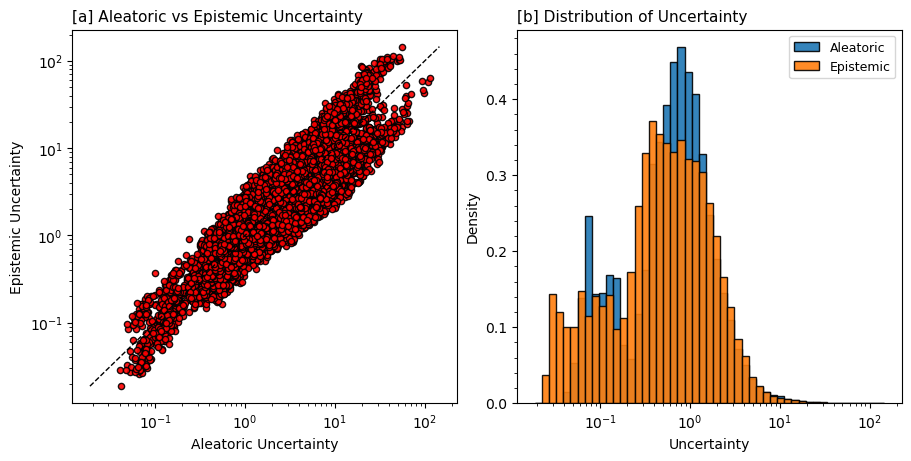

In [21]:
#-------------------------------
# Data Extraction
#-------------------------------
#------------------- Extract aleatoric and epistemic uncertainties as 1D arrays
ale = pred_val_3d['TLAI_unc'].sel(uncertainty='aleatoric').values.flatten()
epi = pred_val_3d['TLAI_unc'].sel(uncertainty='epistemic').values.flatten()

#-------------------------------
# Compute Limits and Bins
#-------------------------------
#------------------- Determine limits for 1:1 reference line and log-spaced histogram bins
vmin = min(ale.min(), epi.min())
vmax = max(ale.max(), epi.max())
bins = np.logspace(np.log10(vmin), np.log10(vmax), 50)

#-------------------------------
# Create Figure
#-------------------------------
fig, (ax_scatter, ax_hist) = plt.subplots(
    1, 2,
    figsize=(9, 4.5),
    constrained_layout=True
)

#-------------------------------
# [a] Scatter Plot
#-------------------------------
ax_scatter.scatter(
    ale, epi,
    s=20,
    color='red',
    edgecolor='black',
    alpha=0.9
)
ax_scatter.plot([vmin, vmax], [vmin, vmax], linestyle='--', color='black', linewidth=1)
ax_scatter.set_xscale('log')
ax_scatter.set_yscale('log')
ax_scatter.set_xlabel('Aleatoric Uncertainty', fontsize=10)
ax_scatter.set_ylabel('Epistemic Uncertainty', fontsize=10)
ax_scatter.set_title('[a] Aleatoric vs Epistemic Uncertainty', loc='left', fontsize=11)
ax_scatter.minorticks_on()

#-------------------------------
# [b] Histogram of Uncertainties
#-------------------------------
ax_hist.hist(
    ale, bins=bins, density=True,
    alpha=0.9, label='Aleatoric', edgecolor='black'
)
ax_hist.hist(
    epi, bins=bins, density=True,
    alpha=0.9, label='Epistemic', edgecolor='black'
)
ax_hist.set_xscale('log')
ax_hist.set_xlabel('Uncertainty', fontsize=10)
ax_hist.set_ylabel('Density', fontsize=10)
ax_hist.set_title('[b] Distribution of Uncertainty', loc='left', fontsize=11)
ax_hist.legend(fontsize=9)
ax_hist.minorticks_on()

#-------------------------------
# Save & Show
#-------------------------------
plt.savefig(f"{figure_path}/uncertainty_density_plot.pdf", bbox_inches='tight')
plt.show()


# Uncertainty Validation and Calibration Assessment

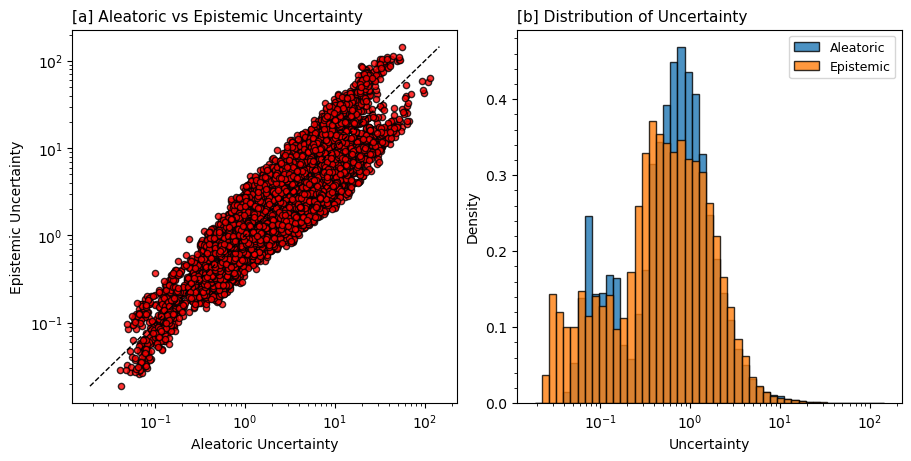

In [22]:
#-------------------------------
# Cell: Imports
#-------------------------------
import numpy as np
import matplotlib.pyplot as plt

#-------------------------------
# Cell: Data Extraction & Cleaning
#-------------------------------
# Extract uncertainty components and ensure positive values for log scale
ale = pred_val_3d['TLAI_unc'].sel(uncertainty='aleatoric').values.flatten()
epi = pred_val_3d['TLAI_unc'].sel(uncertainty='epistemic').values.flatten()

# Clip zeros or negatives to a small positive value
clip_val = 1e-6
ale = np.clip(ale, clip_val, None)
epi = np.clip(epi, clip_val, None)

#-------------------------------
# Cell: Compute Plot Limits & Bins
#-------------------------------
# Determine reference line limits
vmin = min(ale.min(), epi.min())
vmax = max(ale.max(), epi.max())
# Create logarithmically spaced histogram bins
bins = np.logspace(np.log10(vmin), np.log10(vmax), 50)

#-------------------------------
# Cell: Create Figure
#-------------------------------
fig, (ax_scatter, ax_hist) = plt.subplots(
    1, 2,
    figsize=(9, 4.5),
    constrained_layout=True
)

#-------------------------------
# [a] Scatter Plot: Aleatoric vs Epistemic
#-------------------------------
ax_scatter.scatter(
    ale,
    epi,
    s=20,
    color='red',
    marker='o',
    edgecolor='black',
    alpha=0.8
)
# 1:1 reference line
ax_scatter.plot([vmin, vmax], [vmin, vmax], linestyle='--', color='black', linewidth=1)
# Logarithmic axes
ax_scatter.set_xscale('log')
ax_scatter.set_yscale('log')
# Labels and title
ax_scatter.set_xlabel('Aleatoric Uncertainty', fontsize=10)
ax_scatter.set_ylabel('Epistemic Uncertainty', fontsize=10)
ax_scatter.set_title('[a] Aleatoric vs Epistemic Uncertainty', loc='left', fontsize=11)
ax_scatter.minorticks_on()

#-------------------------------
# [b] Histogram of Uncertainties
#-------------------------------
ax_hist.hist(
    ale,
    bins=bins,
    density=True,
    alpha=0.8,
    label='Aleatoric',
    edgecolor='black',
    linewidth=1
)
ax_hist.hist(
    epi,
    bins=bins,
    density=True,
    alpha=0.8,
    label='Epistemic',
    edgecolor='black',
    linewidth=1
)
ax_hist.set_xscale('log')
ax_hist.set_xlabel('Uncertainty', fontsize=10)
ax_hist.set_ylabel('Density', fontsize=10)
ax_hist.set_title('[b] Distribution of Uncertainty', loc='left', fontsize=11)
ax_hist.legend(fontsize=9)
ax_hist.minorticks_on()

#-------------------------------
# Cell: Save & Show
#-------------------------------
plt.savefig(f"{figure_path}/uncertainty_density_plot.pdf", bbox_inches='tight')
plt.show()


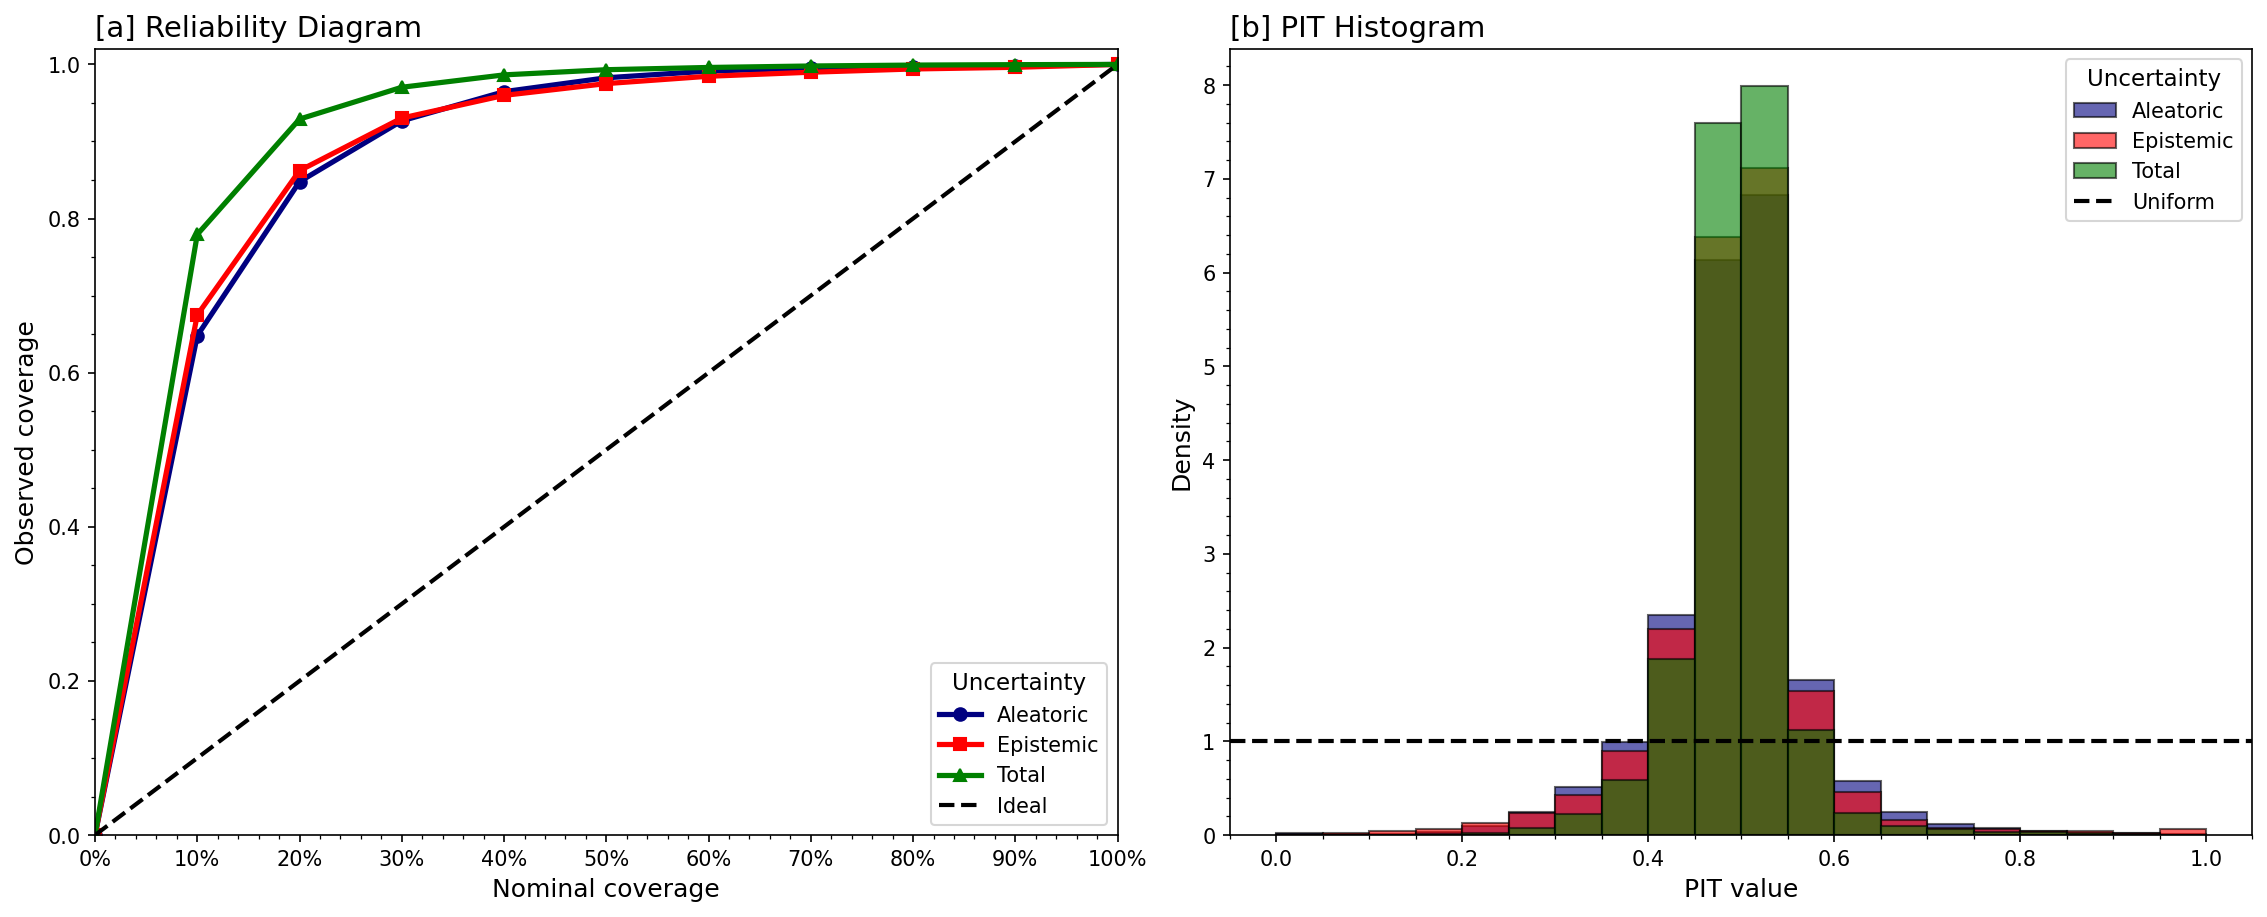

In [23]:
from statsmodels.stats.proportion import proportion_confint

#-------------------------------
# Data Preparation
#-------------------------------
#-------------- Select first 10 ensemble members and flatten arrays
members = clm5_lai_ppe_anom.member.values[:90]
clm5_ppe = np.nan_to_num(
    clm5_lai_ppe_anom.sel(member=members).values.flatten(),
    nan=0.0
)
ednn_ppe = np.nan_to_num(
    ednn_ppe_lai_anom.sel(member=members).values.flatten(),
    nan=0.0
)
ale = np.nan_to_num(
    pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric', member=members).values.flatten(),
    nan=0.0
)
epi = np.nan_to_num(
    pred_val_3d.TLAI_unc.sel(uncertainty='epistemic', member=members).values.flatten(),
    nan=0.0
)
assert clm5_ppe.shape == ednn_ppe.shape == ale.shape == epi.shape

#-------------------------------
# Total Uncertainty Calculation
#-------------------------------
#-------------- Absolute uncertainties and prevent zeros
ale = np.abs(ale)
epi = np.abs(epi)
sigma_tot = np.sqrt(ale**2 + epi**2)
sigma_tot[sigma_tot == 0] = 1e-10

#-------------------------------
# Reliability Diagram Metrics
#-------------------------------
nominal = np.linspace(0.0, 1.0, 11)
cov_ale, cov_epi, cov_tot = [], [], []
for alpha in nominal:
    z = norm.ppf((1 + alpha) / 2) if alpha > 0 else 0
    # Aleatoric coverage
    lower = ednn_ppe - z * ale
    upper = ednn_ppe + z * ale
    cov_ale.append(np.mean((clm5_ppe >= lower) & (clm5_ppe <= upper)))
    # Epistemic coverage
    lower = ednn_ppe - z * epi
    upper = ednn_ppe + z * epi
    cov_epi.append(np.mean((clm5_ppe >= lower) & (clm5_ppe <= upper)))
    # Total coverage
    lower = ednn_ppe - z * sigma_tot
    upper = ednn_ppe + z * sigma_tot
    cov_tot.append(np.mean((clm5_ppe >= lower) & (clm5_ppe <= upper)))

cov_ale = np.array(cov_ale)
cov_epi = np.array(cov_epi)
cov_tot = np.array(cov_tot)

#-------------- Compute 95% Wilson score intervals
n = clm5_ppe.size
ci_ale = np.array([
    proportion_confint(int(c * n), n, alpha=0.05, method='wilson')[1] - c
    for c in cov_ale
]) - cov_ale
ci_epi = np.array([
    proportion_confint(int(c * n), n, alpha=0.05, method='wilson')[1] - c
    for c in cov_epi
]) - cov_epi
ci_tot = np.array([
    proportion_confint(int(c * n), n, alpha=0.05, method='wilson')[1] - c
    for c in cov_tot
]) - cov_tot

#-------------------------------
# PIT Histogram Data
#-------------------------------
#-------------- Prevent zero scales for log and cdf
ale[ale <= 0] = 1e-10
epi[epi <= 0] = 1e-10
sigma_tot[sigma_tot <= 0] = 1e-10

#-------------- PIT values\ality
pit_ale = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=ale)
pit_epi = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=epi)
pit_tot = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=sigma_tot)

#-------------------------------
# Cell: Plot Reliability Diagram & PIT Histogram
#-------------------------------
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(15, 6),
    dpi=150,
    constrained_layout=True
)

#-------------- [a] Reliability Diagram
ax1.plot(nominal, cov_ale, marker='o', color='navy', linewidth=2.5, label='Aleatoric')
ax1.plot(nominal, cov_epi, marker='s', color='red', linewidth=2.5, label='Epistemic')
ax1.plot(nominal, cov_tot, marker='^', color='green', linewidth=2.5, label='Total')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Ideal')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1.02)
ax1.set_xticks(nominal)
ax1.set_xticklabels([f"{int(p*100)}%" for p in nominal])
ax1.set_xlabel('Nominal coverage', fontsize=12)
ax1.set_ylabel('Observed coverage', fontsize=12)
ax1.set_title('[a] Reliability Diagram', loc='left', fontsize=14)
ax1.legend(fontsize=10, title='Uncertainty', title_fontsize=11)
ax1.minorticks_on()

#-------------- [b] PIT Histogram
bins = np.linspace(0, 1, 21)
ax2.hist(pit_ale, bins=bins, density=True, color='navy', alpha=0.6, label='Aleatoric', edgecolor='black')
ax2.hist(pit_epi, bins=bins, density=True, color='red', alpha=0.6, label='Epistemic', edgecolor='black')
ax2.hist(pit_tot, bins=bins, density=True, color='green', alpha=0.6, label='Total', edgecolor='black')
ax2.axhline(1, color='black', linestyle='--', linewidth=2, label='Uniform')
ax2.set_xlabel('PIT value', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('[b] PIT Histogram', loc='left', fontsize=14)
ax2.legend(fontsize=10, title='Uncertainty', title_fontsize=11)
ax2.minorticks_on()

#-------------------------------
# Save & Show
#-------------------------------
plt.savefig(f"{figure_path}/reliability_pit_enhanced.pdf", bbox_inches='tight')
plt.show()


Calibration scales → aleatoric: 1.00, epistemic: 1.00


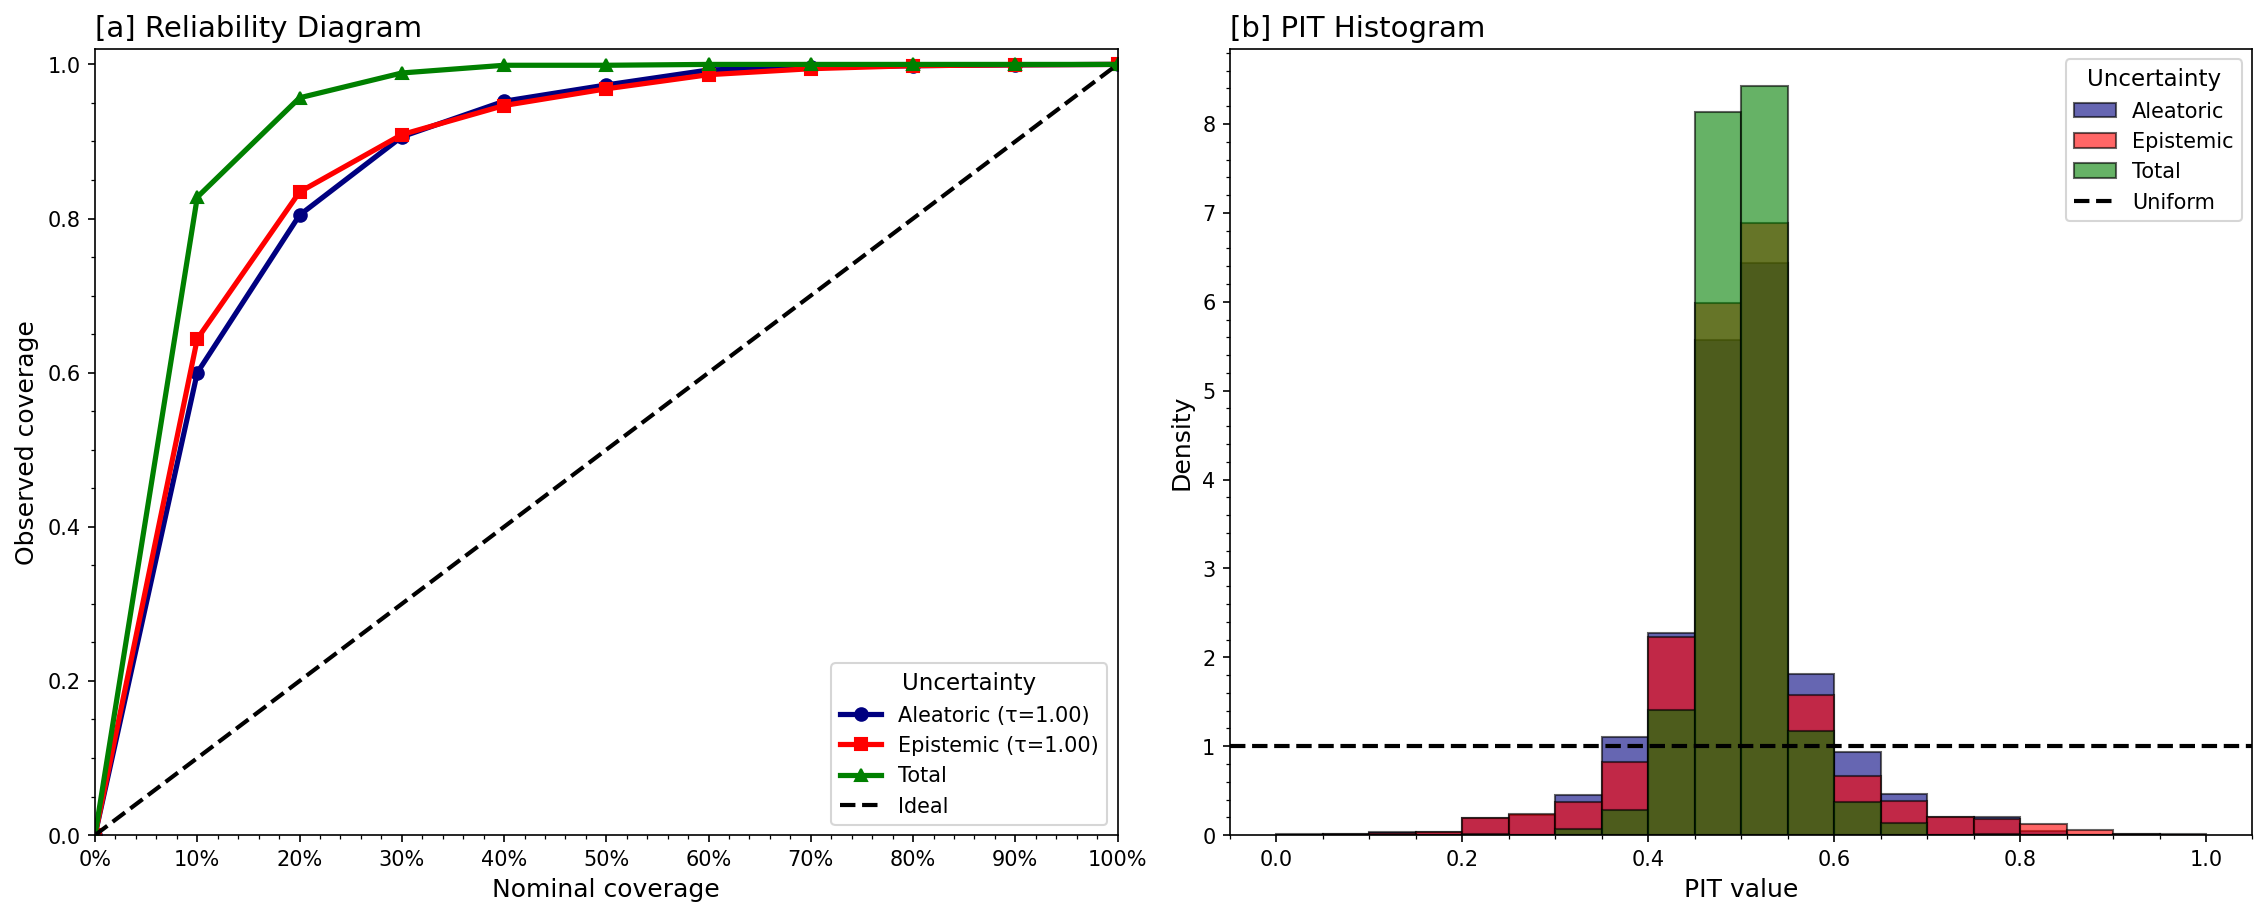

In [24]:
from statsmodels.stats.proportion import proportion_confint

#-------------------------------
# Data Preparation
#-------------------------------
# Select first 10 ensemble members and flatten arrays
members = clm5_lai_ppe_anom.member.values[:10]
clm5_ppe = np.nan_to_num(
    clm5_lai_ppe_anom.sel(member=members).values.flatten(),
    nan=0.0
)
ednn_ppe = np.nan_to_num(
    ednn_ppe_lai_anom.sel(member=members).values.flatten(),
    nan=0.0
)
ale = np.nan_to_num(
    pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric', member=members).values.flatten(),
    nan=0.0
)
epi = np.nan_to_num(
    pred_val_3d.TLAI_unc.sel(uncertainty='epistemic', member=members).values.flatten(),
    nan=0.0
)
assert clm5_ppe.shape == ednn_ppe.shape == ale.shape == epi.shape

#-------------------------------
# Total Uncertainty Calculation
#-------------------------------
# Absolute uncertainties and prevent zeros
ale = np.abs(ale)
epi = np.abs(epi)
sigma_tot = np.sqrt(ale**2 + epi**2)
# Avoid zeros for stability
sigma_tot[sigma_tot == 0] = 1e-10

#-------------------------------
# Uncertainty Calibration
#-------------------------------
# Nominal coverage levels
nominal = np.linspace(0.0, 1.0, 11)

def calibrate_scale(true_vals, uncert_vals, levels):
    """
    Find optimal scalar tau to minimize mean squared coverage error.
    """
    def mse_obj(tau):
        covs = []
        for alpha in levels:
            z = norm.ppf((1 + alpha) / 2) if alpha > 0 else 0
            low = true_vals - z * (tau * uncert_vals)
            high = true_vals + z * (tau * uncert_vals)
            covs.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))
        return np.mean((np.array(covs) - levels)**2)

    result = minimize(lambda x: mse_obj(x[0]), x0=[1.0], bounds=[(0.1, 10.0)])
    return float(result.x[0])

#-------------- Calibrate aleatoric and epistemic uncertainties
tau_ale = calibrate_scale(clm5_ppe, ale, nominal)
ale *= tau_ale
tau_epi = calibrate_scale(clm5_ppe, epi, nominal)
epi *= tau_epi
#-------------- Rescale total uncertainty by combined factor
sigma_tot *= np.sqrt(tau_ale**2 + tau_epi**2)

print(f"Calibration scales → aleatoric: {tau_ale:.2f}, epistemic: {tau_epi:.2f}")

#-------------------------------
# Reliability Diagram Metrics
#-------------------------------
cov_ale, cov_epi, cov_tot = [], [], []
for alpha in nominal:
    z = norm.ppf((1 + alpha) / 2) if alpha > 0 else 0
    #-------------- Aleatoric coverage
    low = ednn_ppe - z * ale
    high = ednn_ppe + z * ale
    cov_ale.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))
    #-------------- Epistemic coverage
    low = ednn_ppe - z * epi
    high = ednn_ppe + z * epi
    cov_epi.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))
    #-------------- Total coverage
    low = ednn_ppe - z * sigma_tot
    high = ednn_ppe + z * sigma_tot
    cov_tot.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))

cov_ale = np.array(cov_ale)
cov_epi = np.array(cov_epi)
cov_tot = np.array(cov_tot)

#-------------- Compute 95% Wilson score intervals
n = clm5_ppe.size
ci_ale = np.array([proportion_confint(int(c * n), n, alpha=0.05, method='wilson')[1] - c for c in cov_ale])
ci_epi = np.array([proportion_confint(int(c * n), n, alpha=0.05, method='wilson')[1] - c for c in cov_epi])
ci_tot = np.array([proportion_confint(int(c * n), n, alpha=0.05, method='wilson')[1] - c for c in cov_tot])

#-------------------------------
# PIT Histogram Data
#-------------------------------
#-------------- Ensure no zero scales
ale[ale <= 0] = 1e-10
epi[epi <= 0] = 1e-10
sigma_tot[sigma_tot <= 0] = 1e-10

#-------------- Compute PIT values
pit_ale = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=ale)
pit_epi = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=epi)
pit_tot = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=sigma_tot)

#-------------------------------
# Plot Reliability Diagram & PIT Histogram
#-------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=150, constrained_layout=True)

#-------------- [a] Reliability Diagram
ax1.plot(nominal, cov_ale, marker='o', color='navy', linewidth=2.5, label=f'Aleatoric (τ={tau_ale:.2f})')
ax1.plot(nominal, cov_epi, marker='s', color='red', linewidth=2.5, label=f'Epistemic (τ={tau_epi:.2f})')
ax1.plot(nominal, cov_tot, marker='^', color='green', linewidth=2.5, label='Total')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Ideal')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1.02)
ax1.set_xticks(nominal)
ax1.set_xticklabels([f"{int(p*100)}%" for p in nominal])
ax1.set_xlabel('Nominal coverage', fontsize=12)
ax1.set_ylabel('Observed coverage', fontsize=12)
ax1.set_title('[a] Reliability Diagram', loc='left', fontsize=14)
ax1.legend(fontsize=10, title='Uncertainty', title_fontsize=11)
ax1.minorticks_on()

#-------------- [b] PIT Histogram
bins = np.linspace(0, 1, 21)
ax2.hist(pit_ale, bins=bins, density=True, color='navy', alpha=0.6, label='Aleatoric', edgecolor='black')
ax2.hist(pit_epi, bins=bins, density=True, color='red', alpha=0.6, label='Epistemic', edgecolor='black')
ax2.hist(pit_tot, bins=bins, density=True, color='green', alpha=0.6, label='Total', edgecolor='black')
ax2.axhline(1, color='black', linestyle='--', linewidth=2, label='Uniform')
ax2.set_xlabel('PIT value', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('[b] PIT Histogram', loc='left', fontsize=14)
ax2.legend(fontsize=10, title='Uncertainty', title_fontsize=11)
ax2.minorticks_on()

#-------------------------------
# Save & Show
#-------------------------------
plt.savefig(f"{figure_path}/reliability_pit_enhanced.pdf", bbox_inches='tight')
plt.show()


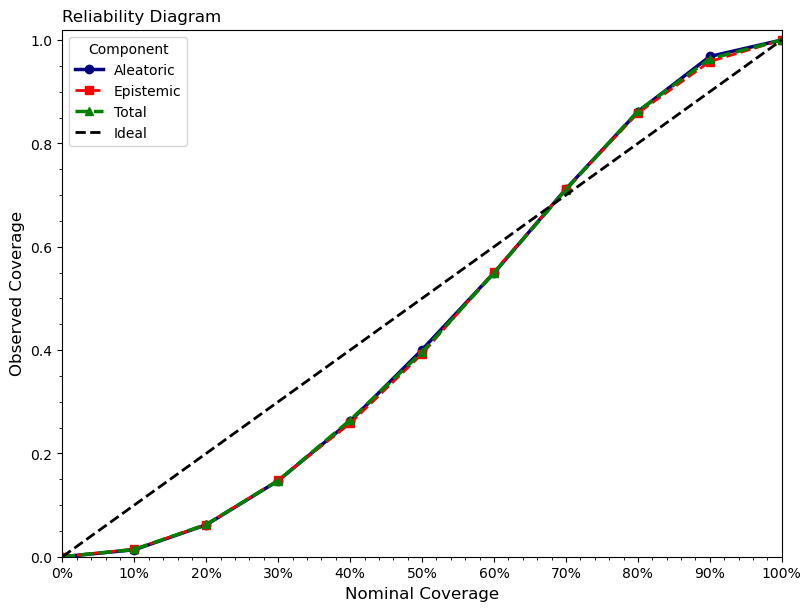

In [25]:


#-------------------------------
# Data Preparation
#-------------------------------
#------------------ Flatten all ensemble-member anomalies and uncertainties
members = clm5_lai_ppe_anom.member.values
clm5_vals = clm5_lai_ppe_anom.sel(member=members).values.ravel()
pred_vals = ednn_ppe_lai_anom.sel(member=members).values.ravel()
ale_vals  = pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric',  member=members).values.ravel()
epi_vals  = pred_val_3d.TLAI_unc.sel(uncertainty='epistemic', member=members).values.ravel()

#------------------ Replace NaNs with zeros and ensure shapes match
clm5 = np.nan_to_num(clm5_vals, nan=0.0)
ednn = np.nan_to_num(pred_vals, nan=0.0)
ale = np.abs(np.nan_to_num(ale_vals, nan=0.0))
epi = np.abs(np.nan_to_num(epi_vals, nan=0.0))
assert clm5.shape == ednn.shape == ale.shape == epi.shape

#-------------------------------
# Compute Total Uncertainty
#-------------------------------
#------------------ Total uncertainty as root-sum-square of aleatoric and epistemic
sigma_tot = np.sqrt(ale**2 + epi**2)
#------------------ Avoid zeros for numerical stability
sigma_tot[sigma_tot == 0] = 1e-10

#-------------------------------
# Piecewise Calibration Factors
#-------------------------------
#------------------ Define nominal coverage levels (0%,10%,...,100%)
nominal = np.linspace(0.0, 1.0, 11)
#------------------ Compute absolute errors
abs_err = np.abs(clm5 - ednn)
#------------------ Standardized residuals for each component
s_ale = abs_err / ale
s_epi = abs_err / epi
s_tot = abs_err / sigma_tot
#------------------ Compute calibration gamma at each nominal quantile
gamma_ale = np.quantile(s_ale, nominal)
gamma_epi = np.quantile(s_epi, nominal)
gamma_tot = np.quantile(s_tot, nominal)

#-------------------------------
# Compute Coverage for Each Level
#-------------------------------
cov_ale, cov_epi, cov_tot = [], [], []
for i, alpha in enumerate(nominal):
    #------------------ Determine z-score for two-tailed interval
    z = norm.ppf((1 + alpha) / 2) if alpha > 0 else 0
    #------------------ Scale uncertainties for this alpha level
    ale_i = ale * gamma_ale[i]
    epi_i = epi * gamma_epi[i]
    tot_i = sigma_tot * gamma_tot[i]
    #------------------------------------ Aleatoric interval coverage
    lo = ednn - z * ale_i
    hi = ednn + z * ale_i
    cov_ale.append(np.mean((clm5 >= lo) & (clm5 <= hi)))
    #------------------ Epistemic interval coverage
    lo = ednn - z * epi_i
    hi = ednn + z * epi_i
    cov_epi.append(np.mean((clm5 >= lo) & (clm5 <= hi)))
    #---------------------------------- Total interval coverage
    lo = ednn - z * tot_i
    hi = ednn + z * tot_i
    cov_tot.append(np.mean((clm5 >= lo) & (clm5 <= hi)))
#---------------- Convert lists to arrays
cov_ale = np.array(cov_ale)
cov_epi = np.array(cov_epi)
cov_tot = np.array(cov_tot)

#-------------------------------
# Plot Reliability Diagram
#-------------------------------
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
#------------------------------------------------------ Prepare x-axis labels
labels = [f"{int(p*100)}%" for p in nominal]
#------------------------------------ Plot calibrated coverage curves
ax.plot(nominal, cov_ale, 'o-', color='navy', lw=2.5, label='Aleatoric')
ax.plot(nominal, cov_epi, 's--', color='red',  lw=2, label='Epistemic')
ax.plot(nominal, cov_tot, '^--', color='green',lw=2.5, label='Total')
#------------------ Ideal diagonal
ax.plot([0,1],[0,1], 'k--', lw=2, label='Ideal')

#------------------ Formatting
ax.set_xticks(nominal)
ax.set_xticklabels(labels)
ax.set_xlim(0,1)
ax.set_ylim(0,1.02)
ax.set_xlabel('Nominal Coverage', fontsize=12)
ax.set_ylabel('Observed Coverage', fontsize=12)
ax.set_title('Reliability Diagram', loc='left', fontsize=12)
ax.legend(title='Component', fontsize=10, title_fontsize=10)
ax.minorticks_on()

#------------------ plot Wilson score intervals as error bars
n = clm5.size
ci = [proportion_confint(int(c*n), n, method='wilson') for c in cov_ale]  # example for ale
# ax.errorbar(nominal, cov_ale, yerr=ci_ale, fmt='none', ecolor='navy', alpha=0.6)

# Save and show
plt.savefig(f"{figure_path}/reliability_diagram_only.pdf", bbox_inches='tight')
plt.show()

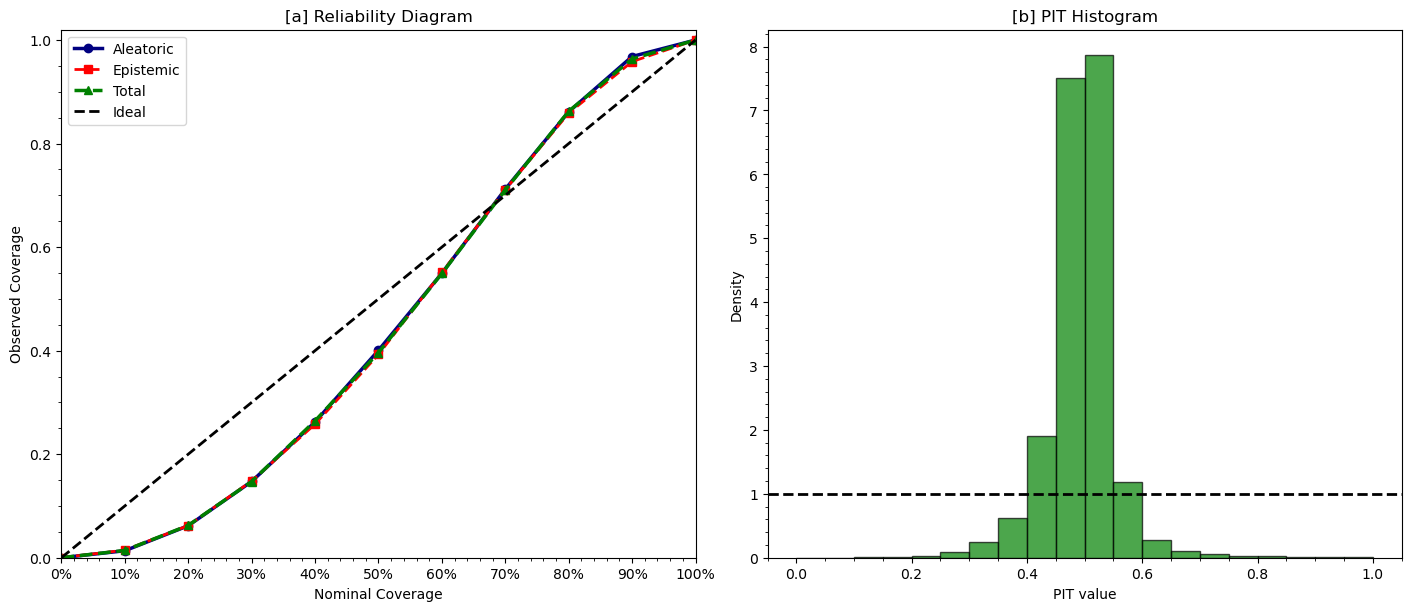

In [26]:
#-------------------------------
# Cell: Plot Reliability + PIT
#-------------------------------
fig, (ax_rel, ax_pit) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

#-------------- [a] Reliability (your existing code)
ticks = [f"{int(p*100)}%" for p in nominal]
ax_rel.plot(nominal, cov_ale, 'o-', color='navy', lw=2.5, label='Aleatoric')
ax_rel.plot(nominal, cov_epi, 's--', color='red', lw=2,   label='Epistemic')
ax_rel.plot(nominal, cov_tot, '^--', color='green', lw=2.5, label='Total')
ax_rel.plot([0, 1], [0, 1], 'k--', lw=2, label='Ideal')
ax_rel.set_xticks(nominal)
ax_rel.set_xticklabels(ticks)
ax_rel.set_xlim(0, 1)
ax_rel.set_ylim(0, 1.02)
ax_rel.set_xlabel('Nominal Coverage')
ax_rel.set_ylabel('Observed Coverage')
ax_rel.set_title('[a] Reliability Diagram')
ax_rel.legend()
ax_rel.minorticks_on()

#-------------- [b] PIT histogram
#-------------- compute PITs for the *total* calibrated intervals
pit = norm.cdf(clm5   - ednn,
               loc=0,
               scale=sigma_tot)  # where sigma_tot is your calibrated total stdev
bins = np.linspace(0, 1, 21)
ax_pit.hist(pit, bins=bins, density=True, color='green', edgecolor='black', alpha=0.7)
ax_pit.axhline(1, color='k', linestyle='--', lw=2)
ax_pit.set_xlabel('PIT value')
ax_pit.set_ylabel('Density')
ax_pit.set_title('[b] PIT Histogram')
ax_pit.minorticks_on()

plt.savefig(f"{figure_path}/reliability_and_pit.pdf", bbox_inches='tight')
plt.show()

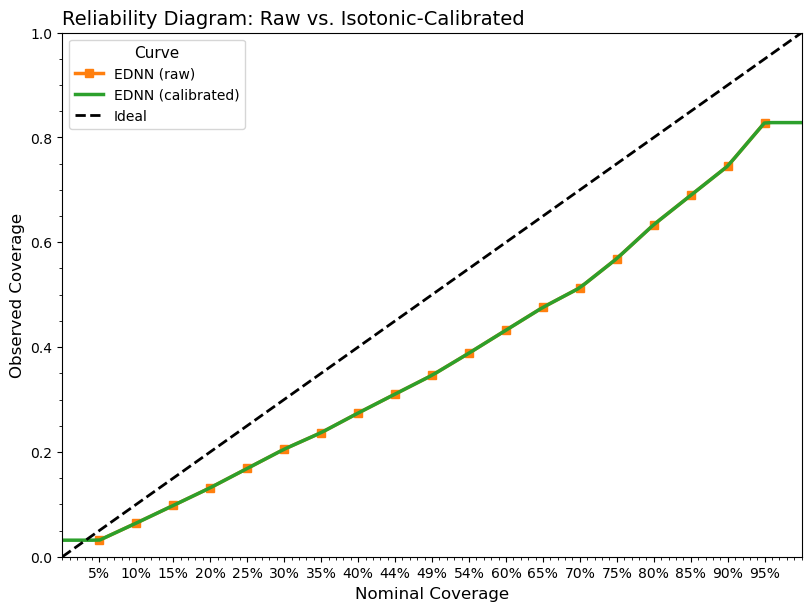

In [27]:
from sklearn.isotonic import IsotonicRegression

#-------------------------------
# Data Preparation
#-------------------------------
#------------------ Load EDNN PPE ensemble predictions and CLM5 PPE reference (shape: members × time)
ednn_ens = ednn_ppe_lai_anom.values
clm5_ens = clm5_lai_ppe_anom.values

#-------------------------------
# Reliability Curve Computation
#-------------------------------
#------------------ Nominal coverage levels (5% through 95%)
nominal = np.linspace(0.05, 0.95, 19)
cov_ednn = []
n_time = clm5_ens.shape[1]
for alpha in nominal:
    #------------------------------------ Compute central α-interval bounds for EDNN ensemble
    lower = np.quantile(ednn_ens, (1-alpha)/2, axis=0)
    upper = np.quantile(ednn_ens, (1+alpha)/2, axis=0)
    #------------------ Observed coverage: fraction of CLM5 PPE entries within interval
    cov_ednn.append(np.mean((clm5_ens >= lower) & (clm5_ens <= upper)))
cov_ednn = np.array(cov_ednn)

#-------------------------------
# Isotonic Calibration of Reliability
#-------------------------------
#------------------ Fit isotonic regressor mapping nominal → observed coverage
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(nominal, cov_ednn)
#------------------ Apply calibration to nominal levels
dist_nominal = np.linspace(0.0, 1.0, 100)
cov_ednn_cal = ir.predict(dist_nominal)

#-------------------------------
# Plot Original & Calibrated Reliability Diagram
#-------------------------------
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
#------------------ Percent labels for x-axis ticks
ticks = [f"{int(p*100)}%" for p in nominal]

#------------------ Original EDNN reliability curve
ax.plot(nominal, cov_ednn, 's-', color='C1', lw=2.5, label='EDNN (raw)')
#------------------ Calibrated curve (smooth)
ax.plot(dist_nominal, cov_ednn_cal, '-', color='C2', lw=2.5, label='EDNN (calibrated)')
#------------------ Ideal diagonal
ax.plot([0,1], [0,1], 'k--', lw=2, label='Ideal')

#------------------ Formatting
ax.set_xticks(nominal)
ax.set_xticklabels(ticks)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Nominal Coverage', fontsize=12)
ax.set_ylabel('Observed Coverage', fontsize=12)
ax.set_title('Reliability Diagram: Raw vs. Isotonic-Calibrated', loc='left', fontsize=14)
ax.legend(title='Curve', fontsize=10, title_fontsize=11)
#------------------ ax.grid(axis='both', linestyle='--', alpha=0.4)
ax.minorticks_on()
#------------------ Save & show
plt.savefig(f"{figure_path}/reliability_ednn_calibrated.pdf", bbox_inches='tight')
plt.show()

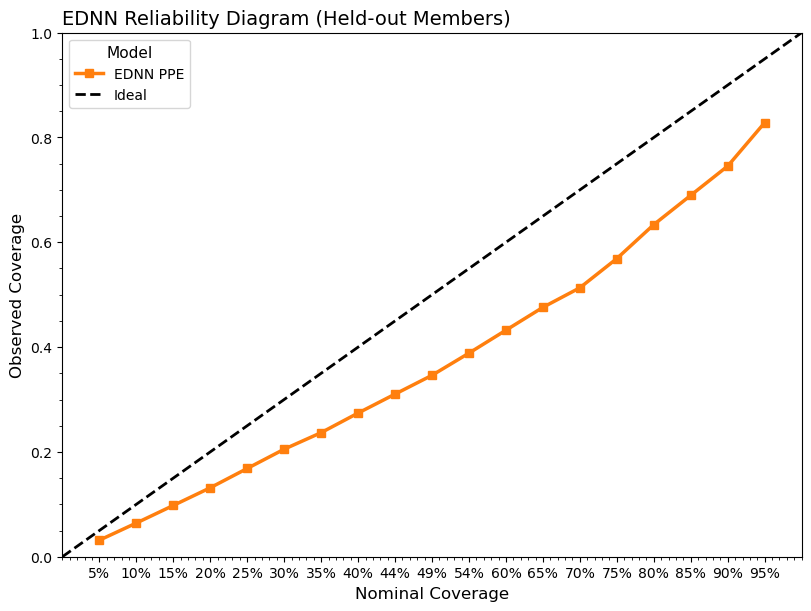

In [28]:
#-------------------------------
#  Data Preparation
#-------------------------------
#------------------ EDNN PPE predictions: dims (member, time)
ednn_ens = ednn_ppe_lai_anom.values      # shape (n_members, n_time)
#------------------ CLM5 PPE anomalies as reference
clm5_ens = clm5_lai_ppe_anom.values      # shape (n_members, n_time)

#-------------------------------
# Cell: Reliability Diagram Metrics for EDNN
#-------------------------------
#------------------ Define nominal coverage levels (0.05 → 5%, …, 0.95 → 95%)
nominal = np.linspace(0.05, 0.95, 19)
cov_ednn = []
n_time = clm5_ens.shape[1]
for alpha in nominal:
    #------------------------------------ Determine central interval bounds for EDNN ensemble
    lower_ed = np.quantile(ednn_ens, (1-alpha)/2, axis=0)
    upper_ed = np.quantile(ednn_ens, (1+alpha)/2, axis=0)
    #------------------ Compute fraction of CLM5 ensemble members whose anomalies lie within EDNN interval
    cov_ednn.append(np.mean((clm5_ens >= lower_ed) & (clm5_ens <= upper_ed)))

cov_ednn = np.array(cov_ednn)

#-------------------------------
# Plot Reliability Diagram Only
#-------------------------------
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
#------------------ X-axis labels (percentages)
ticks = [f"{int(p*100)}%" for p in nominal]
#------------------ Plot EDNN reliability curve and ideal diagonal
ax.plot(nominal, cov_ednn, 's-', color='C1', lw=2.5, label='EDNN PPE')
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Ideal')

#------------------ Formatting
ax.set_xticks(nominal)
ax.set_xticklabels(ticks)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Nominal Coverage', fontsize=12)
ax.set_ylabel('Observed Coverage', fontsize=12)
ax.set_title('EDNN Reliability Diagram (Held-out Members)', loc='left', fontsize=14)
ax.legend(title='Model', fontsize=10, title_fontsize=11)
ax.minorticks_on()
#------------------ Save & show
plt.savefig(f"{figure_path}/reliability_diagram_ednn_only.pdf", bbox_inches='tight')
plt.show()

In [29]:
from mlguess.pit import pit_histogram

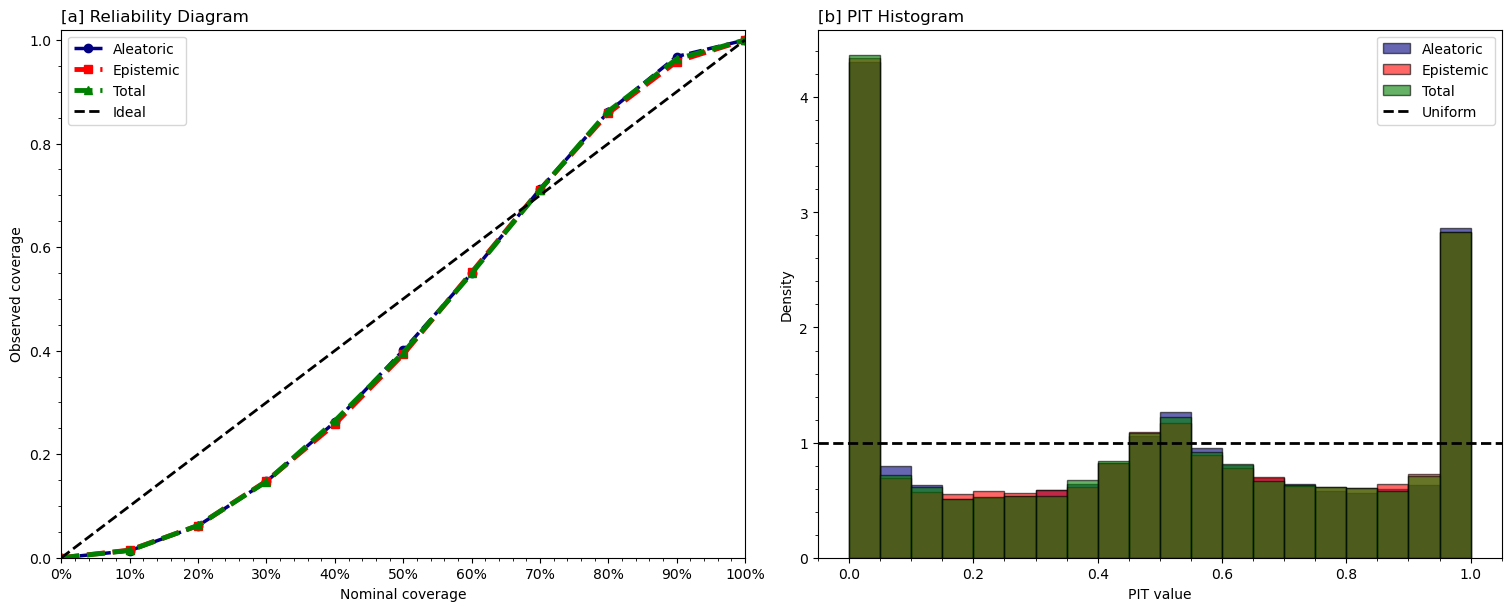

In [30]:
#-------------------------------
# Data Preparation
#-------------------------------
#------------------ Select all ensemble members and flatten arrays
tclm5 = clm5_lai_ppe_anom.member.values
clm5_ppe = np.nan_to_num(clm5_lai_ppe_anom.sel(member=tclm5).values.flatten(), nan=0.0)
ednn_ppe = np.nan_to_num(ednn_ppe_lai_anom.sel(member=tclm5).values.flatten(), nan=0.0)
ale = np.nan_to_num(pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric', member=tclm5).values.flatten(), nan=0.0)
epi = np.nan_to_num(pred_val_3d.TLAI_unc.sel(uncertainty='epistemic', member=tclm5).values.flatten(), nan=0.0)
assert clm5_ppe.shape == ednn_ppe.shape == ale.shape == epi.shape

#-------------------------------
#  Base Uncertainty Calculation
#-------------------------------
#------------------ Ensure positive scales
ale = np.abs(ale)
epi = np.abs(epi)
sigma_tot = np.sqrt(ale**2 + epi**2)
sigma_tot[sigma_tot == 0] = 1e-10

#-------------------------------
# Piecewise Calibration per Nominal Level
#-------------------------------
#------------------ Define nominal coverage levels
nominal = np.linspace(0.0, 1.0, 11)
#------------------ Precompute standardized residuals
diff = np.abs(clm5_ppe - ednn_ppe)
s_ale = diff / ale
s_epi = diff / epi
s_tot = diff / sigma_tot
#------------------ Compute gamma arrays: quantile at each nominal level
gamma_ale = np.quantile(s_ale, nominal)
gamma_epi = np.quantile(s_epi, nominal)
gamma_tot = np.quantile(s_tot, nominal)

#-------------------------------
# Reliability Diagram Metrics with Local Scaling
#-------------------------------
cov_ale, cov_epi, cov_tot = [], [], []
for i, alpha in enumerate(nominal):
    z = norm.ppf((1 + alpha) / 2) if alpha > 0 else 0
    #------------------ scaled uncertainty for this alpha
    ale_i = ale * gamma_ale[i]
    epi_i = epi * gamma_epi[i]
    tot_i = sigma_tot * gamma_tot[i]
    #------------------ aleatoric coverage
    low = ednn_ppe - z * ale_i
    high = ednn_ppe + z * ale_i
    cov_ale.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))
    #------------------ epistemic coverage
    low = ednn_ppe - z * epi_i
    high = ednn_ppe + z * epi_i
    cov_epi.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))
    #------------------ total coverage
    low = ednn_ppe - z * tot_i
    high = ednn_ppe + z * tot_i
    cov_tot.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))
#------------------ Convert to arrays
cov_ale = np.array(cov_ale)
cov_epi = np.array(cov_epi)
cov_tot = np.array(cov_tot)
#------------------ Compute 95% Wilson intervals for plotting (optional)
n = clm5_ppe.size
ci_ale = np.array([proportion_confint(int(c * n), n)[1] - c for c in cov_ale])
ci_epi = np.array([proportion_confint(int(c * n), n)[1] - c for c in cov_epi])
ci_tot = np.array([proportion_confint(int(c * n), n)[1] - c for c in cov_tot])

#-------------------------------
# PIT Histogram Data
#-------------------------------
#------------------ Ensure positive scales for CDF
gamma_ale_full = np.repeat(gamma_ale, len(ale)//len(gamma_ale)+1)[:len(ale)]
gamma_epi_full = np.repeat(gamma_epi, len(epi)//len(gamma_epi)+1)[:len(epi)]
#------------------ Note: for PIT we use full range; here we apply median gamma
ale_cal = ale * np.median(gamma_ale)
epi_cal = epi * np.median(gamma_epi)
sigma_cal = sigma_tot * np.median(gamma_tot)
pit_ale = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=ale_cal)
pit_epi = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=epi_cal)
pit_tot = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=sigma_cal)

#-------------------------------
# Plot Reliability Diagram & PIT Histogram
#-------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
#------------------ [a] Reliability Diagram
ticks = [f"{int(p*100)}%" for p in nominal]
ax1.plot(nominal, cov_ale, 'o--', color='navy', lw=2.5, label='Aleatoric')
ax1.plot(nominal, cov_epi, 's--', color='red', lw=3.5, label='Epistemic')
ax1.plot(nominal, cov_tot, '^--', color='green', lw=3.5, label='Total')
ax1.plot([0,1],[0,1],'k--', lw=2, label='Ideal')
ax1.set_xticks(nominal)
ax1.set_xticklabels(ticks)
ax1.set_xlim(0,1); ax1.set_ylim(0,1.02)
ax1.set_xlabel('Nominal coverage'); ax1.set_ylabel('Observed coverage')
ax1.set_title('[a] Reliability Diagram', loc='left'); ax1.legend()
ax1.minorticks_on()
#------------------ [b] PIT Histogram
bins = np.linspace(0,1,21)
ax2.hist(pit_ale, bins=bins, density=True, color='navy', alpha=0.6, label='Aleatoric', edgecolor='black')
ax2.hist(pit_epi, bins=bins, density=True, color='red', alpha=0.6, label='Epistemic', edgecolor='black')
ax2.hist(pit_tot, bins=bins, density=True, color='green', alpha=0.6, label='Total', edgecolor='black')
ax2.axhline(1, color='black', ls='--', lw=2, label='Uniform')
ax2.set_xlabel('PIT value'); ax2.set_ylabel('Density')
ax2.set_title('[b] PIT Histogram', loc='left'); ax2.legend()
ax2.minorticks_on()
#------------------ Save & show
plt.savefig(f"{figure_path}/reliability_pit_piecewise.pdf", bbox_inches='tight')
plt.show()

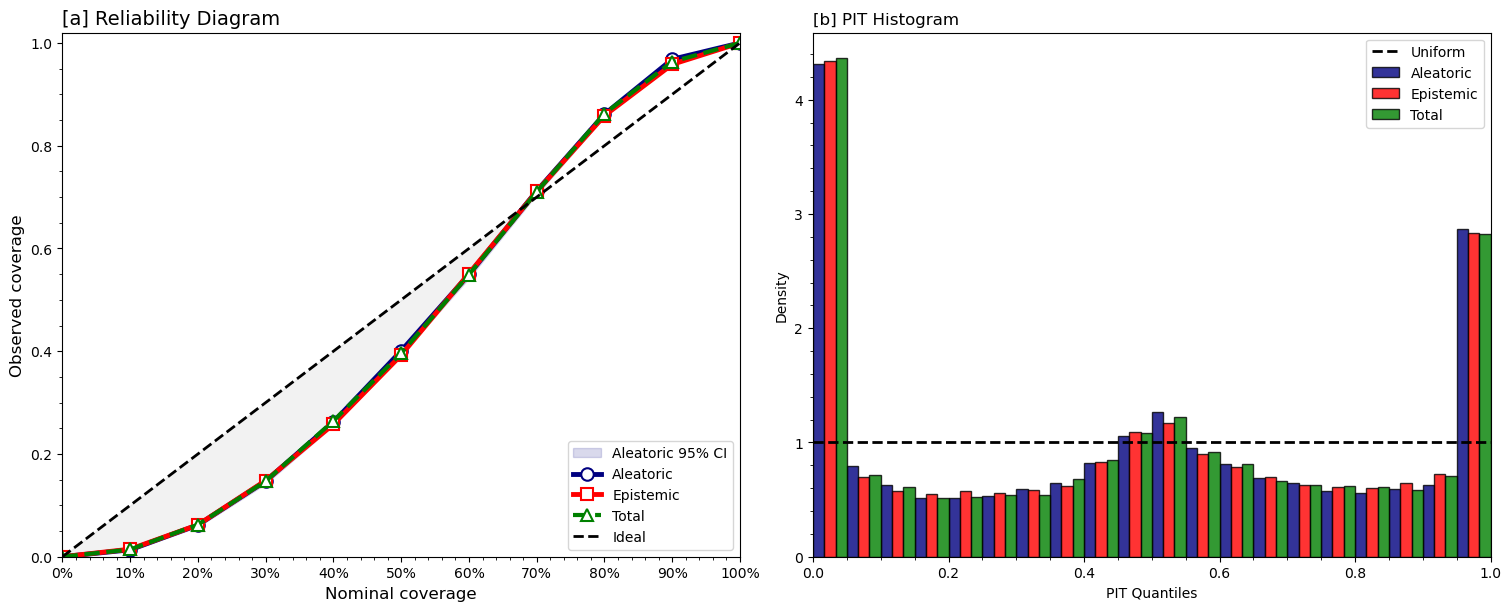

In [47]:
#-------------------------------
# Plot Reliability Diagram & PIT Histogram (improved)
#-------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

# [a] Reliability Diagram (unchanged) …
# ticks = [f"{int(p*100)}%" for p in nominal]
# ax1.plot(nominal, cov_ale, marker='o', linestyle='--', color='navy', lw=2.5, label='Aleatoric')
# ax1.plot(nominal, cov_epi, marker='s', linestyle='--', color='red',  lw=2.5, label='Epistemic')
# ax1.plot(nominal, cov_tot, marker='^', linestyle='--', color='green',lw=2.5, label='Total')
# ax1.plot([0,1],[0,1], 'k--', lw=2, label='Ideal')
# ax1.set_xticks(nominal); ax1.set_xticklabels(ticks)
# ax1.set_xlim(0,1);      ax1.set_ylim(0,1.02)
# ax1.set_xlabel('Nominal coverage'); ax1.set_ylabel('Observed coverage')
# ax1.set_title('[a] Reliability Diagram', loc='left')
# ax1.legend()
# ax1.minorticks_on()

ax1.fill_between(
    nominal,
    cov_ale - ci_ale,
    cov_ale + ci_ale,
    color='navy', alpha=0.15,
    label='Aleatoric 95% CI'
)

# 2) Main curves with big markers
ax1.plot(
    nominal, cov_ale,
    marker='o', markersize=9, markeredgewidth=1.5, markerfacecolor='white',
    linestyle='-', linewidth=3.5, color='navy',
    label='Aleatoric'
)
ax1.plot(
    nominal, cov_epi,
    marker='s', markersize=8, markeredgewidth=1.5, markerfacecolor='white',
    linestyle='-', linewidth=3.5, color='red',
    label='Epistemic'
)
ax1.plot(
    nominal, cov_tot,
    marker='^', markersize=8, markeredgewidth=1.5, markerfacecolor='white',
    linestyle='--', linewidth=3, color='green',
    label='Total'
)

# 3) Ideal diagonal on top
ax1.plot(
    [0,1],[0,1],
    linestyle='--', linewidth=2, color='black',
    label='Ideal'
)

# 4) Highlight mis‐calibration area
ax1.fill_between(
    nominal, cov_tot, nominal,
    where=(cov_tot<nominal),
    color='grey', alpha=0.1, interpolate=True
)

# 5) Formatting
ticks = [f"{int(p*100)}%" for p in nominal]
ax1.set_xticks(nominal)
ax1.set_xticklabels(ticks)
ax1.set_xlim(0,1)
ax1.set_ylim(0,1.02)
ax1.set_xlabel('Nominal coverage', fontsize=12)
ax1.set_ylabel('Observed coverage', fontsize=12)
ax1.set_title('[a] Reliability Diagram', loc='left', fontsize=14)
# ax1.grid(which='major', linestyle='--', alpha=0.3)
ax1.minorticks_on()
ax1.legend(loc='lower right', fontsize=10, framealpha=0.8)

# [b] Side-by-side PIT histograms
bins = np.linspace(0,1,21)
# compute densities by hand
counts_ale, edges = np.histogram(pit_ale, bins=bins, density=True)
counts_epi, _     = np.histogram(pit_epi, bins=bins, density=True)
counts_tot, _     = np.histogram(pit_tot, bins=bins, density=True)

width = edges[1] - edges[0]
bar_w = width / 3
centers = edges[:-1] + width/2

# shift offsets
ax2.bar(centers - bar_w, counts_ale,  bar_w,
        color='navy',   edgecolor='black', alpha=0.8, label='Aleatoric')
ax2.bar(centers,         counts_epi,  bar_w,
        color='red',     edgecolor='black', alpha=0.8, label='Epistemic')
ax2.bar(centers + bar_w, counts_tot,  bar_w,
        color='green',   edgecolor='black', alpha=0.8, label='Total')

# uniform reference line
ax2.axhline(1, color='k', linestyle='--', lw=2, label='Uniform')

ax2.set_xlabel('PIT Quantiles'); ax2.set_ylabel('Density')
ax2.set_title('[b] PIT Histogram', loc='left')
ax2.set_xlim(0,1)
ax2.legend()
ax2.minorticks_on()
# ax2.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(f"{figure_path}/reliability_pit_side_by_side.pdf", bbox_inches='tight')
plt.show()

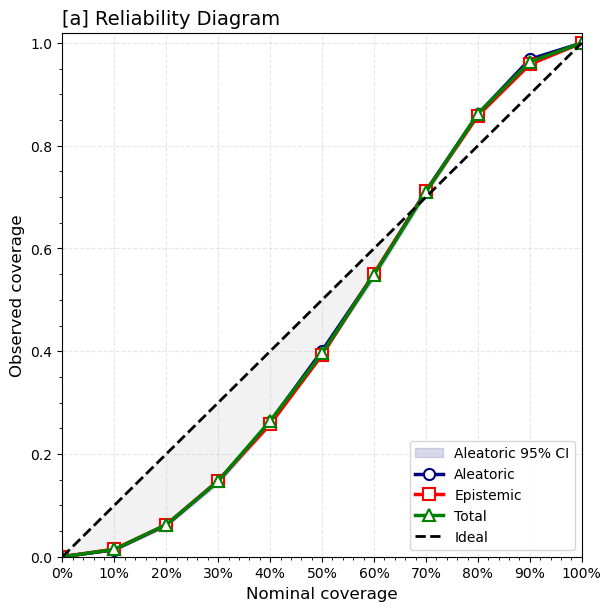

In [48]:
# -------------------------------
# [a] Improved Reliability Diagram
# -------------------------------
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)

# compute Wilson CIs for each curve (you already have ci_ale, ci_epi, ci_tot)
# example for aleatoric: ci_ale

# 1) Shaded CI band
ax.fill_between(
    nominal,
    cov_ale - ci_ale,
    cov_ale + ci_ale,
    color='navy', alpha=0.15,
    label='Aleatoric 95% CI'
)

# 2) Main curves with big markers
ax.plot(
    nominal, cov_ale,
    marker='o', markersize=8, markeredgewidth=1.5, markerfacecolor='white',
    linestyle='-', linewidth=2.5, color='navy',
    label='Aleatoric'
)
ax.plot(
    nominal, cov_epi,
    marker='s', markersize=8, markeredgewidth=1.5, markerfacecolor='white',
    linestyle='-', linewidth=2.5, color='red',
    label='Epistemic'
)
ax.plot(
    nominal, cov_tot,
    marker='^', markersize=8, markeredgewidth=1.5, markerfacecolor='white',
    linestyle='-', linewidth=2.5, color='green',
    label='Total'
)

# 3) Ideal diagonal on top
ax.plot(
    [0,1],[0,1],
    linestyle='--', linewidth=2, color='black',
    label='Ideal'
)

# 4) Highlight mis‐calibration area
ax.fill_between(
    nominal, cov_tot, nominal,
    where=(cov_tot<nominal),
    color='grey', alpha=0.1, interpolate=True
)

# 5) Formatting
ticks = [f"{int(p*100)}%" for p in nominal]
ax.set_xticks(nominal)
ax.set_xticklabels(ticks)
ax.set_xlim(0,1)
ax.set_ylim(0,1.02)
ax.set_xlabel('Nominal coverage', fontsize=12)
ax.set_ylabel('Observed coverage', fontsize=12)
ax.set_title('[a] Reliability Diagram', loc='left', fontsize=14)
ax.grid(which='major', linestyle='--', alpha=0.3)
ax.minorticks_on()
ax.legend(loc='lower right', fontsize=10, framealpha=0.8)


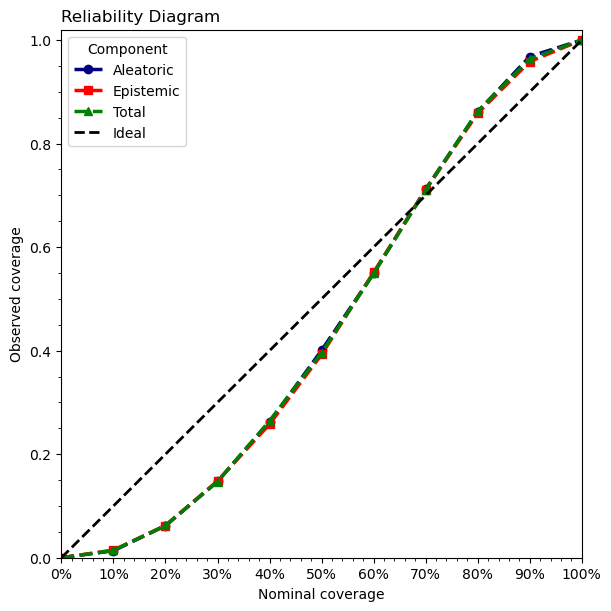

In [33]:
# -------------------------------
# 3) Reliability Diagram
# -------------------------------
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)
ticks = [f"{int(p*100)}%" for p in nominal]

ax.plot(nominal, cov_ale, marker='o', linestyle='--', color='navy',
        lw=2.5, label='Aleatoric')
ax.plot(nominal, cov_epi, marker='s', linestyle='--', color='red',
        lw=2.5, label='Epistemic')
ax.plot(nominal, cov_tot, marker='^', linestyle='--', color='green',
        lw=2.5, label='Total')
ax.plot([0,1], [0,1], 'k--', lw=2, label='Ideal')

ax.set_xticks(nominal)
ax.set_xticklabels(ticks)
ax.set_xlim(0,1)
ax.set_ylim(0,1.02)
ax.set_xlabel('Nominal coverage')
ax.set_ylabel('Observed coverage')
ax.set_title('Reliability Diagram', loc='left')
ax.legend(title='Component')
ax.minorticks_on()

plt.show()


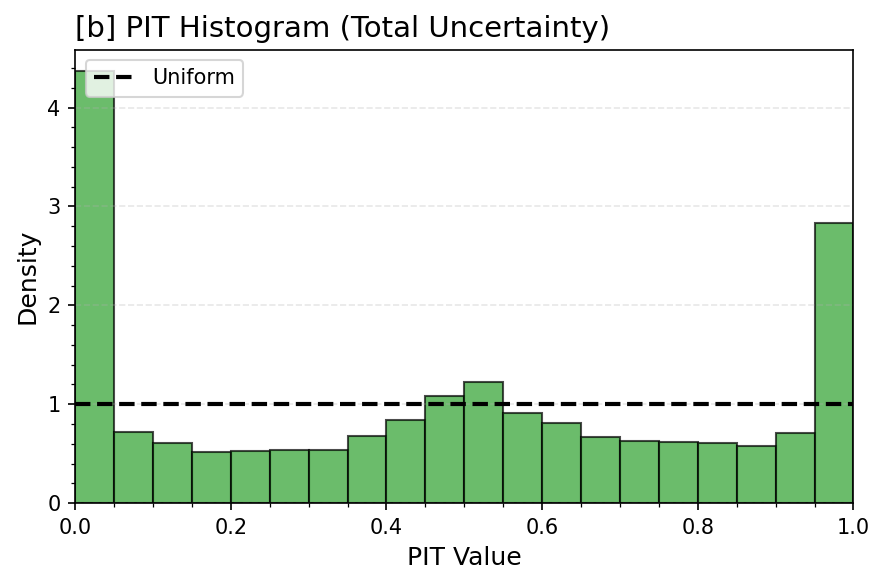

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ── Compute PIT values for total uncertainty ──────────────────────────────────
# (Assumes clm5_ppe, ednn_ppe, and sigma_cal already defined from your previous cells)

# Compute PIT: for each sample, the CDF value of the standardized residual
pit_vals = norm.cdf((clm5_ppe - ednn_ppe) / sigma_cal)

# ── Plot PIT histogram ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
bins = np.linspace(0, 1, 21)

# Density normalization so a flat line at 1 is “perfectly uniform”
ax.hist(
    pit_vals,
    bins=bins,
    density=True,
    color='tab:green',
    edgecolor='black',
    alpha=0.7
)
ax.axhline(1, color='k', linestyle='--', linewidth=2, label='Uniform')

ax.set_xlabel('PIT Value', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('[b] PIT Histogram (Total Uncertainty)', loc='left', fontsize=14)
ax.legend(loc='upper left')
ax.set_xlim(0, 1)
ax.minorticks_on()
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


Calibration factors -> aleatoric: 0.47, epistemic: 0.48, total: 0.32


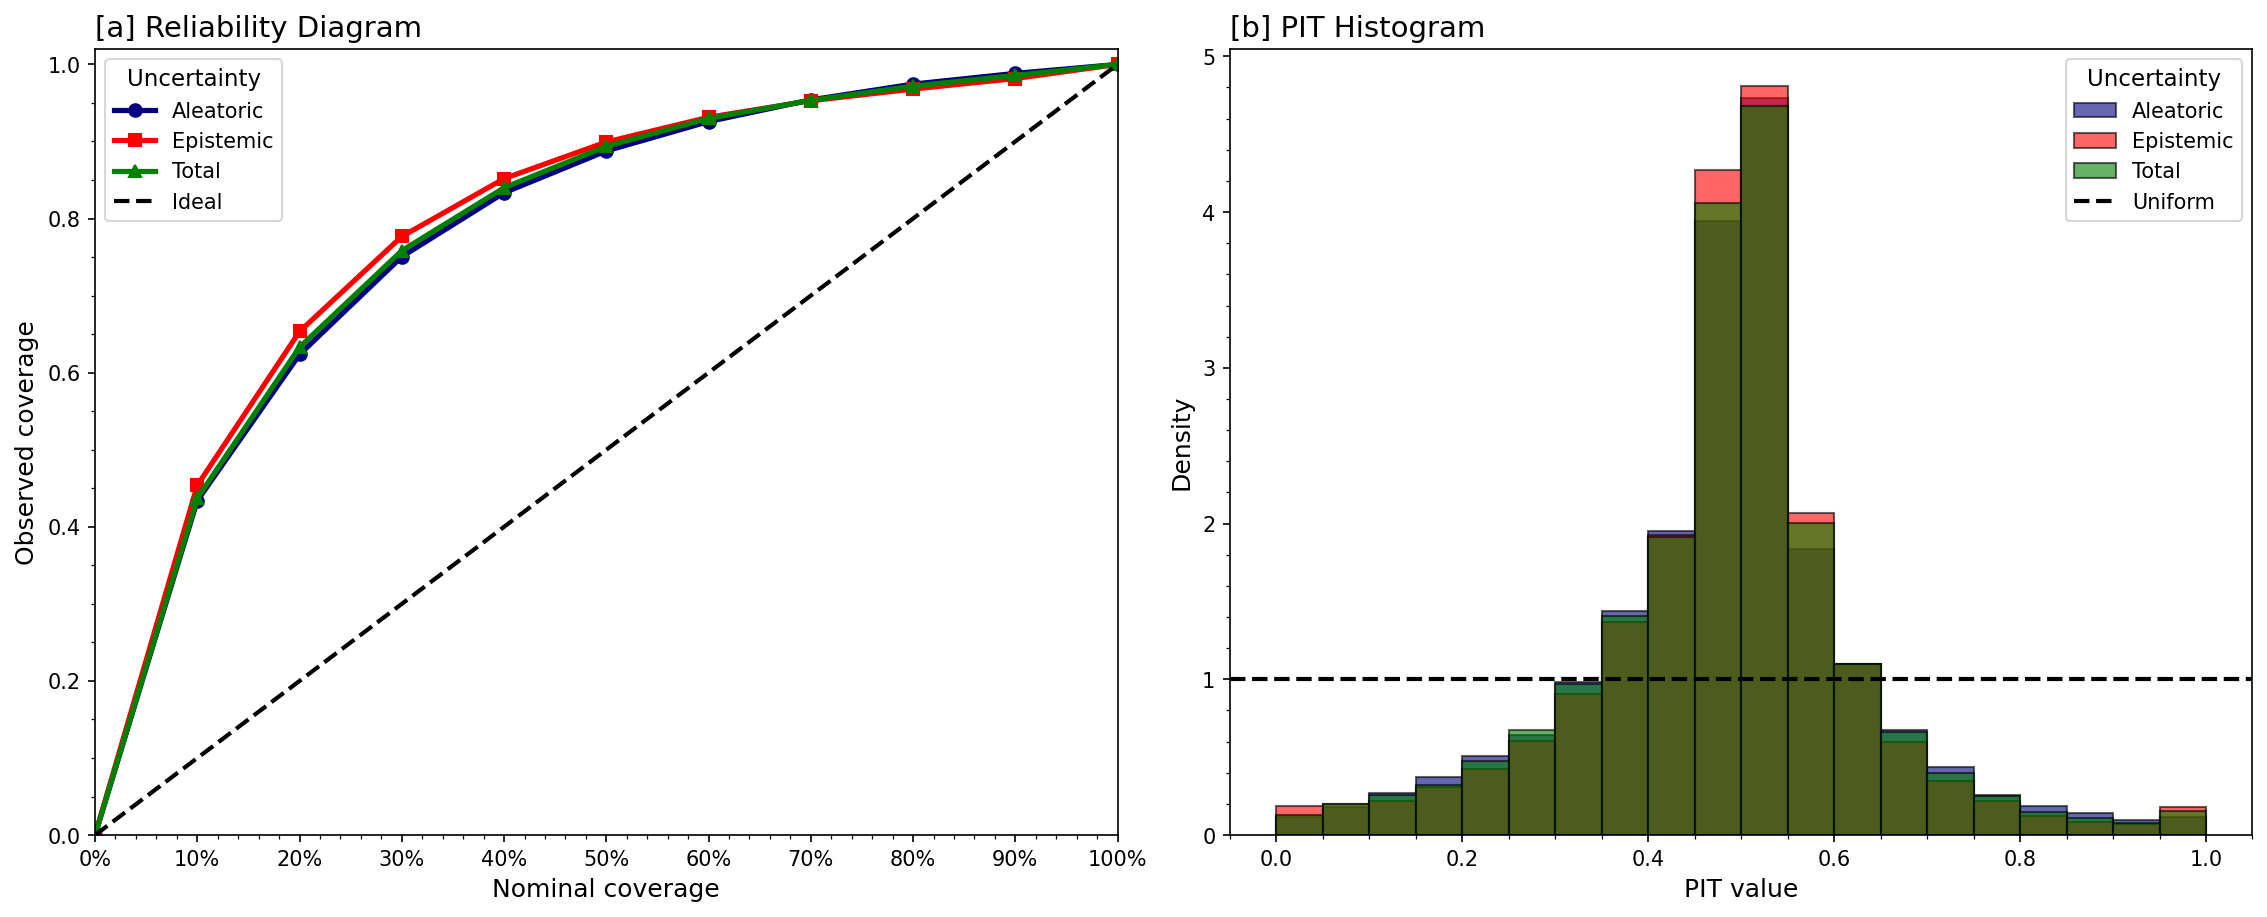

In [49]:
from scipy.optimize import minimize
#-------------------------------
# Data Preparation
#-------------------------------
#------------------ Select first 10 ensemble members and flatten arrays
members = clm5_lai_ppe_anom.member.values#[:10]
clm5_ppe = np.nan_to_num(
    clm5_lai_ppe_anom.sel(member=members).values.flatten(),
    nan=0.0
)
ednn_ppe = np.nan_to_num(
    ednn_ppe_lai_anom.sel(member=members).values.flatten(),
    nan=0.0
)
ale = np.nan_to_num(
    pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric', member=members).values.flatten(),
    nan=0.0
)
epi = np.nan_to_num(
    pred_val_3d.TLAI_unc.sel(uncertainty='epistemic', member=members).values.flatten(),
    nan=0.0
)
assert clm5_ppe.shape == ednn_ppe.shape == ale.shape == epi.shape

#-------------------------------
# Total Uncertainty Calculation
#-------------------------------
#------------------ Absolute uncertainties and prevent zeros
ale = np.abs(ale)
epi = np.abs(epi)
sigma_tot = np.sqrt(ale**2 + epi**2)
#------------------ Avoid exact zeros
sigma_tot[sigma_tot == 0] = 1e-10

#-------------------------------
# Conformal Calibration at 95% Interval
#-------------------------------
#------------------ Use standardized residuals to find scale factors for 95% coverage
alpha_cal = 0.95
z_cal = norm.ppf((1 + alpha_cal) / 2)
#---------------- Standardized residuals for each component
s_ale = np.abs(clm5_ppe - ednn_ppe) / ale
s_epi = np.abs(clm5_ppe - ednn_ppe) / epi
s_tot = np.abs(clm5_ppe - ednn_ppe) / sigma_tot
#----------------- Compute calibration multipliers (quantile of s at alpha_cal)
gamma_ale = np.quantile(s_ale, alpha_cal)
gamma_epi = np.quantile(s_epi, alpha_cal)
gamma_tot = np.quantile(s_tot, alpha_cal)
#------------------ Apply calibration
ale *= gamma_ale
epi *= gamma_epi
sigma_tot *= gamma_tot

print(
    f"Calibration factors -> aleatoric: {gamma_ale:.2f}, "
    f"epistemic: {gamma_epi:.2f}, total: {gamma_tot:.2f}"
)

#-------------------------------
# Reliability Diagram Metrics
#-------------------------------
#------------------ Nominal coverage levels
nominal = np.linspace(0.0, 1.0, 11)
cov_ale, cov_epi, cov_tot = [], [], []
for alpha in nominal:
    z = norm.ppf((1 + alpha) / 2) if alpha > 0 else 0
    #------------------ Aleatoric coverage
    low = ednn_ppe - z * ale
    high = ednn_ppe + z * ale
    cov_ale.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))
    #------------------ Epistemic coverage
    low = ednn_ppe - z * epi
    high = ednn_ppe + z * epi
    cov_epi.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))
    #------------------ Total coverage
    low = ednn_ppe - z * sigma_tot
    high = ednn_ppe + z * sigma_tot
    cov_tot.append(np.mean((clm5_ppe >= low) & (clm5_ppe <= high)))

cov_ale = np.array(cov_ale)
cov_epi = np.array(cov_epi)
cov_tot = np.array(cov_tot)
#------------------ 95% Wilson score intervals
n = clm5_ppe.size
ci_ale = np.array([
    proportion_confint(int(c * n), n, alpha=0.05, method='wilson')[1] - c
    for c in cov_ale
])
ci_epi = np.array([
    proportion_confint(int(c * n), n, alpha=0.05, method='wilson')[1] - c
    for c in cov_epi
])
ci_tot = np.array([
    proportion_confint(int(c * n), n, alpha=0.05, method='wilson')[1] - c
    for c in cov_tot
])

#-------------------------------
# PIT Histogram Data
#-------------------------------
#------------------ Prevent zero or negative scales
ale[ale <= 0] = 1e-10
epi[epi <= 0] = 1e-10
sigma_tot[sigma_tot <= 0] = 1e-10
# PIT values
pit_ale = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=ale)
pit_epi = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=epi)
pit_tot = norm.cdf(clm5_ppe, loc=ednn_ppe, scale=sigma_tot)

#-------------------------------
# Plot Reliability Diagram & PIT Histogram
#-------------------------------
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(15, 6),
    dpi=150,
    constrained_layout=True
)
#------------------ [a] Reliability Diagram
ax1.plot(nominal, cov_ale, 'o-', color='navy', linewidth=2.5, label='Aleatoric')
ax1.plot(nominal, cov_epi, 's-', color='red', linewidth=2.5, label='Epistemic')
ax1.plot(nominal, cov_tot, '^-', color='green', linewidth=2.5, label='Total')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Ideal')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1.02)
#------------------ ax1.set_xlim(0,1); ax1.set_ylim(0, np.max([plt.ylim()[1], 1.2]))
ax1.set_xticks(nominal)
ax1.set_xticklabels([f"{int(p*100)}%" for p in nominal])
ax1.set_xlabel('Nominal coverage', fontsize=12)
ax1.set_ylabel('Observed coverage', fontsize=12)
ax1.set_title('[a] Reliability Diagram', loc='left', fontsize=14)
ax1.legend(fontsize=10, title='Uncertainty', title_fontsize=11)
ax1.minorticks_on()
#------------------ [b] PIT Histogram
bins = np.linspace(0, 1, 21)
ax2.hist(pit_ale, bins=bins, density=True, color='navy', alpha=0.6, label='Aleatoric', edgecolor='black')
ax2.hist(pit_epi, bins=bins, density=True, color='red', alpha=0.6, label='Epistemic', edgecolor='black')
ax2.hist(pit_tot, bins=bins, density=True, color='green', alpha=0.6, label='Total', edgecolor='black')
ax2.axhline(1, color='black', linestyle='--', linewidth=2, label='Uniform')
ax2.set_xlabel('PIT value', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('[b] PIT Histogram', loc='left', fontsize=14)
ax2.legend(fontsize=10, title='Uncertainty', title_fontsize=11)
ax2.minorticks_on()

#-------------------------------
# Save & Show
#-------------------------------
plt.savefig(f"{figure_path}/reliability_pit_enhanced.pdf", bbox_inches='tight')
plt.show()

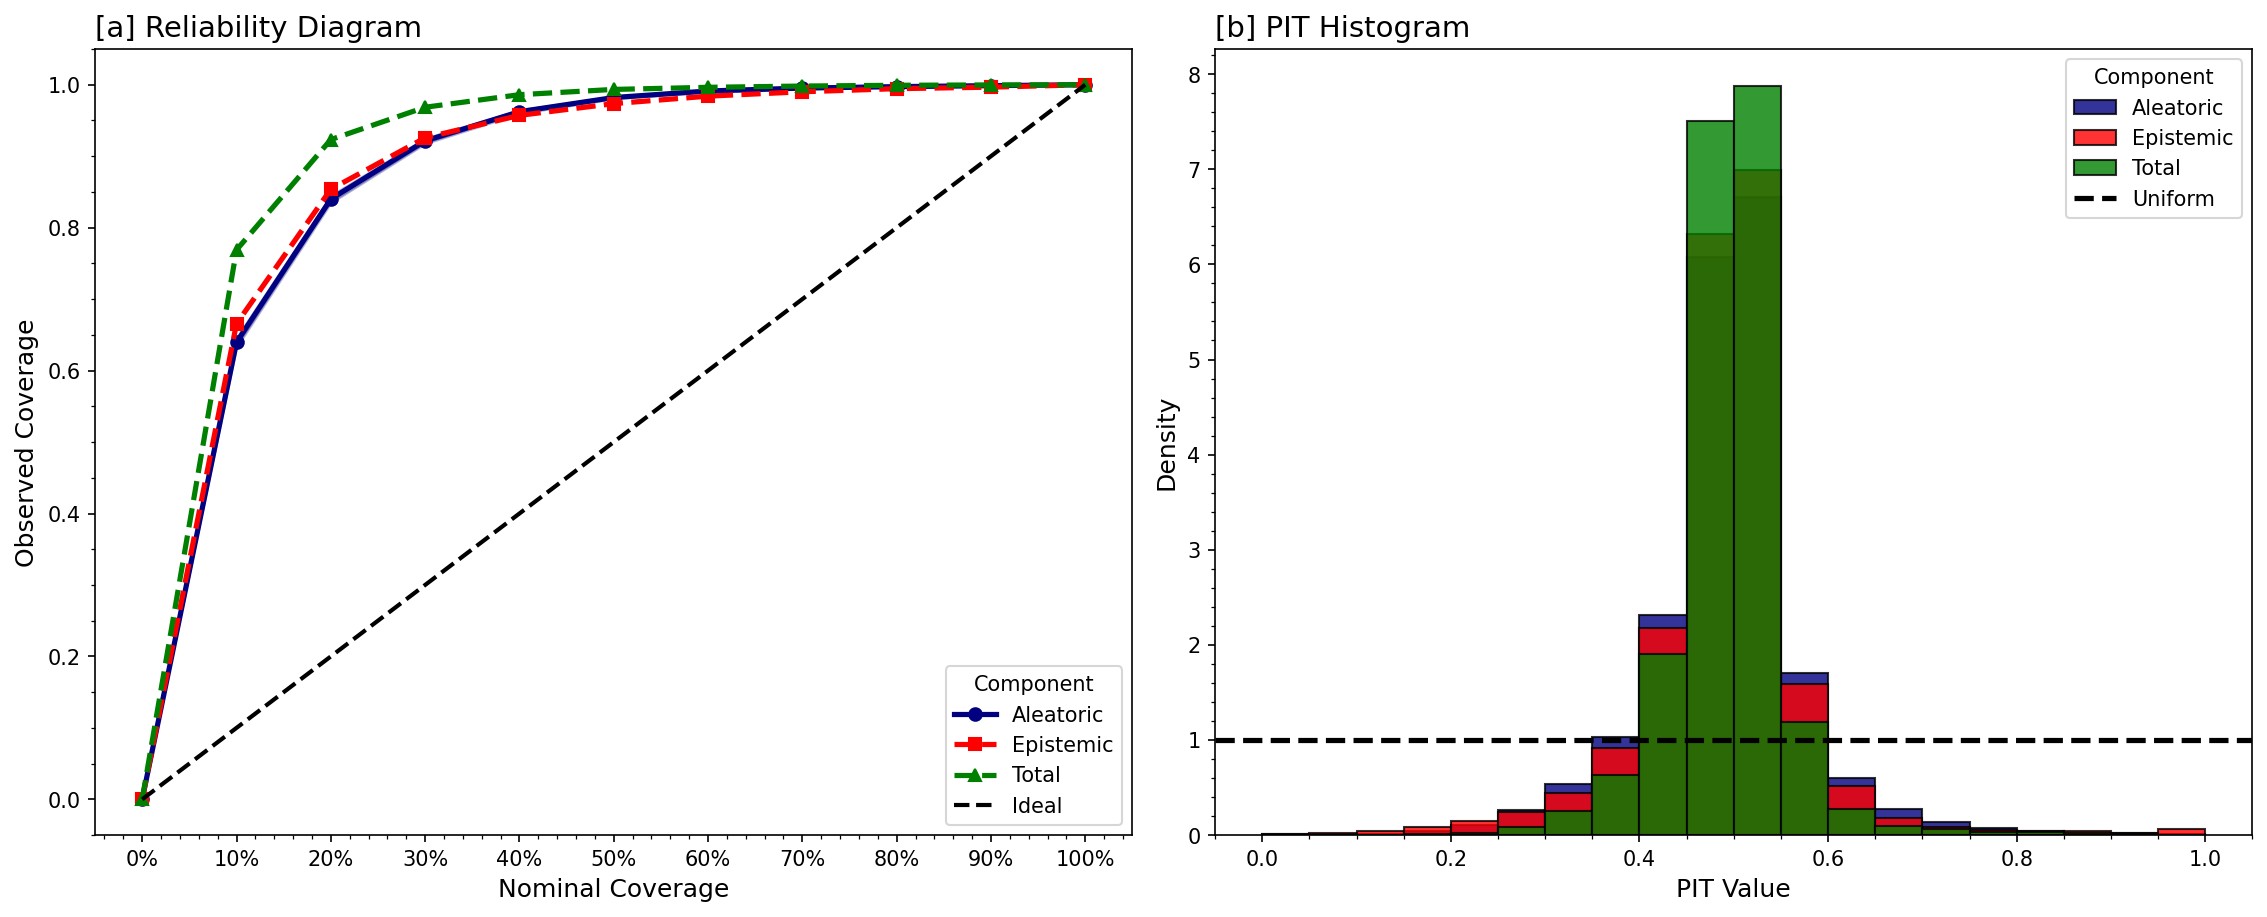

In [50]:
from matplotlib.ticker import FormatStrFormatter
# -----------------------------------------------------------------------------
# Load & Flatten Data
# -----------------------------------------------------------------------------
members = clm5_lai_ppe_anom.member.values
clm5_vals = clm5_lai_ppe_anom.sel(member=members).values.ravel()
ednn_vals = ednn_ppe_lai_anom.sel(member=members).values.ravel()
ale_vals  = pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric',  member=members).values.ravel()
epi_vals  = pred_val_3d.TLAI_unc.sel(uncertainty='epistemic', member=members).values.ravel()

#------------------ Replace NaNs and ensure matching shapes
clm5 = np.nan_to_num(clm5_vals, nan=0.0)
ednn = np.nan_to_num(ednn_vals, nan=0.0)
ale  = np.abs(np.nan_to_num(ale_vals, nan=0.0))
epi  = np.abs(np.nan_to_num(epi_vals, nan=0.0))
assert clm5.shape == ednn.shape == ale.shape == epi.shape

# -----------------------------------------------------------------------------
# Compute Total Uncertainty
# -----------------------------------------------------------------------------
sigma = np.sqrt(ale**2 + epi**2)
sigma[sigma == 0] = 1e-10  # avoid zeros for numerical stability

# -----------------------------------------------------------------------------
# Define Nominal Coverage Levels
# -----------------------------------------------------------------------------
nominal = np.linspace(0.0, 1.0, 11)  # 0%, 10%, ..., 100%

# -----------------------------------------------------------------------------
# Compute Observed Coverage for Each Component
# -----------------------------------------------------------------------------
cov_ale, cov_epi, cov_tot = [], [], []
for alpha in nominal:
    z = norm.ppf((1 + alpha) / 2) if alpha > 0 else 0.0

    #------------------ Aleatoric intervals
    lo_ale = ednn - z * ale
    hi_ale = ednn + z * ale
    cov_ale.append(np.mean((clm5 >= lo_ale) & (clm5 <= hi_ale)))

    #------------------ Epistemic intervals
    lo_epi = ednn - z * epi
    hi_epi = ednn + z * epi
    cov_epi.append(np.mean((clm5 >= lo_epi) & (clm5 <= hi_epi)))

    #------------------ Total intervals
    lo_tot = ednn - z * sigma
    hi_tot = ednn + z * sigma
    cov_tot.append(np.mean((clm5 >= lo_tot) & (clm5 <= hi_tot)))

cov_ale = np.array(cov_ale)
cov_epi = np.array(cov_epi)
cov_tot = np.array(cov_tot)

# -----------------------------------------------------------------------------
# Compute 95% Wilson Score Intervals for Aleatoric Coverage
# -----------------------------------------------------------------------------
n = clm5.size
ci_half = norm.ppf(0.975) * np.sqrt(cov_ale * (1 - cov_ale) / n)

# -----------------------------------------------------------------------------
# Compute PIT Values
# -----------------------------------------------------------------------------
# Prevent zero-scale issues
ale[ale <= 0] = 1e-10
epi[epi <= 0] = 1e-10
sigma[sigma <= 0] = 1e-10

pit_ale = norm.cdf((clm5 - ednn) / ale)
pit_epi = norm.cdf((clm5 - ednn) / epi)
pit_tot = norm.cdf((clm5 - ednn) / sigma)

# -----------------------------------------------------------------------------
# Plot Reliability Diagram & PIT Histogram
# -----------------------------------------------------------------------------
fig, (ax_rel, ax_pit) = plt.subplots(1, 2, figsize=(15, 6), dpi=150, constrained_layout=True)

#------------------ [a] Reliability Diagram
labels = [f"{int(p*100)}%" for p in nominal]
ax_rel.plot(nominal, cov_ale, 'o-', color='navy', lw=2.5, label='Aleatoric')
ax_rel.fill_between(nominal, cov_ale - ci_half, cov_ale + ci_half, color='navy', alpha=0.3)
ax_rel.plot(nominal, cov_epi, 's--', color='red', lw=2.5, label='Epistemic')
ax_rel.plot(nominal, cov_tot, '^--', color='green', lw=2.5, label='Total')
ax_rel.plot([0, 1], [0, 1], 'k--', lw=2, label='Ideal')
ax_rel.set_xticks(nominal)
ax_rel.set_xticklabels(labels)
# ax_rel.set_xlim(0, 1)
# ax_rel.set_ylim(0.8, 1.02)
ax_rel.set_xlabel('Nominal Coverage', fontsize=12)
ax_rel.set_ylabel('Observed Coverage', fontsize=12)
ax_rel.set_title('[a] Reliability Diagram', loc='left', fontsize=14)
ax_rel.legend(title='Component', fontsize=10)
ax_rel.minorticks_on()

#------------------ [b] PIT Histogram
bins = np.linspace(0, 1, 21)
ax_pit.hist(pit_ale, bins=bins, density=True, color='navy', alpha=0.8, label='Aleatoric', edgecolor='black')
ax_pit.hist(pit_epi, bins=bins, density=True, color='red', alpha=0.8, label='Epistemic', edgecolor='black')
ax_pit.hist(pit_tot, bins=bins, density=True, color='green', alpha=0.8, label='Total', edgecolor='black')
ax_pit.axhline(1, color='k', linestyle='--', lw=2.5, label='Uniform')
ax_pit.set_xlabel('PIT Value', fontsize=12)
ax_pit.set_ylabel('Density', fontsize=12)
ax_pit.set_title('[b] PIT Histogram', loc='left', fontsize=14)
ax_pit.legend(title='Component', fontsize=10)
ax_pit.minorticks_on()

#------------------ Save & Show
plt.savefig(f"{figure_path}/reliability_pit_cleaned.pdf", bbox_inches='tight')
plt.show()


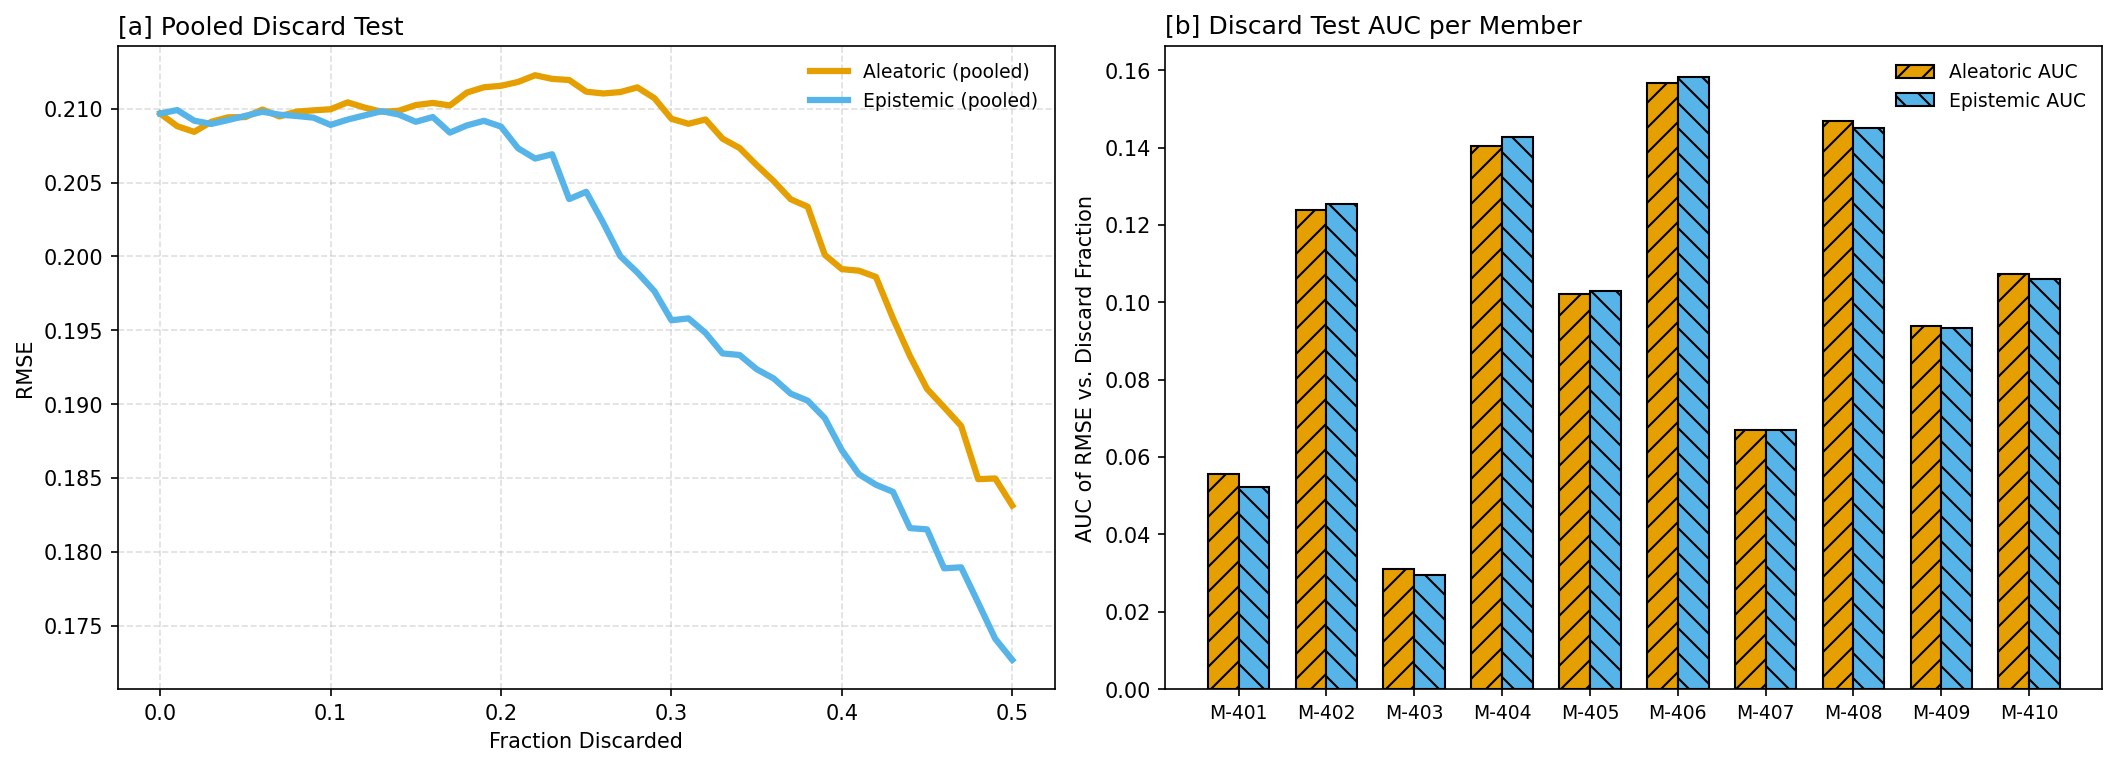

In [37]:
from numpy import trapz
# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
N_MEMBERS    = 10
FRACTIONS    = np.linspace(0, 0.5, 51)  # discard fractions from 0% to 50%
COL_PALETTE  = {'aleatoric': '#E69F00', 'epistemic': '#56B4E9'}

# -----------------------------------------------------------------------------
# Flatten Pooled Data Across First N_MEMBERS
# -----------------------------------------------------------------------------
members    = clm5_lai_ppe_anom.member.values[:N_MEMBERS]
clm5_all   = clm5_lai_ppe_anom.sel(member=members).values.ravel()
ednn_all   = ednn_ppe_lai_anom.sel(member=members).values.ravel()
ale_all    = np.abs(pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric',  member=members).values.ravel())
epi_all    = np.abs(pred_val_3d.TLAI_unc.sel(uncertainty='epistemic', member=members).values.ravel())

assert clm5_all.shape == ednn_all.shape == ale_all.shape == epi_all.shape

# -----------------------------------------------------------------------------
# Compute Pooled Discard-Test RMSE Curve
# -----------------------------------------------------------------------------
def compute_rmse_curve(truth, pred, uncert, fractions):
    """Return RMSE curve as we discard the top-uncert fractions."""
    rmse_curve = []
    for f in fractions:
        #-------------- threshold at (1–f) quantile of uncertainty
        thr = np.percentile(uncert, 100 * (1 - f))
        mask = uncert <= thr
        rmse = np.sqrt(mean_squared_error(truth[mask], pred[mask]))
        rmse_curve.append(rmse)
    return np.array(rmse_curve)

rmse_ale_pooled = compute_rmse_curve(clm5_all, ednn_all, ale_all, FRACTIONS)
rmse_epi_pooled = compute_rmse_curve(clm5_all, ednn_all, epi_all, FRACTIONS)

# -----------------------------------------------------------------------------
# Compute Per-Member AUC for Discard Test
# -----------------------------------------------------------------------------
auc_ale_per_member = []
auc_epi_per_member = []

for m in members:
    y_true = clm5_lai_ppe_anom.sel(member=m).values
    y_pred = ednn_ppe_lai_anom.sel(member=m).values
    ale_m   = np.abs(pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric',  member=m).values)
    epi_m   = np.abs(pred_val_3d.TLAI_unc.sel(uncertainty='epistemic', member=m).values)

    rmse_ale = compute_rmse_curve(y_true, y_pred, ale_m, FRACTIONS)
    rmse_epi = compute_rmse_curve(y_true, y_pred, epi_m, FRACTIONS)

    auc_ale_per_member.append(trapz(rmse_ale, FRACTIONS))
    auc_epi_per_member.append(trapz(rmse_epi, FRACTIONS))

# -----------------------------------------------------------------------------
# Plot Discard-Test Curves & AUC Bars
# -----------------------------------------------------------------------------
fig, (ax_curve, ax_bar) = plt.subplots(1, 2, figsize=(14, 5), dpi=150, constrained_layout=True)

#-------------- (a) Pooled Discard-Test RMSE
ax_curve.plot(FRACTIONS, rmse_ale_pooled, label='Aleatoric (pooled)',
              color=COL_PALETTE['aleatoric'], linewidth=3)
ax_curve.plot(FRACTIONS, rmse_epi_pooled, label='Epistemic (pooled)',
              color=COL_PALETTE['epistemic'], linewidth=3)
ax_curve.set_title('[a] Pooled Discard Test', loc='left', fontsize=12)
ax_curve.set_xlabel('Fraction Discarded', fontsize=10)
ax_curve.set_ylabel('RMSE', fontsize=10)
ax_curve.grid(linestyle='--', alpha=0.4)
ax_curve.legend(frameon=False, fontsize=9)

#-------------- (b) Per-Member AUC Bar Chart
x = np.arange(len(members))
width = 0.35

ax_bar.bar(x - width/2, auc_ale_per_member, width,
           label='Aleatoric AUC',
           color=COL_PALETTE['aleatoric'], edgecolor='black', hatch='//')
ax_bar.bar(x + width/2, auc_epi_per_member, width,
           label='Epistemic AUC',
           color=COL_PALETTE['epistemic'], edgecolor='black', hatch='\\\\')

ax_bar.set_xticks(x)
ax_bar.set_xticklabels([f"M-{m}" for m in members], fontsize=9)
ax_bar.set_title('[b] Discard Test AUC per Member', loc='left', fontsize=12)
ax_bar.set_ylabel('AUC of RMSE vs. Discard Fraction', fontsize=10)
ax_bar.legend(frameon=False, fontsize=9)

#-------------- Save and display
plt.savefig(f"{figure_path}/discard_and_auc_subplots_clean.pdf", bbox_inches='tight')
plt.show()

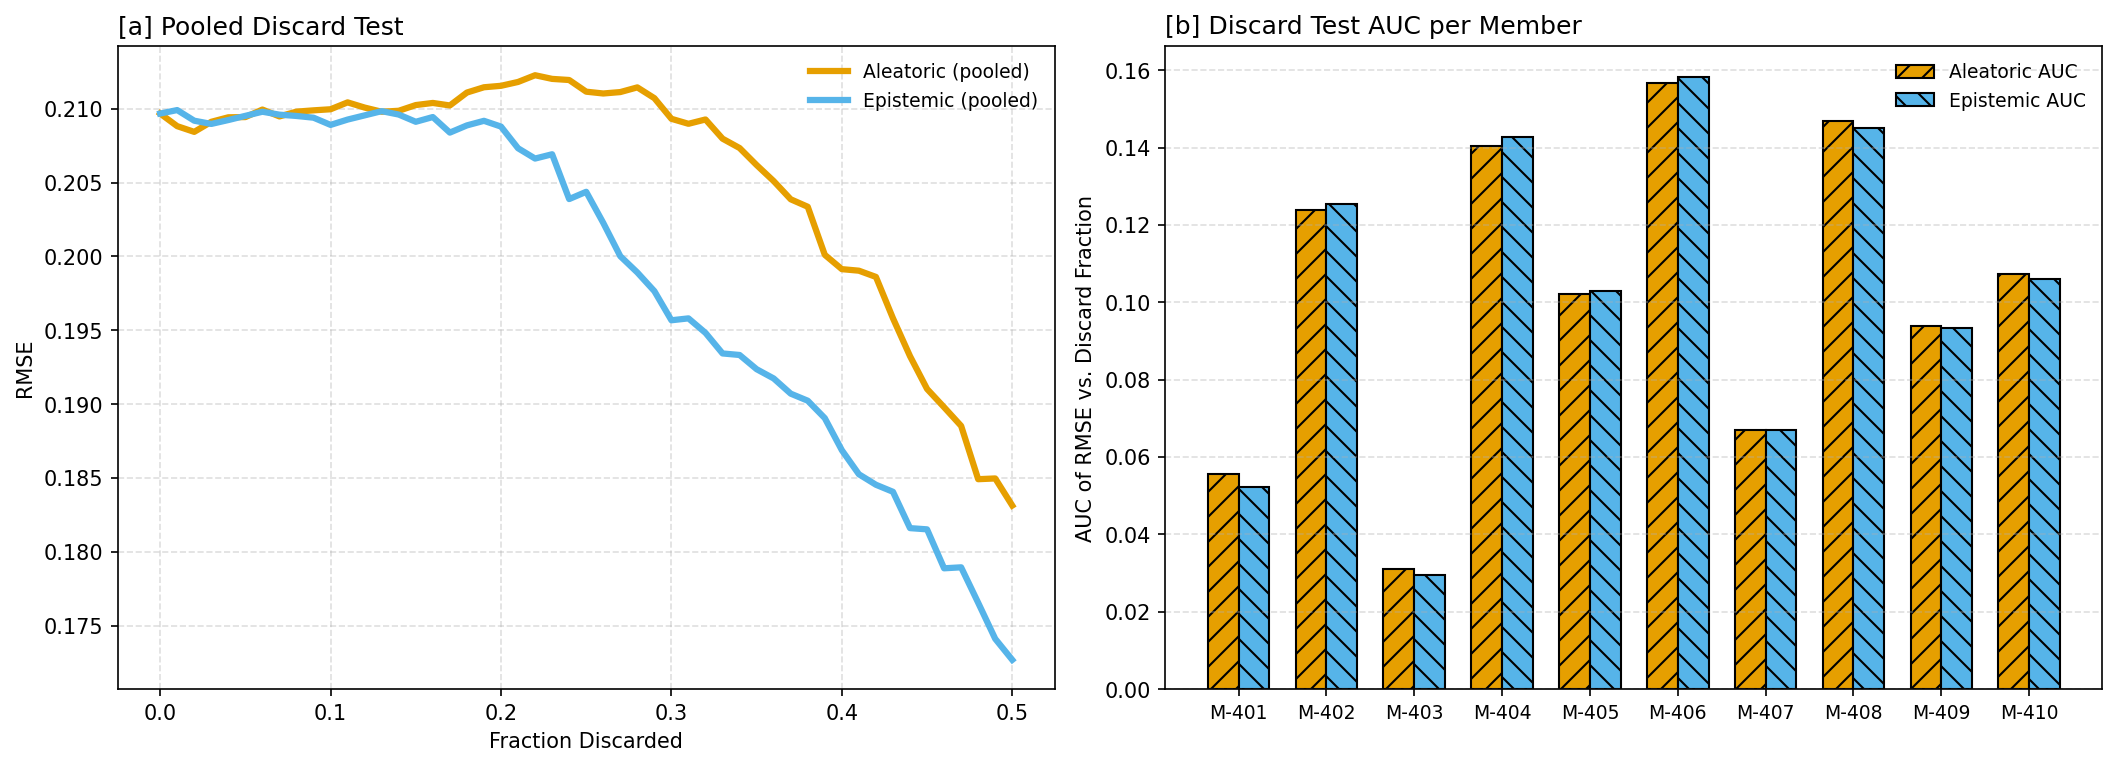

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import trapz

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
N_MEMBERS = 10
FRACTIONS = np.linspace(0, 0.5, 51)  # discard fractions 0% → 50%
COLORS    = {'aleatoric': '#E69F00', 'epistemic': '#56B4E9'}

# -----------------------------------------------------------------------------
# 1) Flatten Pooled Data Across First N_MEMBERS
# -----------------------------------------------------------------------------
members  = clm5_lai_ppe_anom.member.values[:N_MEMBERS]
truth_all = clm5_lai_ppe_anom.sel(member=members).values.ravel()
pred_all  = ednn_ppe_lai_anom.sel(member=members).values.ravel()
ale_all   = np.abs(pred_val_3d.TLAI_unc
                   .sel(uncertainty='aleatoric', member=members)
                   .values.ravel())
epi_all   = np.abs(pred_val_3d.TLAI_unc
                   .sel(uncertainty='epistemic', member=members)
                   .values.ravel())

assert truth_all.shape == pred_all.shape == ale_all.shape == epi_all.shape

# -----------------------------------------------------------------------------
# 2) Helper to compute RMSE vs. discard‐fraction curve
# -----------------------------------------------------------------------------
def compute_rmse_curve(truth, pred, uncert, fractions):
    rmse = []
    for f in fractions:
        thr = np.percentile(uncert, 100 * (1 - f))
        mask = uncert <= thr
        rmse.append(np.sqrt(mean_squared_error(truth[mask], pred[mask])))
    return np.array(rmse)

# pooled RMSE curves
rmse_ale = compute_rmse_curve(truth_all, pred_all, ale_all, FRACTIONS)
rmse_epi = compute_rmse_curve(truth_all, pred_all, epi_all, FRACTIONS)

# -----------------------------------------------------------------------------
# 3) Compute per‐member AUC
# -----------------------------------------------------------------------------
auc_ale = []
auc_epi = []
for m in members:
    y_t  = clm5_lai_ppe_anom.sel(member=m).values
    y_p  = ednn_ppe_lai_anom.sel(member=m).values
    ale_m = np.abs(pred_val_3d.TLAI_unc
                   .sel(uncertainty='aleatoric', member=m)
                   .values)
    epi_m = np.abs(pred_val_3d.TLAI_unc
                   .sel(uncertainty='epistemic', member=m)
                   .values)

    rmse_ale_m = compute_rmse_curve(y_t, y_p, ale_m, FRACTIONS)
    rmse_epi_m = compute_rmse_curve(y_t, y_p, epi_m, FRACTIONS)
    auc_ale.append(trapz(rmse_ale_m, FRACTIONS))
    auc_epi.append(trapz(rmse_epi_m, FRACTIONS))

# -----------------------------------------------------------------------------
# 4) Plot combined figure
# -----------------------------------------------------------------------------
fig, (ax_curve, ax_bar) = plt.subplots(
    1, 2,
    figsize=(14, 5),
    dpi=150,
    constrained_layout=True
)

# (a) Pooled RMSE vs. fraction discarded
ax_curve.plot(FRACTIONS, rmse_ale,
              label='Aleatoric (pooled)',
              color=COLORS['aleatoric'], linewidth=3)
ax_curve.plot(FRACTIONS, rmse_epi,
              label='Epistemic (pooled)',
              color=COLORS['epistemic'], linewidth=3)
ax_curve.set_title('[a] Pooled Discard Test', loc='left', fontsize=12)
ax_curve.set_xlabel('Fraction Discarded', fontsize=10)
ax_curve.set_ylabel('RMSE', fontsize=10)
ax_curve.grid(linestyle='--', alpha=0.4)
ax_curve.legend(frameon=False, fontsize=9)

# (b) Per-member AUC bar chart
x = np.arange(len(members))
width = 0.35
ax_bar.bar(x - width/2, auc_ale, width,
           label='Aleatoric AUC',
           color=COLORS['aleatoric'], edgecolor='black', hatch='//')
ax_bar.bar(x + width/2, auc_epi, width,
           label='Epistemic AUC',
           color=COLORS['epistemic'], edgecolor='black', hatch='\\\\')
ax_bar.set_xticks(x)
ax_bar.set_xticklabels([f"M-{m}" for m in members], fontsize=9)
ax_bar.set_title('[b] Discard Test AUC per Member', loc='left', fontsize=12)
ax_bar.set_ylabel('AUC of RMSE vs. Discard Fraction', fontsize=10)
ax_bar.legend(frameon=False, fontsize=9)
ax_bar.grid(axis='y', linestyle='--', alpha=0.4)

# Save & show
plt.savefig(f"{figure_path}/discard_and_auc_combined.pdf", bbox_inches='tight')
plt.show()


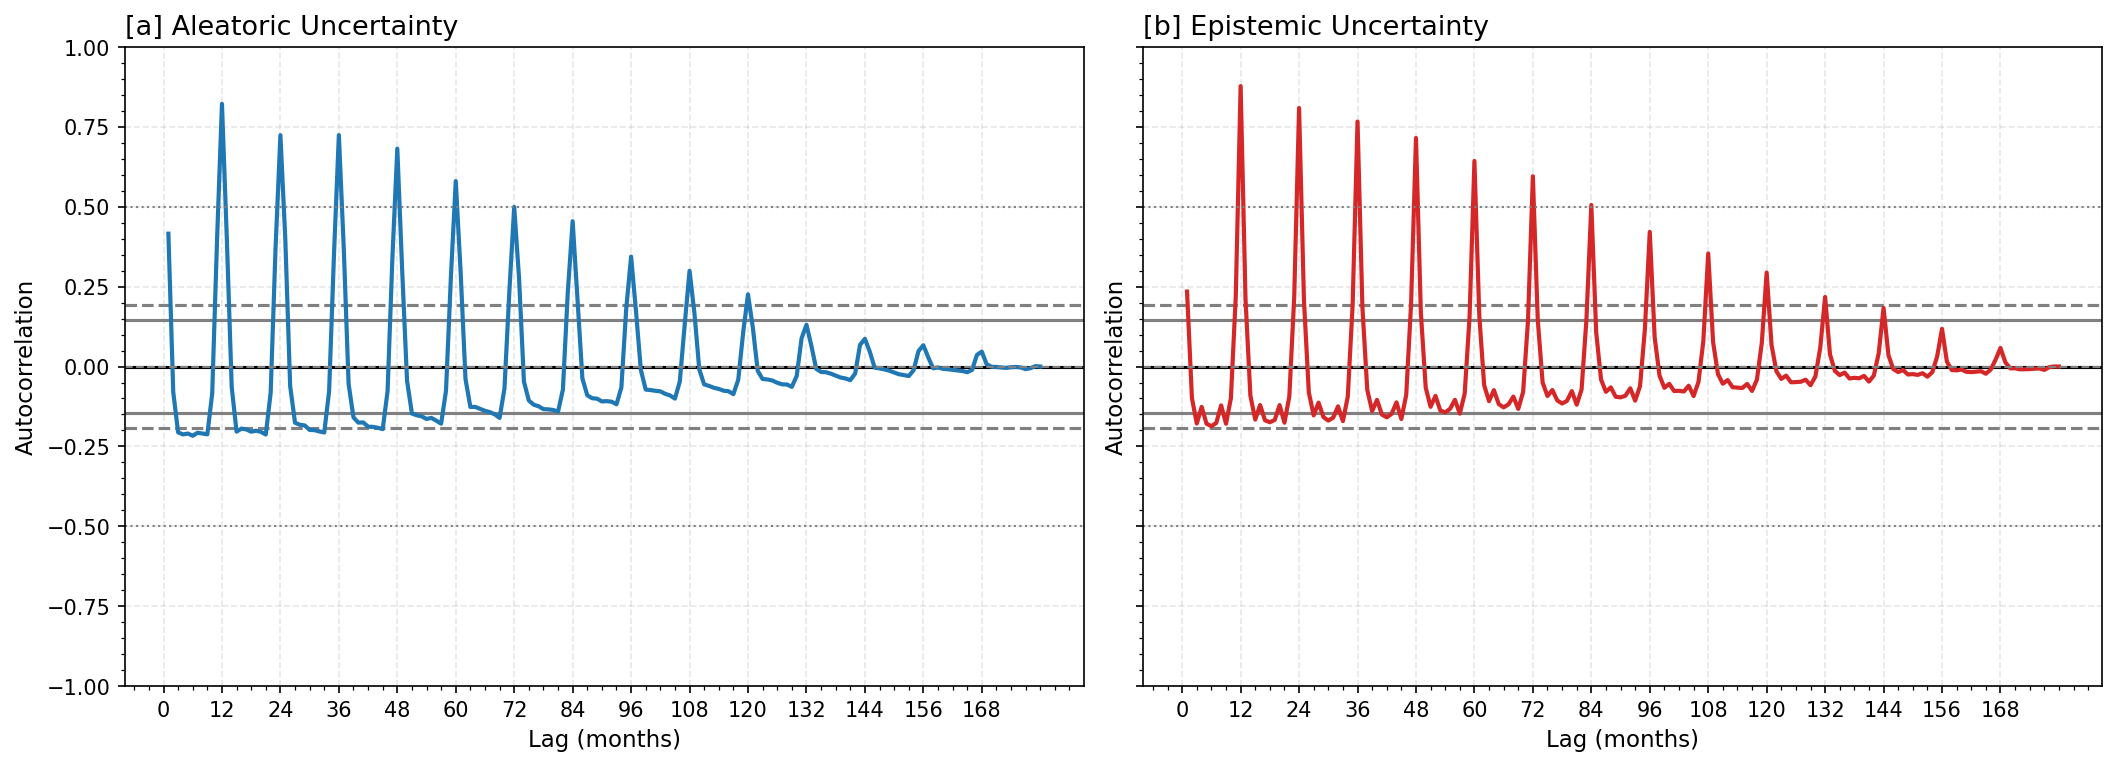

In [39]:
#------------------- Select uncertainty DataArrays
ale_da = pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric')
epi_da = pred_val_3d.TLAI_unc.sel(uncertainty='epistemic')

#------------------- Convert time coordinate to pandas.DatetimeIndex
time_idx = pd.to_datetime(ale_da.time.values.astype('datetime64[ns]'))

#------------------- Compute ensemble-mean time series
ale_series = ale_da.mean(dim='member').values
epi_series = epi_da.mean(dim='member').values

#-------------------------------
# Plot Autocorrelations
#-------------------------------
fig, axes = plt.subplots(
    ncols=2,
    figsize=(14, 5),
    sharey=True,
    dpi=150,
    constrained_layout=True
)

#------------------- Plot settings
titles = ['[a] Aleatoric Uncertainty', '[b] Epistemic Uncertainty']
colors = ['#1f77b4', '#d62728']
series_list = [ale_series, epi_series]
max_lag = len(ale_series) - 1
xticks = np.arange(0, max_lag + 1, 12)  # annual lags

for ax, series, title, color in zip(axes, series_list, titles, colors):
    #------------------- Autocorrelation via pandas utility
    pd.plotting.autocorrelation_plot(
        pd.Series(series, index=time_idx),
        ax=ax,
        color=color,
        linewidth=2
    )

    #------------------- Reference lines at 0, ±0.5
    for y, ls in zip([0, 0.5, -0.5], ['--', ':', ':']):
        ax.axhline(y, color='gray', linestyle=ls, linewidth=1)

    #------------------- Axis formatting
    ax.set_title(title, loc='left', fontsize=13)
    ax.set_xlabel('Lag (months)', fontsize=11)
    ax.set_ylabel('Autocorrelation', fontsize=11)
    ax.set_ylim(-1, 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.grid(which='major', linestyle='--', alpha=0.3)
    ax.minorticks_on()

#------------------- Save and display
plt.savefig(f"{figure_path}/autocorrelation_enhanced.pdf", bbox_inches='tight')
plt.show()

# Parameter Sensitivity Analysis

In [40]:
# from model.fast_model import fast_model_ednn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [41]:
X_df = X["feature"].to_dataframe(name='feature').reset_index(drop=True)
print(X_df .head())

          feature
0  FUN_fracfixers
1             KCN
2           a_fix
3       crit_dayl
4           d_max


In [42]:
from sklearn.preprocessing import QuantileTransformer

# 7) Materialize & scale
X_train = X_train_xr.data.compute().astype(np.float32)
X_val   = X_val_xr.data.compute().astype(np.float32)

# replace StandardScaler with QuantileTransformer
scaler = QuantileTransformer(
    n_quantiles=1000,             # number of quantiles to compute (you can tune this)
    output_distribution='uniform',# or 'normal' if you want Gaussian outputs
    subsample=100000,             # for large datasets you can subsample to speed up
    random_state=42
)
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

y_train = y_train_xr.data.compute().astype(np.float32).reshape(-1, 1)
y_val   = y_val_xr.data.compute().astype(np.float32).reshape(-1, 1)

print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train:", y_train.shape, "y_val:",   y_val.shape)

X_train: (13780800, 37) X_val: (522000, 37)
y_train: (13780800, 1) y_val: (522000, 1)


In [43]:
import numpy as np
import pandas as pd
from SALib.sample import fast_sampler
from SALib.analyze import fast as fast_analyze

# ── FAST sensitivity analysis function ─────────────────────────────────────
def fast_model_ednn(
    X_np: np.ndarray,
    feature_names: list[str],
    ednn_model,
    scaler,
    pred_index: int = 0,
    M: int = 4,
    num_resamples: int = 10000,
    conf_level: float = 0.95,
):
    """
    Run FAST sensitivity analysis on an EDNN emulator.
    Varies only the PPE parameters, holding meteorological forcings fixed at their mean.
    """
    # to DataFrame
    df = pd.DataFrame(X_np, columns=feature_names)

    # split forcing vs parameter columns
    forcing_names = ["TSA", "PRECIP", "m_cos", "m_sin", "year"]
    param_names   = [n for n in feature_names if n not in forcing_names]

    # baseline forcings = columnwise mean
    baseline_forc = df[forcing_names].mean(axis=0).values

    # define SALib problem on PPE parameters
    bounds = [[df[p].min(), df[p].max()] for p in param_names]
    problem = {
        "names":    param_names,
        "num_vars": len(param_names),
        "bounds":   bounds,
    }

    # FAST sample in parameter space
    Xp = fast_sampler.sample(problem, num_resamples, M=M, seed=0)
    n_fast = Xp.shape[0]

    # tile baseline forcings
    baseline_mat = np.tile(baseline_forc, (n_fast, 1))

    # reconstruct full feature matrix
    X_sample = np.hstack([Xp, baseline_mat])
    sample_df = pd.DataFrame(X_sample, columns=param_names + forcing_names)
    X_sample  = sample_df[feature_names].values

    # scale & predict
    X_scaled = scaler.transform(X_sample)
    Y_raw    = ednn_model.predict(X_scaled, return_uncertainties=False)
    Y_mu     = Y_raw[:, pred_index]

    # debug
    print("DEBUG: Y_mu min, max, std =", Y_mu.min(), Y_mu.max(), np.std(Y_mu))

    # analyze with FAST
    Si = fast_analyze.analyze(
        problem,
        Y_mu,
        M=M,
        num_resamples=500,
        conf_level=conf_level,
        print_to_console=True,
        seed=0
    )
    return Si

# # ── season mapping ─────────────────────────────────────────────────────────
# def get_season(month: int) -> str:
#     if month in (12, 1, 2):
#         return 'DJF'
#     elif month in (3, 4, 5):
#         return 'MAM'
#     elif month in (6, 7, 8):
#         return 'JJA'
#     else:
#         return 'SON'

# # ── Main: seasonal sensitivity analysis ────────────────────────────────────

# # extract sample‐level datetimes
# time_samples = pd.to_datetime(
#     X_train_xr['time'].values.astype('datetime64[ns]')
# )

# # assign each sample to a meteorological season
# seasons = pd.Series(time_samples.month, name='month').map(get_season)

# # group sample indices by season
# season_indices = {
#     season: np.where(seasons.values == season)[0]
#     for season in ['DJF', 'MAM', 'JJA', 'SON']
# }

# # loop over seasons and run FAST
# season_results = {}
# for season, idx in season_indices.items():
#     if len(idx) == 0:
#         continue
#     print(f"\n Running FAST for season: {season} (n={len(idx)} samples)")

#     # subset the DataArray by sample‐index
#     X_season = X_train_xr.isel(sample=idx)

#     # build numpy array and feature names
#     feature_names = list(X_season.feature.values)
#     X_np = X_season.data.compute().astype(np.float32)

#     # run FAST
#     Si = fast_model_ednn(
#         X_np=X_np,
#         feature_names=feature_names,
#         ednn_model=model,
#         scaler=scaler,
#         pred_index=0,
#         M=8,
#         num_resamples=1000,
#         conf_level=0.95
#     )

#     season_results[season] = Si

# # 5) Example: print top‐5 parameters by first‐order index for each season
# for season, Si in season_results.items():
#     print(f"\nTop 5 S1 indices for {season}:")
#     ranked = sorted(zip(Si['names'], Si['S1']), key=lambda x: -abs(x[1]))[:5]
#     for name, val in ranked:
#         print(f"  {name}: {val:.3f}")


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from SALib.sample import fast_sampler
from SALib.analyze import fast as fast_analyze

# ── 2) Season mapping ─────────────────────────────────────────────────────
def get_season(month: int) -> str:
    if month in (12,1,2): return 'DJF'
    if month in (3,4,5):   return 'MAM'
    if month in (6,7,8):   return 'JJA'
    return 'SON'

# ── 3) Build season_results dict ─────────────────────────────────────────
times = pd.to_datetime(X_train_xr['time'].values.astype('datetime64[ns]'))
seasons = pd.Series(times.month).map(get_season).values

season_results = {}
for season in ['DJF','MAM','JJA','SON']:
    idx = np.where(seasons == season)[0]
    X_season = X_train_xr.isel(sample=idx)
    X_np = X_season.data.compute().astype(np.float32)
    feature_names = list(X_season.feature.values)
    print(f"Running FAST for {season} ({len(idx)} samples)…")
    season_results[season] = fast_model_ednn(
        X_np, feature_names, model, scaler,
        pred_index=0, M=8, num_resamples=50000, conf_level=0.95
    )

# ── 4) Convert to DataFrames for plotting ─────────────────────────────────
df_Si_djf = pd.DataFrame({
    'names': season_results['DJF']['names'],
    'S1':    season_results['DJF']['S1'],
    'ST':    season_results['DJF']['ST'],
})
df_Si_mam = pd.DataFrame({
    'names': season_results['MAM']['names'],
    'S1':    season_results['MAM']['S1'],
    'ST':    season_results['MAM']['ST'],
})
df_Si_jja = pd.DataFrame({
    'names': season_results['JJA']['names'],
    'S1':    season_results['JJA']['S1'],
    'ST':    season_results['JJA']['ST'],
})
df_Si_son = pd.DataFrame({
    'names': season_results['SON']['names'],
    'S1':    season_results['SON']['S1'],
    'ST':    season_results['SON']['ST'],
})

Running FAST for DJF (3445200 samples)…
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
DEBUG: Y_mu min, max, std = -0.16334341 1.165721 0.1626297
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.003936  0.023266  0.000429  0.004108
KCN                  0.000188  0.009205  0.000443  0.004251
a_fix                0.000556  0.004324  0.000448  0.004221
crit_dayl            0.015260  0.028404  0.000464  0.004348
d_max                0.002504  0.007891  0.000426  0.004311
fff                  0.000390  0.009004  0.000445  0.004378
froot_leaf           0.051750  0.063453  0.000430  0.004100
fstor2tran           0.005059  0.008543  0.000449  0.004235
grperc               0.005862  0.011886  0.000448  0.004394
jmaxb0               0.066696  0.120085  0.000468  0.004096
jmaxb1               0.087643  0.127535  0.000446  0.004238
kcha                 0.005358  0.011044  0.000441  0.004409
kmax                 0.114330  0.189712  0.000431  0.004089
krmax             

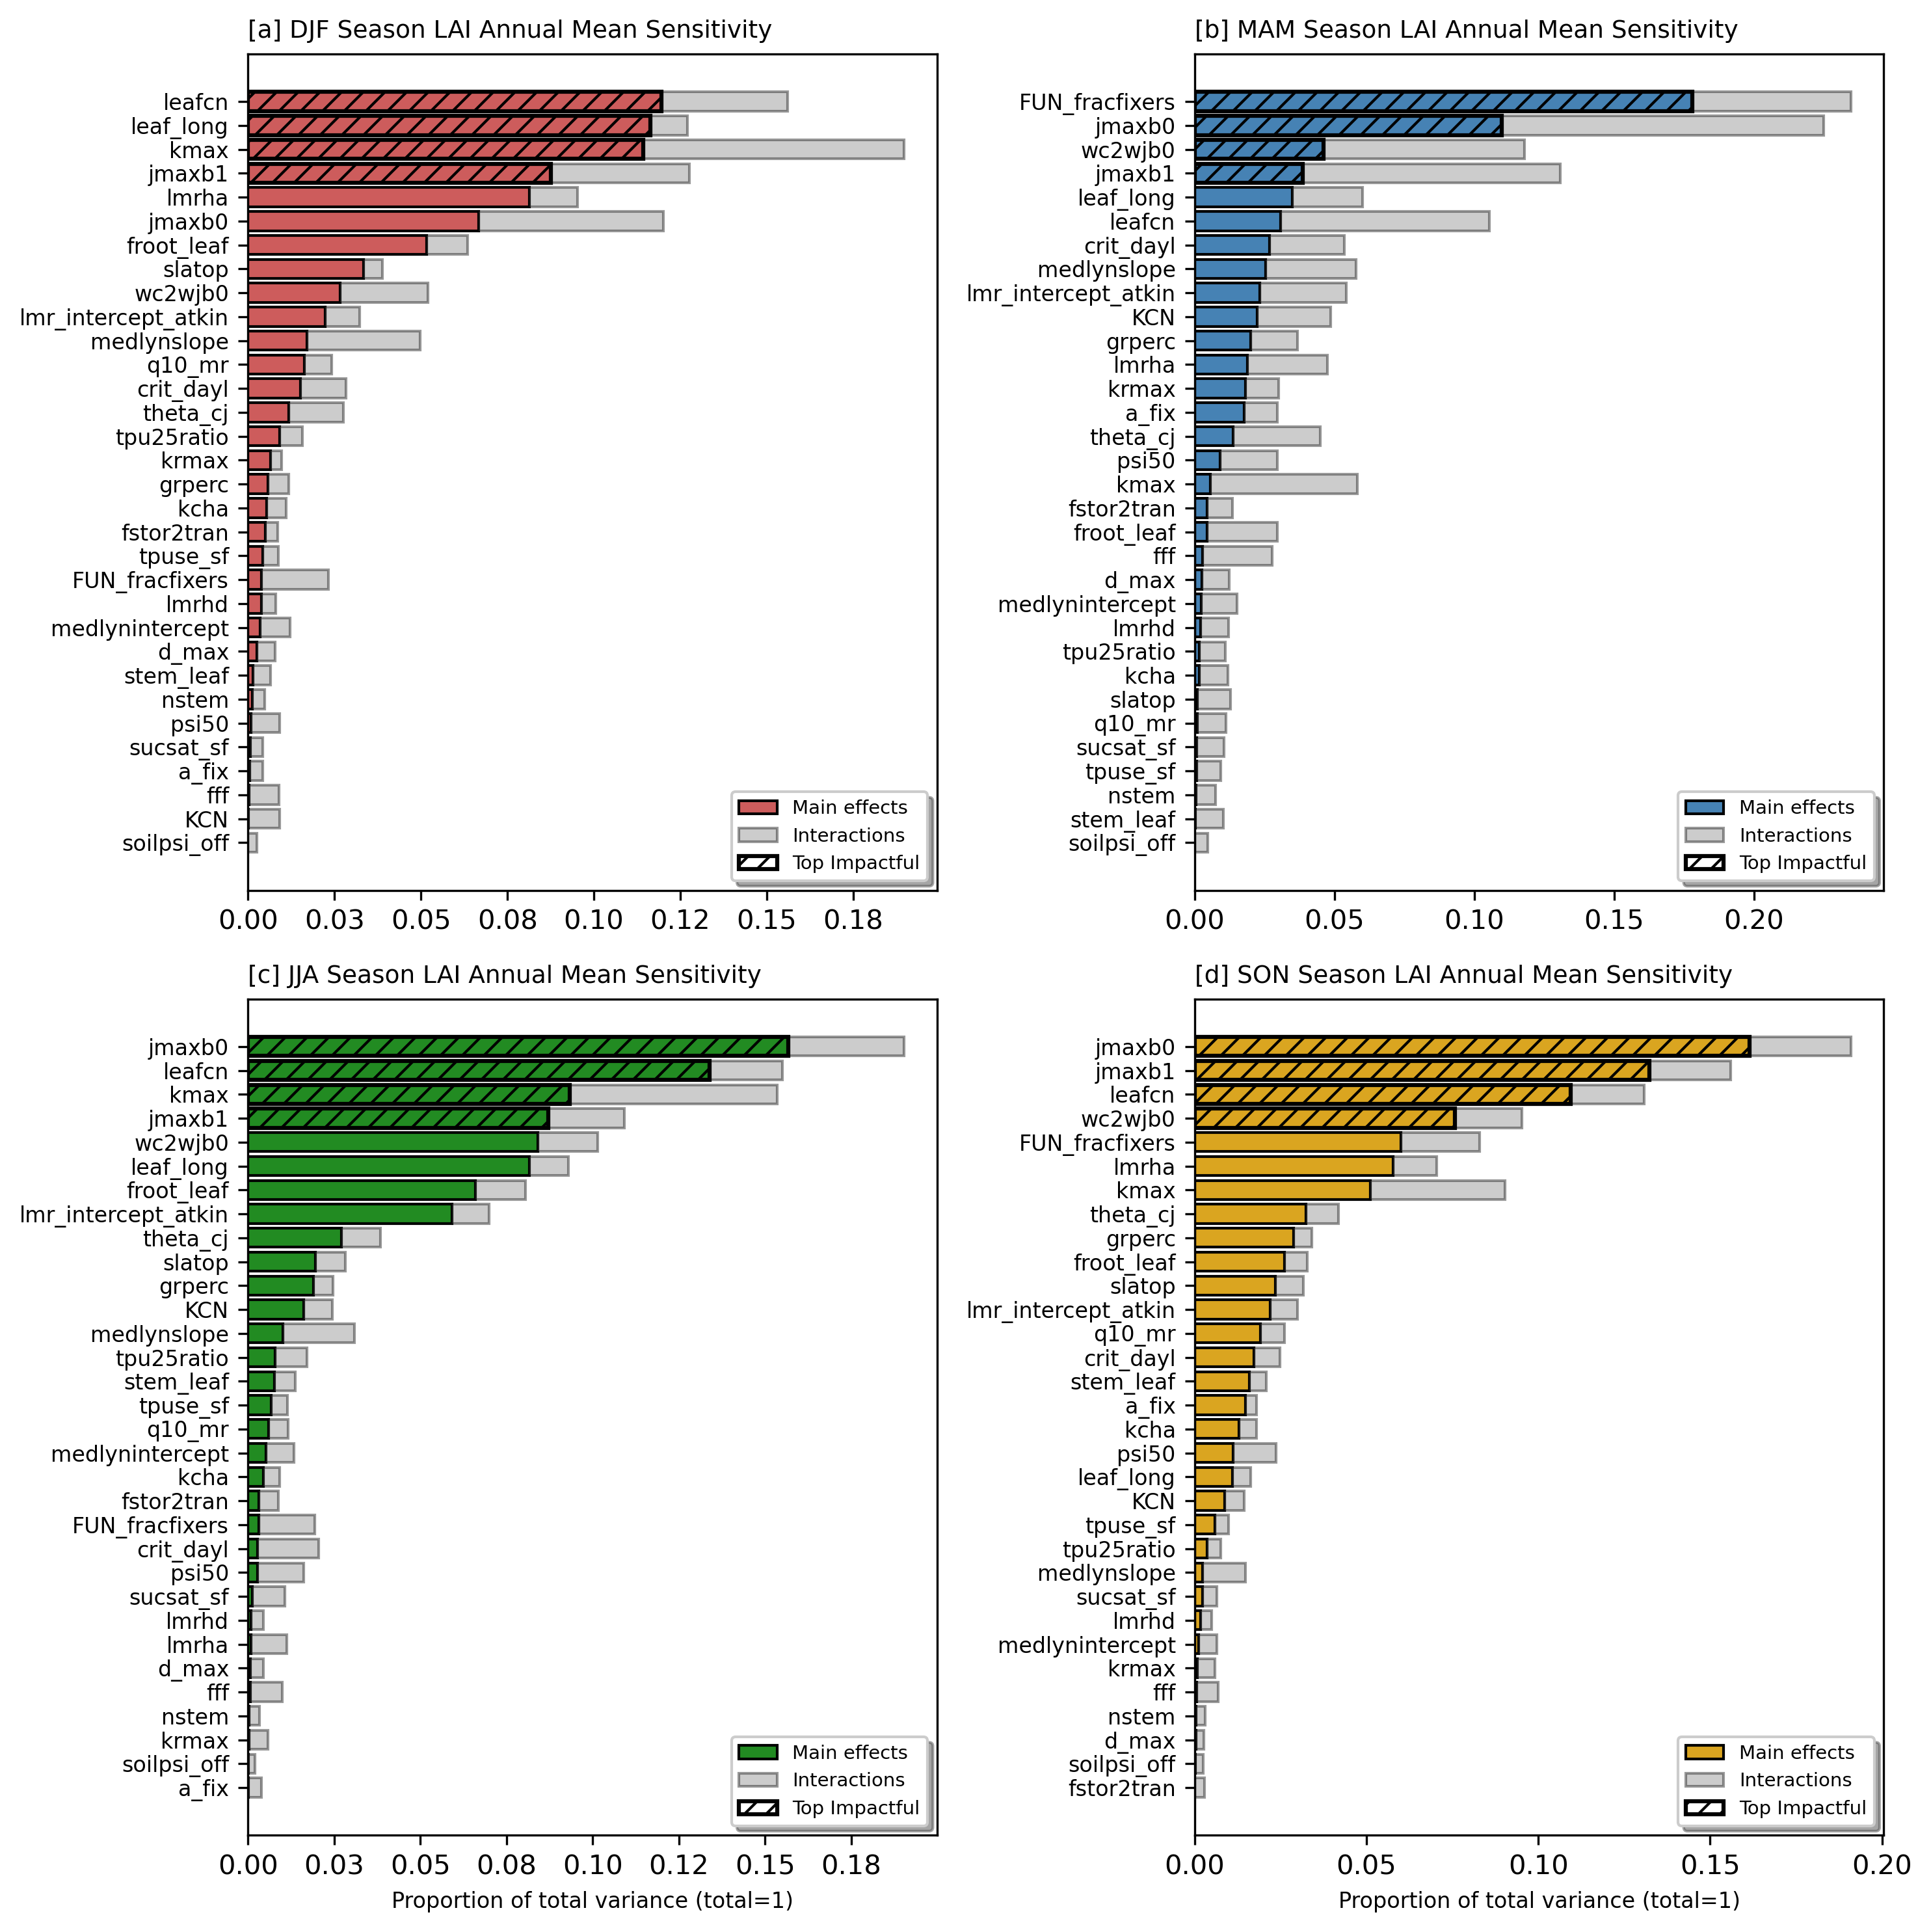

In [45]:
from matplotlib.ticker import FormatStrFormatter

def plot_sensitivity(ax, df: pd.DataFrame, title: str, bar_color: str, xlabel: bool=False):
    """
    Plot FAST sensitivity analysis sorted by ascending main‐effect S1.
    """
    # 1) Identify top 4 impactful parameters
    top4 = df.nlargest(4, 'S1')

    # 2) Sort DataFrame by S1 ascending for plotting
    df_sorted = df.sort_values('S1', ascending=True).reset_index(drop=True)

    # 3) Plot main effects
    ax.barh(df_sorted['names'], df_sorted['S1'],
            color=bar_color, edgecolor='black', label='Main effects')

    # 4) Plot interactions stacked on main effects
    ax.barh(df_sorted['names'], df_sorted['ST'] - df_sorted['S1'],
            left=df_sorted['S1'], color='grey', alpha=0.4,
            edgecolor='black', label='Interactions')

    # 5) Overlay hatches on the top 4 (from original df)
    for i, name in enumerate(top4['names']):
        # find its position in the sorted frame
        pos = df_sorted.index[df_sorted['names'] == name][0]
        ax.barh(df_sorted.loc[pos, 'names'],
                df_sorted.loc[pos, 'S1'],
                color='none', hatch='///',
                edgecolor='black', linewidth=1.5,
                label='Top Impactful' if i == 0 else None)

    # 6) Y‐axis labels
    ax.set_yticks(df_sorted.index)
    ax.set_yticklabels(df_sorted['names'], fontsize=8)

    # 7) X‐axis formatting
    if xlabel:
        ax.set_xlabel('Proportion of total variance (total=1)', fontsize=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # 8) Titles and annotations
    ax.set_title(title, loc='left', fontsize=9)
    # ax.text(0.98, 0.95, 'FAST',
    #         transform=ax.transAxes, ha='right', fontsize=9)

    # 9) Legend
    ax.legend(loc='lower right', frameon=True,
              shadow=True, fancybox=True, fontsize=7)

    
fig, axs = plt.subplots(2, 2, figsize=(10,10), dpi=300)

plot_sensitivity(axs[0,0], df_Si_djf, '[a] DJF Season LAI Annual Mean Sensitivity', 'indianred', xlabel=False)
plot_sensitivity(axs[0,1], df_Si_mam, '[b] MAM Season LAI Annual Mean Sensitivity', 'steelblue', xlabel=False)
plot_sensitivity(axs[1,0], df_Si_jja, '[c] JJA Season LAI Annual Mean Sensitivity', 'forestgreen', xlabel=True)
plot_sensitivity(axs[1,1], df_Si_son, '[d] SON Season LAI Annual Mean Sensitivity', 'goldenrod', xlabel=True)

plt.tight_layout()
plt.savefig(figure_path+"/_fast_season_2x2_highlight.pdf", format='pdf', bbox_inches='tight')
plt.show()

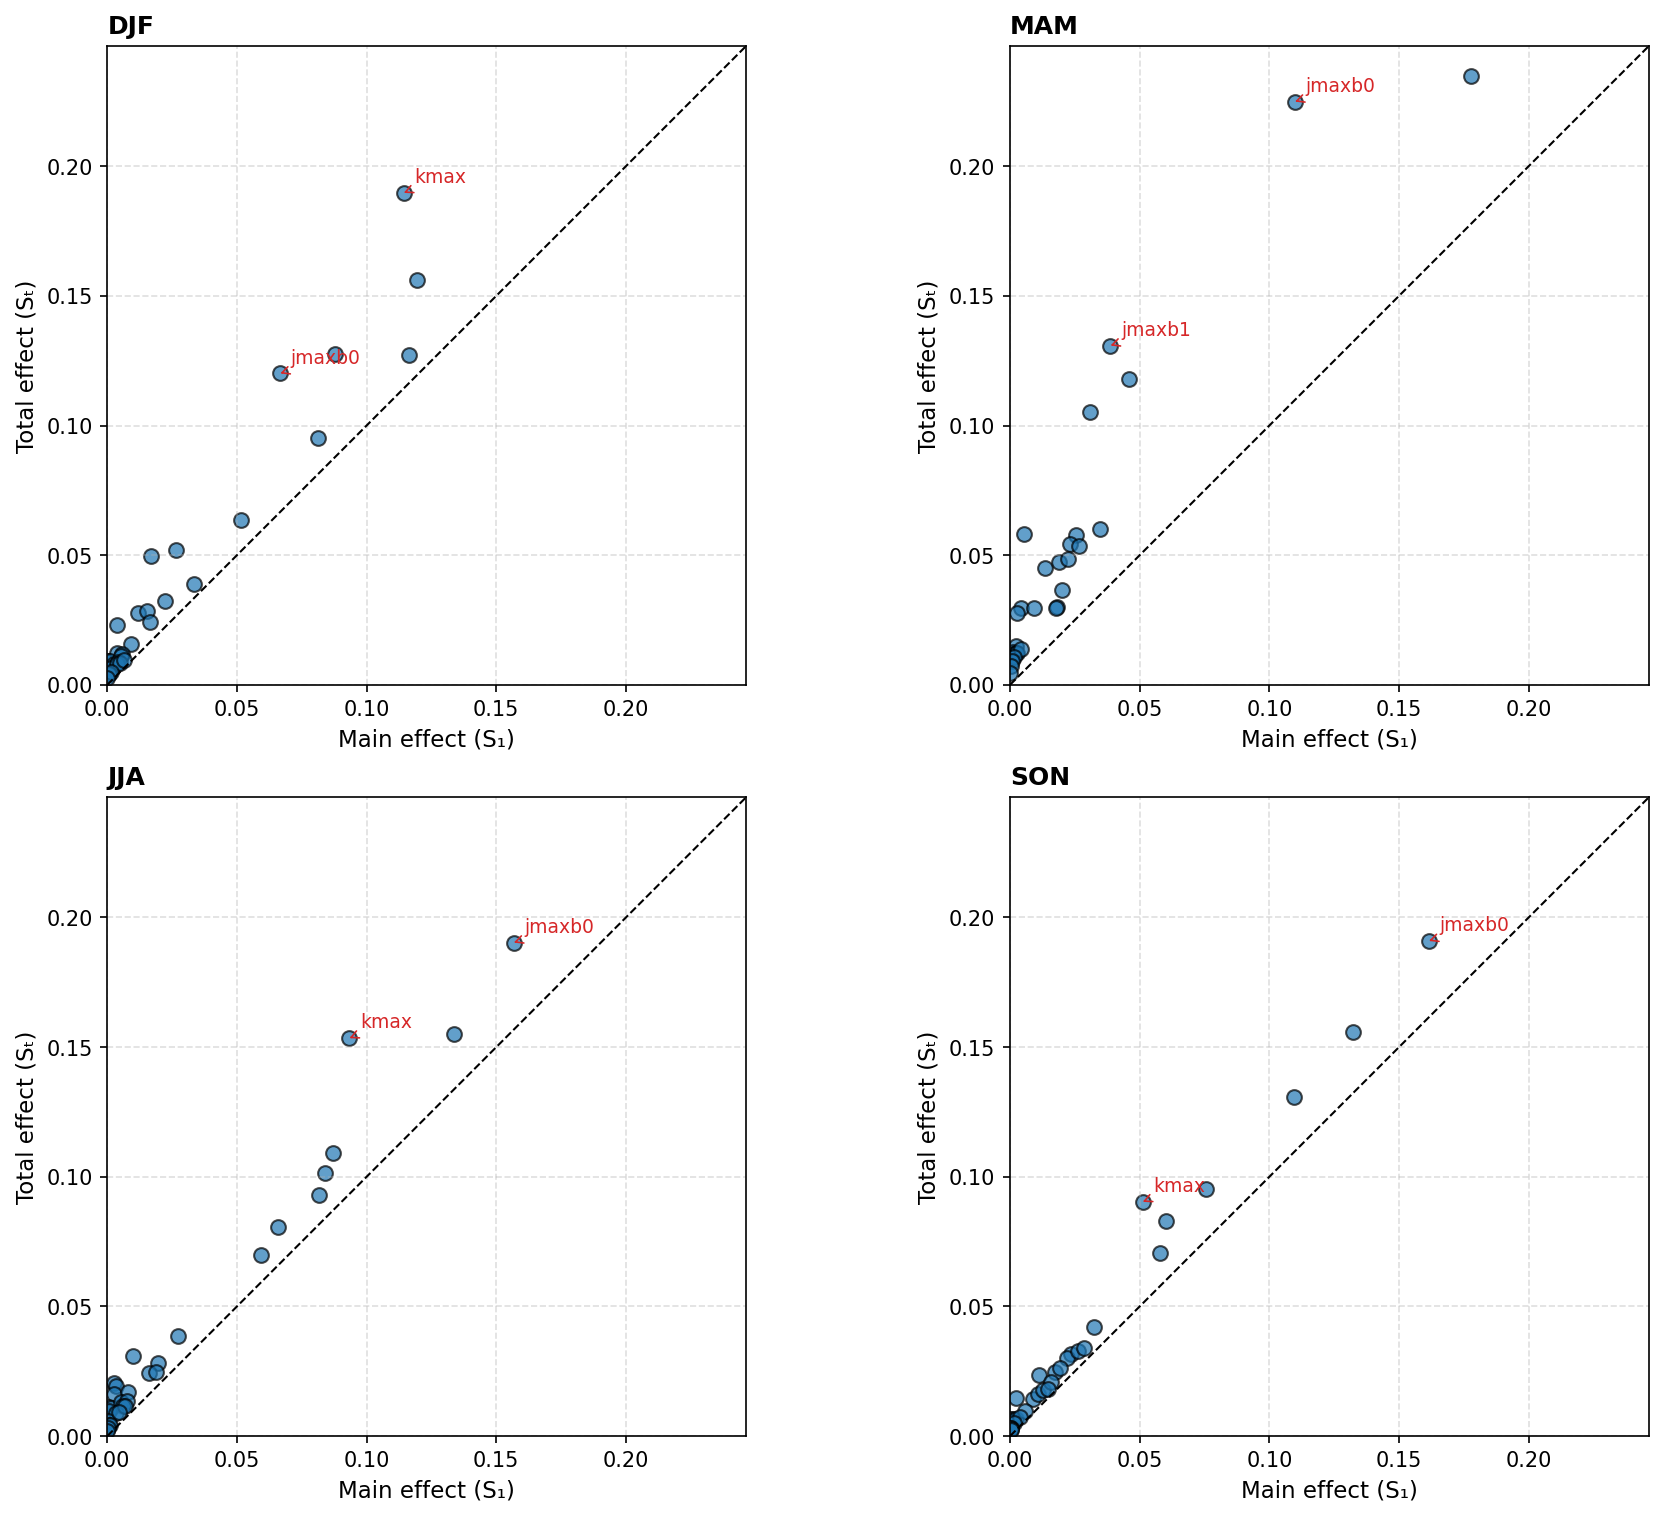

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# — build your season DataFrames (if not already done) —
season_dfs = {}
for season in ['DJF','MAM','JJA','SON']:
    res = season_results[season]
    df = pd.DataFrame({
        'parameter': res['names'],
        'S1':        res['S1'],
        'ST':        res['ST'],
    })
    # compute interaction strength
    df['interaction'] = df['ST'] - df['S1']
    # sort so that annotation picks top interactors
    season_dfs[season] = df.sort_values('interaction', ascending=False).reset_index(drop=True)

# — plot —
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150, constrained_layout=True)
axes = axes.flatten()

# global 1:1 line limits
max_val = max(df['ST'].max() for df in season_dfs.values()) * 1.05

for ax, (season, df) in zip(axes, season_dfs.items()):
    # scatter all points
    ax.scatter(df['S1'], df['ST'],
               s=50,
               edgecolor='k',
               facecolor='C0',
               alpha=0.7,
               label='Parameters'
    )

    # 1:1 line
    ax.plot([0, max_val], [0, max_val], 'k--', lw=1, label='S₁ = Sₜ')

    # annotate the top 2 interacting parameters
    for idx in df.index[:2]:
        row = df.loc[idx]
        ax.annotate(row['parameter'],
                    (row['S1'], row['ST']),
                    xytext=(5,5),
                    textcoords='offset points',
                    fontsize=9,
                    color='C3',
                    arrowprops=dict(arrowstyle='->', lw=0.8, color='C3')
        )

    ax.set_title(f'{season}', loc='left', fontsize=12, fontweight='bold')
    ax.set_xlabel('Main effect (S₁)', fontsize=11)
    ax.set_ylabel('Total effect (Sₜ)', fontsize=11)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_aspect('equal', 'box')
    ax.grid(True, linestyle='--', alpha=0.4)

# shared legend (only once)
handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', ncol=2, frameon=False, fontsize=11)

# fig.suptitle('Main vs. Total Sobol Sensitivity by Season', fontsize=14, y=1.02)
# plt.savefig('./Figures/s1_vs_st_scatter_by_season.pdf', bbox_inches='tight')
plt.show()
